In [1]:
import warnings
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib as mpl
from tqdm import tqdm_notebook as tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import timedelta
from datetime import datetime
from cycler import cycler

In [2]:
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 26
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['#CF353C', '#FFE3A6',
#                                                 '#727272'])

In [3]:
mpl.rcParams['axes.prop_cycle']

cycler('color', ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])

# Data Extraction

In [4]:
df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Release Date'] = pd.to_datetime(df['Release Date'])
df.head()

Order Date   Brand                                   Sneaker Name  \
0 2017-09-01   Yeezy           Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1 2017-09-01   Yeezy    Adidas-Yeezy-Boost-350-V2-Core-Black-Copper   
2 2017-09-01   Yeezy     Adidas-Yeezy-Boost-350-V2-Core-Black-Green   
3 2017-09-01   Yeezy       Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4 2017-09-01   Yeezy  Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017   

   Sale Price  Retail Price Release Date  Shoe Size  Buyer Region  
0      1097.0           220   2016-09-24       11.0    California  
1       685.0           220   2016-11-23       11.0    California  
2       690.0           220   2016-11-23       11.0    California  
3      1075.0           220   2016-11-23       11.5      Kentucky  
4       828.0           220   2017-02-11       11.0  Rhode Island

# Exploratory Data Analysis

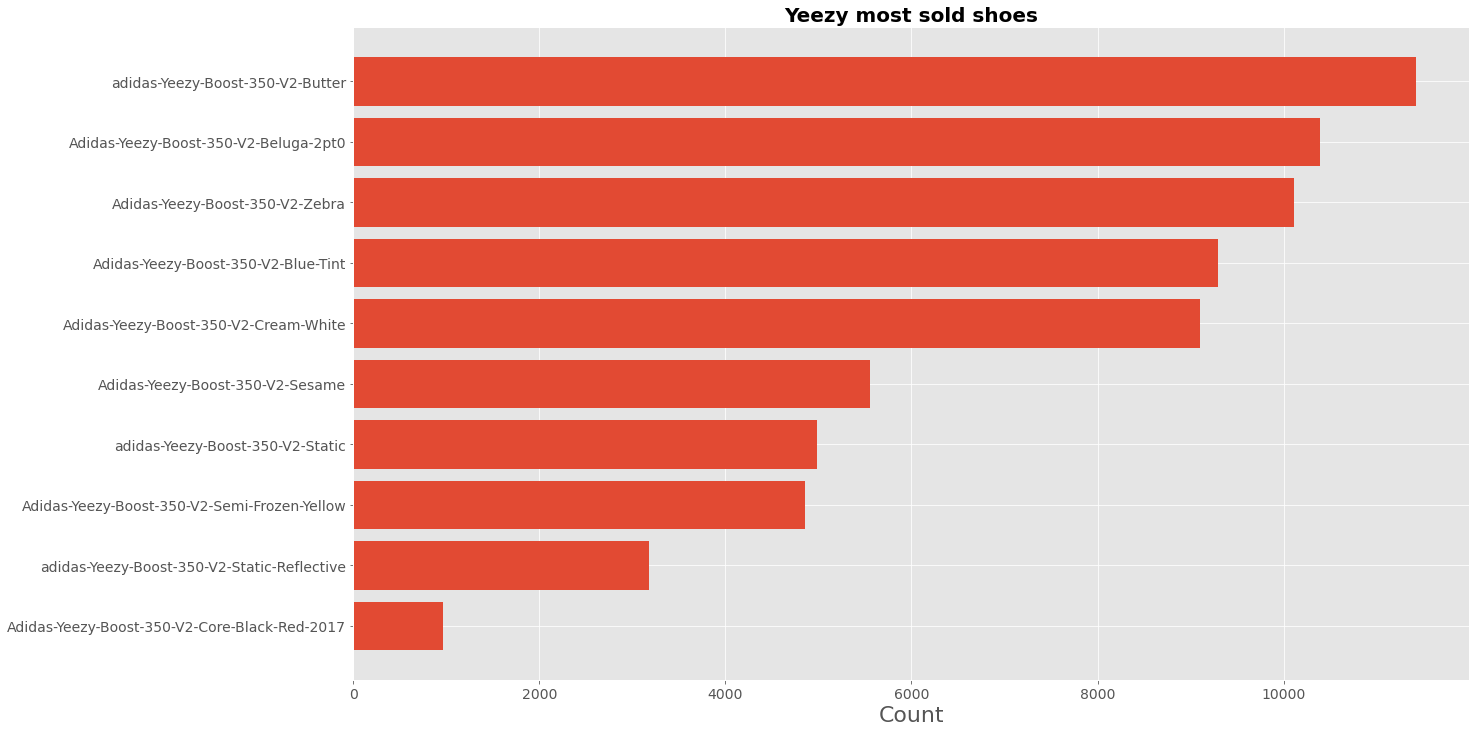

In [5]:
freq_shoes = (df.loc[df.Brand == ' Yeezy'].groupby(['Sneaker Name'])
              .size().nlargest(10).reset_index().sort_values(by=0))

# freq_shoes['Variant'] = (freq_shoes['Sneaker Name'].astype(str)
#                          + '_' + freq_shoes['Shoe Size'].astype(str))

freq_shoes.sort_values(by=0, inplace=True, ascending=True)

plt.figure(figsize=(20, 12))
plt.barh(freq_shoes['Sneaker Name'], width=freq_shoes[0])
plt.xlabel('Count')
# plt.xlim(900)
plt.title('Yeezy most sold shoes')
plt.show()
# del freq_shoes

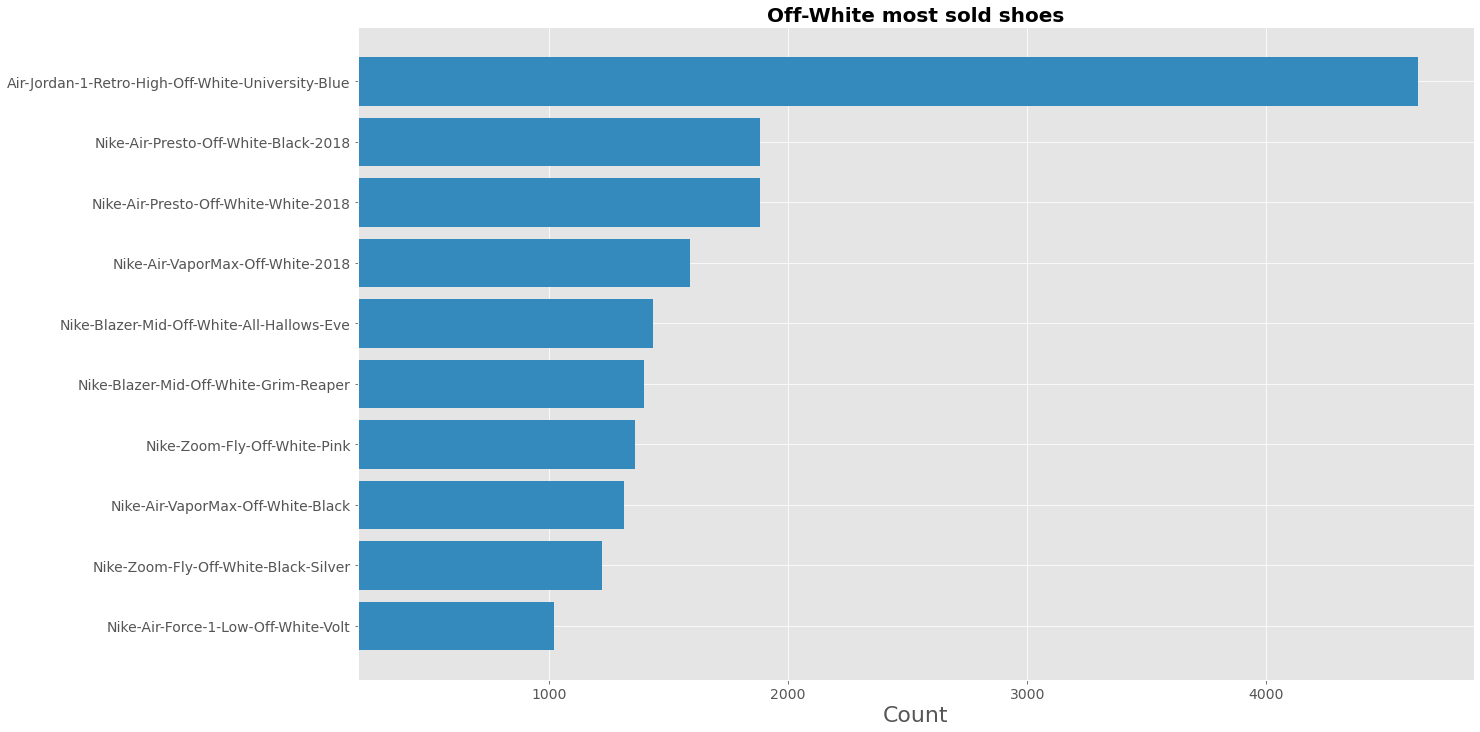

In [6]:
freq_shoes = (df.loc[df.Brand == 'Off-White'].groupby(['Sneaker Name'])
              .size().nlargest(10).reset_index().sort_values(by=0))

# freq_shoes['Variant'] = (freq_shoes['Sneaker Name'].astype(str)
#                          + '_' + freq_shoes['Shoe Size'].astype(str))
freq_shoes.sort_values(by=0, inplace=True)
plt.figure(figsize=(20, 12))
plt.barh(freq_shoes['Sneaker Name'], width=freq_shoes[0], color='#348ABD')
plt.xlabel('Count')
plt.xlim(200)
plt.title('Off-White most sold shoes')
plt.show()

In [7]:
def get_shoes(name, size=None):
    """Get data for shoes, all shoe size if size is None"""
    if size is None:
        return df.loc[df['Sneaker Name'] == name].copy()
    else:
        m1 = df['Sneaker Name'] == name
        m2 = df['Shoe Size'] == size
        return df.loc[m1 & m2].copy()

## Yeezy Beluga Size 10

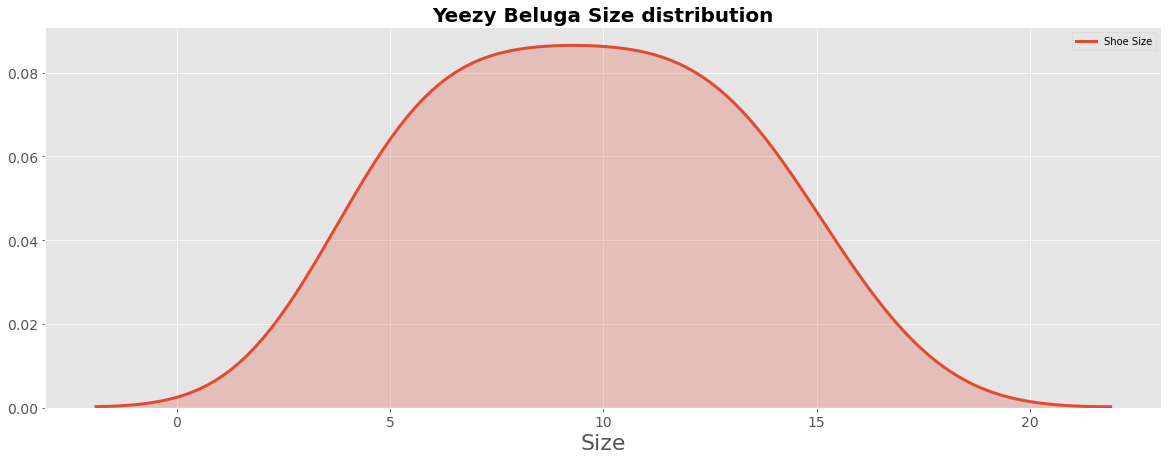

In [8]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(get_shoes('Adidas-Yeezy-Boost-350-V2-Beluga-2pt0')
            .groupby('Shoe Size')['Shoe Size']
            .mean().sort_index(), shade=True)

ymean = get_shoes('Adidas-Yeezy-Boost-350-V2-Beluga-2pt0')['Shoe Size'].mean()
plt.title('Yeezy Beluga Size distribution')
plt.xlabel('Size');

In [9]:
yeezy_beluga_10 = get_shoes('Adidas-Yeezy-Boost-350-V2-Beluga-2pt0', 10)

Number of sold dates for size 10:  340


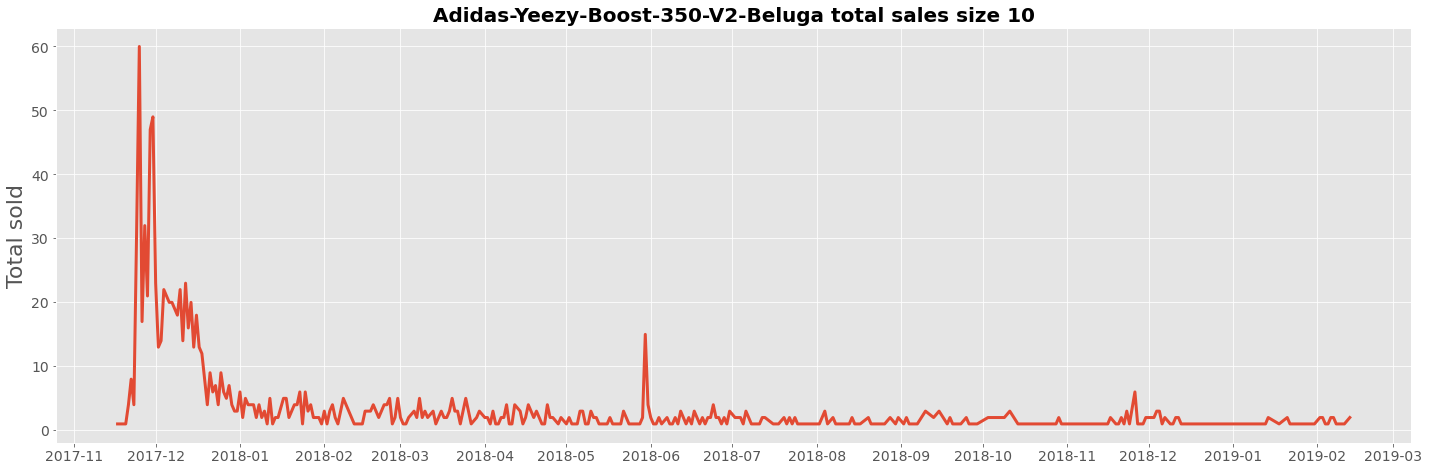

In [10]:
print('Number of sold dates for size 10: ',
      yeezy_beluga_10['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(yeezy_beluga_10['Order Date'].value_counts().sort_index())
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Total sold')

plt.title('Adidas-Yeezy-Boost-350-V2-Beluga total sales size 10')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Number of sold dates for size 10:  340


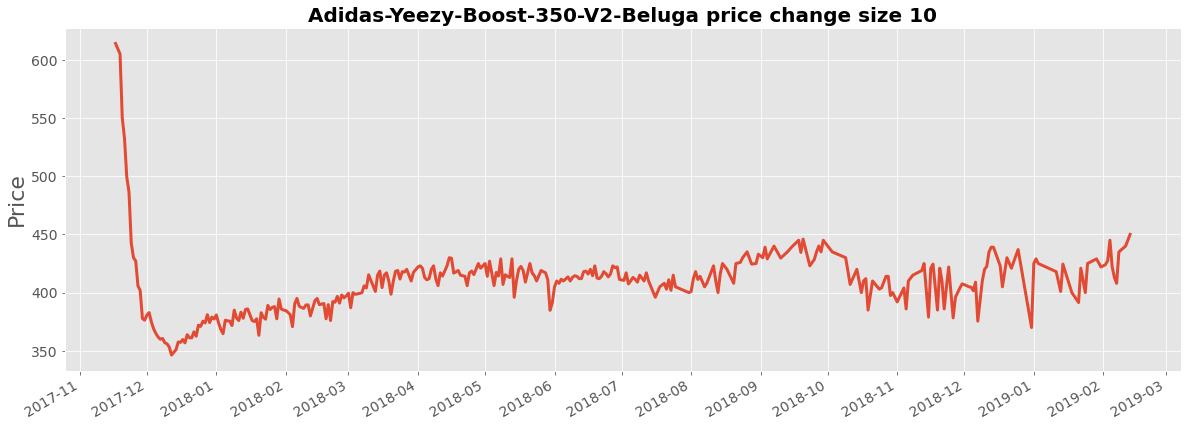

In [11]:
print('Number of sold dates for size 10: ',
      yeezy_beluga_10['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(yeezy_beluga_10.groupby('Order Date')['Sale Price']
        .mean().sort_index())
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.title('Adidas-Yeezy-Boost-350-V2-Beluga price change size 10')
fig.autofmt_xdate()

plt.show()

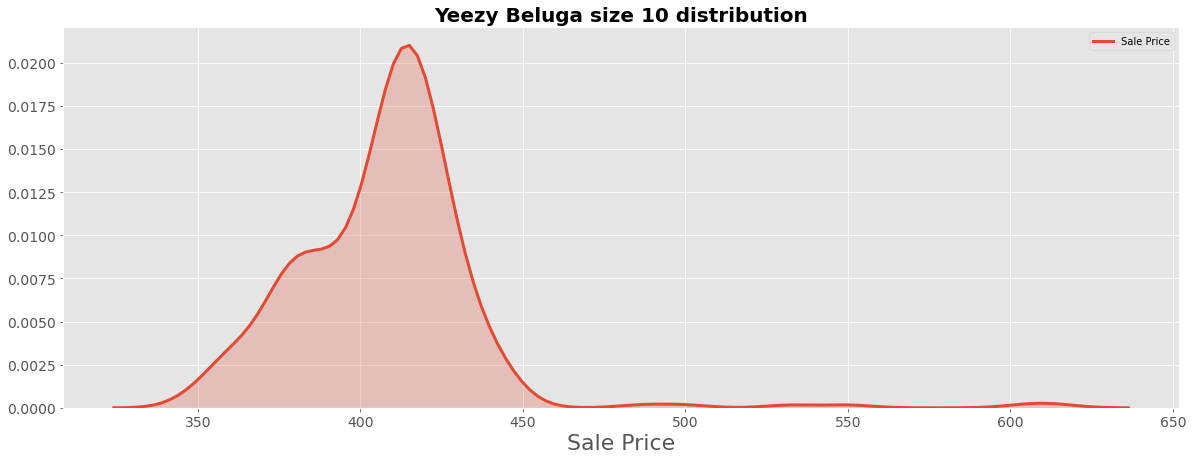

In [12]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(yeezy_beluga_10.groupby('Order Date')['Sale Price']
            .mean().sort_index(), shade=True)
plt.title('Yeezy Beluga size 10 distribution')
plt.xlabel('Sale Price');

## Jordan 1 Retro University Blue Size 9

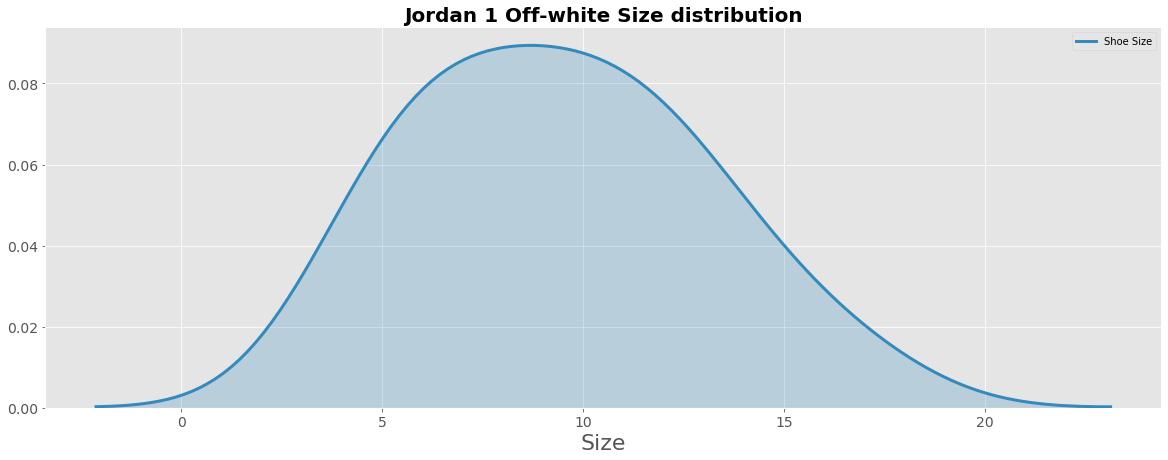

In [13]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(get_shoes('Air-Jordan-1-Retro-High-Off-White-University-Blue')
            .groupby('Shoe Size')['Shoe Size']
            .mean().sort_index(), shade=True, color='#348ABD')
plt.title('Jordan 1 Off-white Size distribution')
plt.xlabel('Size');

In [14]:
jordan1_uni_blue_9 = get_shoes(
    'Air-Jordan-1-Retro-High-Off-White-University-Blue', 9)

Number of sold dates for size 10:  108


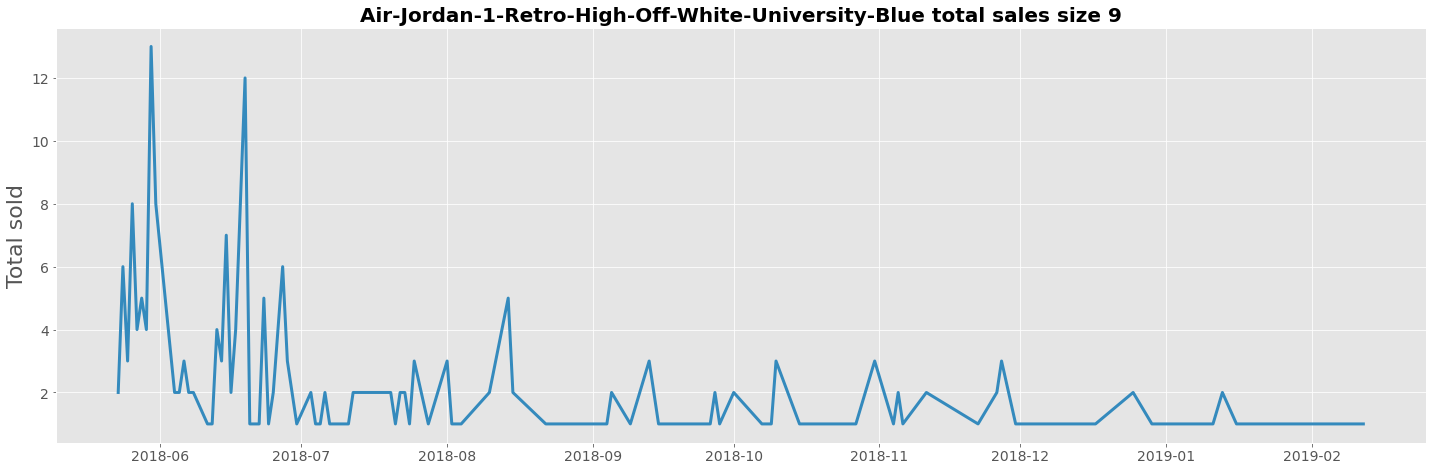

In [15]:
print('Number of sold dates for size 10: ',
      jordan1_uni_blue_9['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(jordan1_uni_blue_9['Order Date'].value_counts().sort_index(),
        color='#348ABD')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Total sold')

plt.title('Air-Jordan-1-Retro-High-Off-White-University-Blue total '
          'sales size 9')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Number of sold dates for size 10:  108


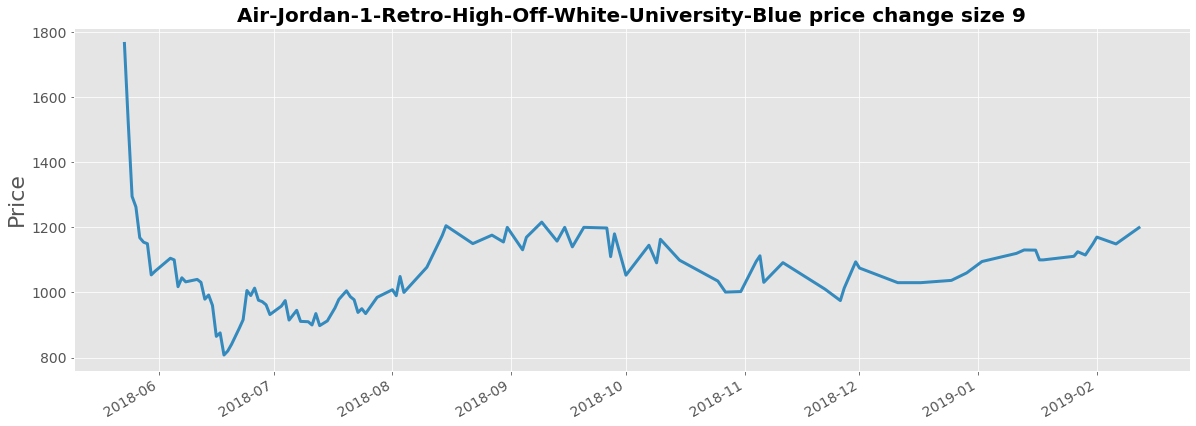

In [16]:
print('Number of sold dates for size 10: ',
      jordan1_uni_blue_9['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(jordan1_uni_blue_9.groupby('Order Date')['Sale Price']
        .mean().sort_index(), color='#348ABD')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.title('Air-Jordan-1-Retro-High-Off-White-University-Blue '
          'price change size 9')
fig.autofmt_xdate()

plt.show()

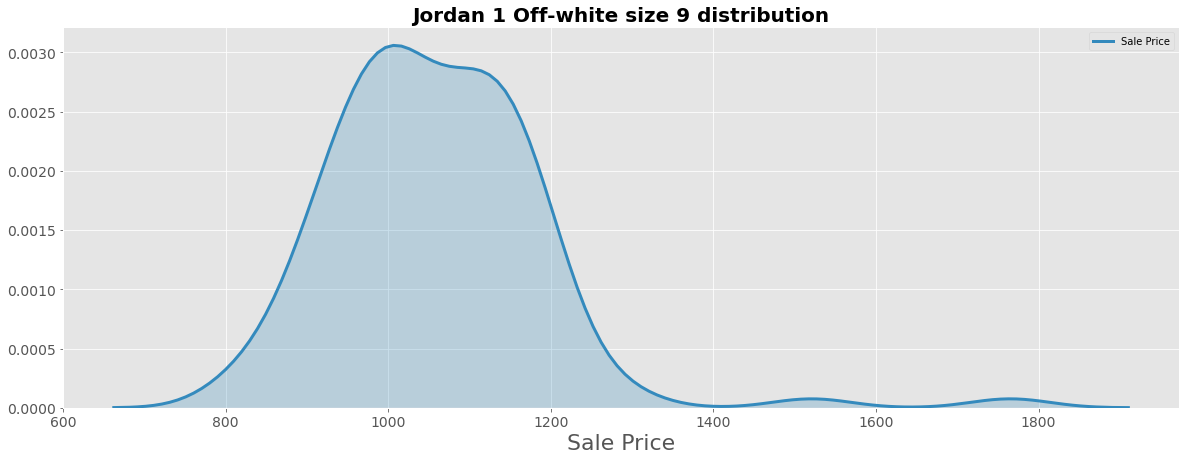

In [17]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(jordan1_uni_blue_9.groupby('Order Date')['Sale Price']
            .mean().sort_index(),
            color='#348ABD',
            shade=True)
plt.title('Jordan 1 Off-white size 9 distribution')
plt.xlabel('Sale Price');

# Regression
## Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint

Sneaker Name is ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint'
    - Accuracy dropped even further after limiting dataset to shoe size 10 (best R2 0.5797)
        - Previously best R2 0.8032 for dtaaset with shoe sizes 9, 10, and 11
    - Extra Trees best for 7-day prediction
    - CatBoost best for 30-day prediction
    - TheilSen Net best for 90-day prediction

### Data Processing and EDA

In [18]:
plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['axes.prop_cycle'] = color=['#CF353C', 'FFE3A6', '#727272']

In [19]:
#from cycler import cycler
#plt.style.use('dark_background')
#plt.style.use('dark_background')
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['teal', 'magenta', 'yellow'])

In [51]:
CUTOFF_TRAINMIN = '2018-01-01'
CUTOFF_TRAINVAL = '2018-11-15'
#yeezy Jan 1, 2018
#john jun 1, 2018

df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Sneaker Name'] = df['Brand'] + ' - ' + df['Sneaker Name']
df['DaysStored'] = pd.Series(df['Order Date'] - df['Release Date']).apply(lambda x: x.days)
df = df[['Order Date', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
df

Order Date                                       Sneaker Name  \
0     2017-09-01       Yeezy - Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
2     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
3     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
...          ...                                                ...   
99951 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99952 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99953 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99954 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99955 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   

       Shoe Size  Sale Price  DaysStored  
0           11.0      1097.0         342  
1           11.0       685.0         282  
2           11.0       690.0         282  
3           11.5      1075.0         282  
4           11.0       828.0         202  
...          ...         ...         ...  
99951        8.0       565.0          49  
99952        8.5       598.0          49  
99953        5.5       605.0          49  
99954       11.0       650.0          49  
99955       11.5       640.0          49  

[99956 rows x 5 columns]

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Sneaker Name  99956 non-null  object        
 2   Shoe Size     99956 non-null  float64       
 3   Sale Price    99956 non-null  float64       
 4   DaysStored    99956 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.8+ MB


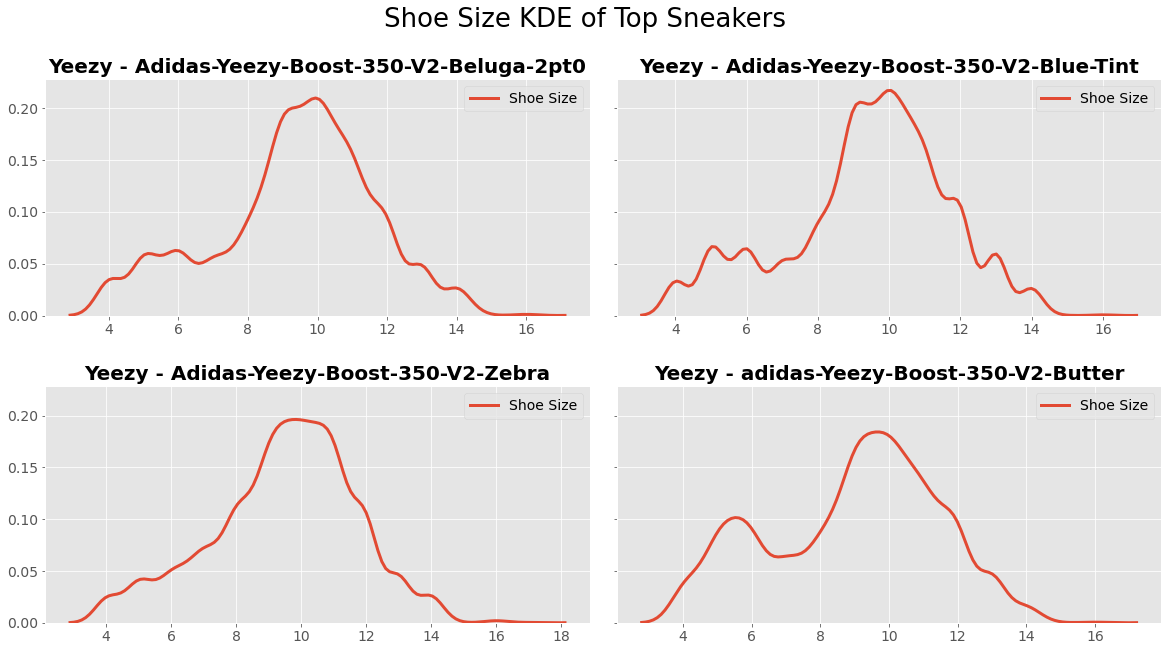

In [53]:
top_sneakers = df.groupby(['Sneaker Name', 'Shoe Size']).size().reset_index().nlargest(9, 0)['Sneaker Name'].to_list()
top_sneakers = sorted(list(set(top_sneakers)))

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharey = True)
fig.subplots_adjust(hspace=0.3, wspace=0.05)
fig.suptitle('Shoe Size KDE of Top Sneakers')

x, y = 0, 0
for i in range(0, len(top_sneakers)):
    x, y = int(i/2), i % 2
    sns.kdeplot(data=df[df['Sneaker Name']==top_sneakers[i]]['Shoe Size'], ax=ax[x][y])
    ax[x][y].set_title(top_sneakers[i].strip(), fontsize=20)

### Filter to single Sneaker Name

In [54]:
top_sneakers

[' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Zebra',
 ' Yeezy - adidas-Yeezy-Boost-350-V2-Butter']

In [55]:
sneaker_name = ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint'
df_agg = df[(df['Sneaker Name']==sneaker_name) & \
            (df['Shoe Size'].isin([10]))].copy()
df_agg = df_agg.groupby(['Order Date', 'Sneaker Name', 'Shoe Size']).mean().reset_index()
df_agg

Order Date                                  Sneaker Name  Shoe Size  \
0   2017-12-13   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
1   2017-12-14   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
2   2017-12-15   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
3   2017-12-16   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
4   2017-12-17   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
..         ...                                           ...        ...   
315 2019-02-05   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
316 2019-02-07   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
317 2019-02-09   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
318 2019-02-10   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
319 2019-02-11   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   

     Sale Price  DaysStored  
0    448.500000          -3  
1    396.000000          -2  
2    366.785714          -1  
3    379.837209           0  
4    387.578947           1  
..          ...         ...  
315  349.000000         416  
316  339.500000         418  
317  362.000000         420  
318  363.333333         421  
319  381.000000         422  

[320 rows x 5 columns]

In [56]:
#start_dt = df_agg['Order Date'].min()
start_dt = datetime.strptime(CUTOFF_TRAINMIN, '%Y-%m-%d')
end_dt = df_agg['Order Date'].max()

df_cal = pd.DataFrame({'dt': pd.date_range(start_dt, end_dt)})
df_cal['dt_str'] = df_cal['dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_cal['lst_lb15'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(15 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb30'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(30 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb60'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(60 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb180'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(180 - 1)).strftime('%Y-%m-%d').to_list())

df_cal['lb15_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(15 - 1)).strftime('%Y-%m-%d'))
df_cal['lb30_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(30 - 1)).strftime('%Y-%m-%d'))
df_cal['lb60_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(60 - 1)).strftime('%Y-%m-%d'))
df_cal['lb180_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(180 - 1)).strftime('%Y-%m-%d'))

df_cal['lb15_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(22)).strftime('%Y-%m-%d'))
df_cal['lb30_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(37)).strftime('%Y-%m-%d'))
df_cal['lb60_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(67)).strftime('%Y-%m-%d'))

df_cal['lb60_plus30'] = df_cal['dt'].apply(lambda x: (x + timedelta(90)).strftime('%Y-%m-%d'))
df_cal['lb180_plus90'] = df_cal['dt'].apply(lambda x: (x + timedelta(270)).strftime('%Y-%m-%d'))


print(df_cal.shape, df_cal.columns)
df_cal.head(5)

(407, 15) Index(['dt', 'dt_str', 'lst_lb15', 'lst_lb30', 'lst_lb60', 'lst_lb180',
       'lb15_last', 'lb30_last', 'lb60_last', 'lb180_last', 'lb15_plus7',
       'lb30_plus7', 'lb60_plus7', 'lb60_plus30', 'lb180_plus90'],
      dtype='object')


dt      dt_str                                           lst_lb15  \
0 2018-01-01  2018-01-01  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1 2018-01-02  2018-01-02  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2 2018-01-03  2018-01-03  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3 2018-01-04  2018-01-04  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4 2018-01-05  2018-01-05  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                            lst_lb30  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                            lst_lb60  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                           lst_lb180   lb15_last   lb30_last  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...  2018-01-15  2018-01-30   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...  2018-01-16  2018-01-31   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...  2018-01-17  2018-02-01   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...  2018-01-18  2018-02-02   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...  2018-01-19  2018-02-03   

    lb60_last  lb180_last  lb15_plus7  lb30_plus7  lb60_plus7 lb60_plus30  \
0  2018-03-01  2018-06-29  2018-01-23  2018-02-07  2018-03-09  2018-04-01   
1  2018-03-02  2018-06-30  2018-01-24  2018-02-08  2018-03-10  2018-04-02   
2  2018-03-03  2018-07-01  2018-01-25  2018-02-09  2018-03-11  2018-04-03   
3  2018-03-04  2018-07-02  2018-01-26  2018-02-10  2018-03-12  2018-04-04   
4  2018-03-05  2018-07-03  2018-01-27  2018-02-11  2018-03-13  2018-04-05   

  lb180_plus90  
0   2018-09-28  
1   2018-09-29  
2   2018-09-30  
3   2018-10-01  
4   2018-10-02

In [57]:
df_tmp = df_cal[['dt', 'dt_str']].copy()
df_tmp['key'] = 0
print('df_tmp.shape', df_tmp.shape)

df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Sneaker Name': [sneaker_name]}), how='outer')
df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Shoe Size': [10]}), how='outer')
df_tmp = df_tmp.merge(df_agg, how='left', left_on=['dt', 'Sneaker Name', 'Shoe Size'], right_on=['Order Date', 'Sneaker Name', 'Shoe Size'])
df_tmp = df_tmp[['dt_str', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
print('df_tmp.shape', df_tmp.shape)
df_tmp.head(5)

df_tmp.shape (407, 3)
df_tmp.shape (407, 5)


dt_str                                  Sneaker Name  Shoe Size  \
0  2018-01-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   
1  2018-01-02   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   
2  2018-01-03   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   
3  2018-01-04   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   
4  2018-01-05   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   

   Sale Price  DaysStored  
0  353.888889        16.0  
1  351.812500        17.0  
2  348.600000        18.0  
3  348.166667        19.0  
4  348.285714        20.0

In [58]:
pvt_price = df_tmp[['dt_str', 'Shoe Size', 'Sale Price']].copy()
pvt_price = pvt_price.pivot(index='Shoe Size', columns='dt_str', values='Sale Price')
pvt_price = pvt_price.interpolate(method='pad', axis=0, limit_direction='forward')
print('pvt_price.shape', pvt_price.shape)

pvt_price_diff = pvt_price.diff(axis=1)
pvt_price_diff = pvt_price_diff.reset_index()
pvt_price = pvt_price.reset_index()
print(pvt_price['Shoe Size'])

pvt_store = df_tmp[['dt_str', 'Shoe Size', 'DaysStored']].copy()
pvt_store = pvt_store.pivot(index='Shoe Size', columns='dt_str', values='DaysStored')
pvt_store = pvt_store.interpolate(method='linear', axis=0, limit_direction='both')
pvt_store = pvt_store.interpolate(method='linear', axis=1, limit_direction='both')  # fill remaining nulls
print('pvt_store.shape', pvt_store.shape)
pvt_store = pvt_store.reset_index()
print(pvt_store['Shoe Size'])

pvt_price.shape (1, 407)
0    10
Name: Shoe Size, dtype: int64
pvt_store.shape (1, 407)
0    10
Name: Shoe Size, dtype: int64


In [59]:
pvt_price

dt_str  Shoe Size  2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05  \
0              10  353.888889    351.8125       348.6  348.166667  348.285714   

dt_str  2018-01-06  2018-01-07  2018-01-08  2018-01-09  ...  2019-02-02  \
0            349.0     347.625      348.25       345.8  ...         NaN   

dt_str  2019-02-03  2019-02-04  2019-02-05  2019-02-06  2019-02-07  \
0              NaN       337.5       349.0         NaN       339.5   

dt_str  2019-02-08  2019-02-09  2019-02-10  2019-02-11  
0              NaN       362.0  363.333333       381.0  

[1 rows x 408 columns]

In [60]:
pvt_price_diff

dt_str  Shoe Size  2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05  \
0              10         NaN   -2.076389     -3.2125   -0.433333    0.119048   

dt_str  2018-01-06  2018-01-07  2018-01-08  2018-01-09  ...  2019-02-02  \
0         0.714286      -1.375       0.625       -2.45  ...         NaN   

dt_str  2019-02-03  2019-02-04  2019-02-05  2019-02-06  2019-02-07  \
0              NaN         NaN        11.5         NaN         NaN   

dt_str  2019-02-08  2019-02-09  2019-02-10  2019-02-11  
0              NaN         NaN    1.333333   17.666667  

[1 rows x 408 columns]

In [61]:
df_results = pd.DataFrame({'scenario': pd.Series([], dtype=str),
                           'model': pd.Series([], dtype=str),
                           'MAE': pd.Series([], dtype=np.half),
                           'MSE': pd.Series([], dtype=np.half),
                           'RMSE': pd.Series([], dtype=np.half),
                           'R2': pd.Series([], dtype=np.half),
                           'RMSLE': pd.Series([], dtype=np.half),
                           'MAPE': pd.Series([], dtype=np.half)})
df_results

Empty DataFrame
Columns: [scenario, model, MAE, MSE, RMSE, R2, RMSLE, MAPE]
Index: []

### Regression

In [62]:
import pycaret.regression as py15
import pycaret.regression as py60
import pycaret.regression as py180
from pycaret.utils import check_metric

#### Models List

In [63]:
py15.models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm                  Support Vector Machine   
knn                   K Neighbors Regressor   
dt                            Decision Tree   
rf                            Random Forest   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                  Multi Level Perceptron   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                           Reference  Turbo  
ID                                                           
lr             sklearn.linear_model.LinearRegression   True  
lasso                     sklearn.linear_model.Lasso   True  
ridge                     sklearn.linear_model.Ridge   True  
en                   sklearn.linear_model.ElasticNet   True  
lar                        sklearn.linear_model.Lars   True  
llar                  sklearn.linear_model.LassoLars   True  
omp                         sklearn.linear_model.OMP   True  
br                sklearn.linear_model.BayesianRidge   True  
ard               sklearn.linear_model.ARDRegression  False  
par                         sklearn.linear_model.PAR   True  
ransac          sklearn.linear_model.RANSACRegressor   True  
tr            sklearn.linear_model.TheilSenRegressor   True  
huber            sklearn.linear_model.HuberRegressor   True  
kr                  sklearn.kernel_ridge.KernelRidge  False  
svm                                  sklearn.svm.SVR   True  
knn            sklearn.neighbors.KNeighborsRegressor   True  
dt                sklearn.tree.DecisionTreeRegressor   True  
rf            sklearn.ensemble.RandomForestRegressor   True  
et              sklearn.ensemble.ExtraTreesRegressor   True  
ada               sklearn.ensemble.AdaBoostRegressor   True  
gbr       sklearn.ensemble.GradientBoostingRegressor   True  
mlp              sklearn.neural_network.MLPRegressor  False  
xgboost                       xgboost.readthedocs.io   True  
lightgbm               github.com/microsoft/LightGBM   True  
catboost                         https://catboost.ai   True

#### Price (As Is), Days Stored (First Order, Predict)

#### 7-Day Prediction

##### Load Train and Test Data

In [64]:
train_win15 = df_cal[(df_cal['lb15_plus7'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb15', 'lb15_plus7']]
train_win15['label'] = train_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
train_win15['target'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win15['store_frd'] = train_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win15['store_prd'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win15['feature'] = train_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in train_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(train_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(train_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(train_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(train_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(train_win15['feature'].to_list(), axis=0)

train_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(train_win15.shape, train_win15.columns)
train_win15.head(5)

(296, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10      target  store_frd  store_prd           1           2  \
0             1  359.875000       16.0       38.0  353.888889  351.812500   
0             1  355.000000       17.0       39.0  351.812500  348.600000   
0             1  357.909091       18.0       40.0  348.600000  348.166667   
0             1  345.000000       19.0       41.0  348.166667  348.285714   
0             1  357.250000       20.0       42.0  348.285714  349.000000   

            3           4           5        6           7           8  \
0  348.600000  348.166667  348.285714  349.000  347.625000  348.250000   
0  348.166667  348.285714  349.000000  347.625  348.250000  345.800000   
0  348.285714  349.000000  347.625000  348.250  345.800000  351.750000   
0  349.000000  347.625000  348.250000  345.800  351.750000  350.666667   
0  347.625000  348.250000  345.800000  351.750  350.666667  348.000000   

            9          10          11          12          13          14  \
0  345.800000  351.750000  350.666667  348.000000  349.000000  352.000000   
0  351.750000  350.666667  348.000000  349.000000  352.000000  349.500000   
0  350.666667  348.000000  349.000000  352.000000  349.500000  346.666667   
0  348.000000  349.000000  352.000000  349.500000  346.666667  349.571429   
0  349.000000  352.000000  349.500000  346.666667  349.571429  350.000000   

           15  
0  349.500000  
0  346.666667  
0  349.571429  
0  350.000000  
0  353.111111

In [65]:
test_win15 = df_cal[(df_cal['lb15_plus7'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb15_plus7'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb15', 'lb15_plus7']]
test_win15['label'] = test_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
test_win15['target'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win15['store_frd'] = test_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win15['store_prd'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win15['feature'] = test_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in test_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(test_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(test_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(test_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(test_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(test_win15['feature'].to_list(), axis=0)

test_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(test_win15.shape, test_win15.columns)
test_win15.head(5)

(88, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0             1     NaN      312.0      334.0  363.5    NaN  370.0  351.0   
0             1     NaN      313.0      335.0    NaN  370.0  351.0    NaN   
0             1     NaN      314.0      336.0  370.0  351.0    NaN    NaN   
0             1     NaN      315.0      337.0  351.0    NaN    NaN    NaN   
0             1     NaN      316.0      338.0    NaN    NaN    NaN  326.0   

       5      6      7      8      9     10     11     12     13     14     15  
0    NaN    NaN    NaN  326.0  320.0  325.0    NaN  335.0  360.0    NaN    NaN  
0    NaN    NaN  326.0  320.0  325.0    NaN  335.0  360.0    NaN    NaN    NaN  
0    NaN  326.0  320.0  325.0    NaN  335.0  360.0    NaN    NaN    NaN  359.0  
0  326.0  320.0  325.0    NaN  335.0  360.0    NaN    NaN    NaN  359.0  364.0  
0  320.0  325.0    NaN  335.0  360.0    NaN    NaN    NaN  359.0  364.0    NaN

In [66]:
ret = py15.setup(data=train_win15, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [67]:
py15.compare_models(sort='R2')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

In [68]:
py15.compare_models(sort='RMSE')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

##### Extra Trees - MAE 6.4392, RMSE 8.3143, R2 0.5797

In [69]:
et15 = py15.create_model('et')

In [70]:
tuned_et15 = py15.tune_model(et15, optimize='RMSE', choose_better=True)

In [71]:
df_val15 = py15.predict_model(et15)

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  6.5977  70.1621  8.3763  0.6307  0.0225  0.0176

In [72]:
df_test15 = py15.predict_model(et15, data=test_win15)
df_test15

shoe_size_10      target  store_frd  store_prd      1      2      3  \
0              1         NaN      312.0      334.0  363.5    NaN  370.0   
1              1         NaN      313.0      335.0    NaN  370.0  351.0   
2              1         NaN      314.0      336.0  370.0  351.0    NaN   
3              1         NaN      315.0      337.0  351.0    NaN    NaN   
4              1         NaN      316.0      338.0    NaN    NaN    NaN   
..           ...         ...        ...        ...    ...    ...    ...   
83             1         NaN      395.0      417.0    NaN  347.0    NaN   
84             1  339.500000      396.0      418.0  347.0    NaN  360.0   
85             1         NaN      397.0      419.0    NaN  360.0  360.0   
86             1  362.000000      398.0      420.0  360.0  360.0  365.0   
87             1  363.333333      399.0      421.0  360.0  365.0    NaN   

        4      5      6      7      8      9     10     11     12     13  \
0   351.0    NaN    NaN    NaN  326.0  320.0  325.0    NaN  335.0  360.0   
1     NaN    NaN    NaN  326.0  320.0  325.0    NaN  335.0  360.0    NaN   
2     NaN    NaN  326.0  320.0  325.0    NaN  335.0  360.0    NaN    NaN   
3     NaN  326.0  320.0  325.0    NaN  335.0  360.0    NaN    NaN    NaN   
4   326.0  320.0  325.0    NaN  335.0  360.0    NaN    NaN    NaN  359.0   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
83  360.0  360.0  365.0    NaN    NaN  347.0    NaN    NaN    NaN  344.0   
84  360.0  365.0    NaN    NaN  347.0    NaN    NaN    NaN  344.0    NaN   
85  365.0    NaN    NaN  347.0    NaN    NaN    NaN  344.0    NaN  347.5   
86    NaN    NaN  347.0    NaN    NaN    NaN  344.0    NaN  347.5    NaN   
87    NaN  347.0    NaN    NaN    NaN  344.0    NaN  347.5    NaN  338.0   

       14     15     Label  
0     NaN    NaN  362.5599  
1     NaN    NaN  357.7099  
2     NaN  359.0  357.3301  
3   359.0  364.0  357.6344  
4   364.0    NaN  363.3180  
..    ...    ...       ...  
83    NaN  347.5  349.8632  
84  347.5    NaN  360.7311  
85    NaN  338.0  347.4536  
86  338.0  353.5  354.7331  
87  353.5    NaN  344.3761  

[88 rows x 20 columns]

##### Extra Trees - Prediction MAE 12.17

In [108]:
check_metric(df_test15.target, df_test15.Label, 'MAE')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
df_test15[df_test15['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win15[train_win15['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 30-Day Prediction

##### Load Train and Test Data

In [ ]:
train_win60 = df_cal[(df_cal['lb60_plus30'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb60', 'lb60_plus30']]
train_win60['label'] = train_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
train_win60['target'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win60['store_frd'] = train_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win60['store_prd'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win60['feature'] = train_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in train_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(train_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(train_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(train_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(train_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(train_win60['feature'].to_list(), axis=0)

train_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(train_win60.shape, train_win60.columns)
train_win60.head(5)

In [ ]:
test_win60 = df_cal[(df_cal['lb60_plus30'] >= CUTOFF_TRAINVAL) & (df_cal['lb60_plus30'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb60', 'lb60_plus30']]
test_win60['label'] = test_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
test_win60['target'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win60['store_frd'] = test_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win60['store_prd'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win60['feature'] = test_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in test_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(test_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(test_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(test_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(test_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(test_win60['feature'].to_list(), axis=0)

test_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(test_win60.shape, test_win60.columns)
test_win60.head(5)

In [ ]:
ret = py60.setup(data=train_win60, target='target', train_size=0.80, session_id=123, silent=True)

##### Compare Models

In [ ]:
py60.compare_models(sort='R2')

In [ ]:
py60.compare_models(sort='RMSE')

##### CatBoost - MAE 7.1496, RMSE 9.6017, R2 0.4147

In [ ]:
catb60 = py60.create_model('catboost')

In [ ]:
tuned_catb60 = py60.tune_model(catb60, optimize='RMSE', choose_better=True)

In [ ]:
df_val60 = py60.predict_model(tuned_catb60)

In [ ]:
df_test60 = py60.predict_model(tuned_catb60, data=test_win60)
df_test60

##### CatBoost - Prediction MAE 33.5024

In [ ]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

In [ ]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

##### Extra Trees - MAE 7.4734,  RMSE 9.7409, R2 0.4028

In [ ]:
et60 = py60.create_model('et')

In [ ]:
tuned_et60 = py60.tune_model(et60, optimize='RMSE', choose_better=True)

In [ ]:
df_val60 = py60.predict_model(et60)

In [ ]:
df_test60 = py60.predict_model(et60, data=test_win60)
df_test60

##### Extra Trees - Prediction MAE 28.3236

In [ ]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

In [ ]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax)

#### 90-Day Prediction

##### Load Train and Test Data

In [ ]:
train_win180 = df_cal[(df_cal['lb180_plus90'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb180', 'lb180_plus90']]
train_win180['label'] = train_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
train_win180['target'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win180['store_frd'] = train_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win180['store_prd'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win180['feature'] = train_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in train_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(train_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(train_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(train_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(train_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(train_win180['feature'].to_list(), axis=0)

train_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(train_win180.shape, train_win180.columns)
train_win180.head(5)


In [ ]:
test_win180 = df_cal[(df_cal['lb180_plus90'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb180_plus90'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb180', 'lb180_plus90']]
test_win180['label'] = test_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
test_win180['target'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win180['store_frd'] = test_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win180['store_prd'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win180['feature'] = test_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in test_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(test_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(test_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(test_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(test_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(test_win180['feature'].to_list(), axis=0)

test_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(test_win180.shape, test_win180.columns)
test_win180.head(5)


In [ ]:
ret = py180.setup(data=train_win180, target='target', train_size=0.80, session_id=123, silent=True)

##### Compare Models

In [ ]:
py180.compare_models(sort='R2')

In [ ]:
py180.compare_models(blacklist=['lar'], sort='RMSE')

##### TheilSen - MAE 9.1905, RMSE 10.6782, R2 -0.1870

In [ ]:
tr180 = py180.create_model('tr')

In [ ]:
tuned_tr180 = py180.tune_model(tr180, optimize='RMSE', choose_better=True)

In [ ]:
df_val180 = py180.predict_model(tr180)

In [ ]:
df_test180 = py180.predict_model(tr180, data=test_win180)
df_test180

##### TheilSen - Prediction MAE 12.7128

In [ ]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

In [ ]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

##### Extra Trees - MAE 11.1079, RMSE 13.5491, R2 -0.4017

In [ ]:
et180 = py180.create_model('et')

In [ ]:
tuned_et180 = py180.tune_model(et180, optimize='RMSE', choose_better=True)

In [ ]:
df_val180 = py180.predict_model(et180)

In [ ]:
df_test180 = py180.predict_model(et180, data=test_win180)
df_test180

##### Extra Trees - Prediction MAE 10.8647

In [ ]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

In [ ]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

## Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0

Sneaker Name is ' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0'
    - Accuracy dropped even further after limiting dataset to shoe size 10 (best R2 0.5834)
        - Previously best R2 ~0.80 for dtaaset with shoe sizes 9, 10, and 11
    - Extra Trees best for 7-day prediction
    - CatBoost best for 30-day prediction
    - Elastic Net best for 90-day prediction


### Data Processing and EDA

In [109]:
plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['axes.prop_cycle'] = color=['#CF353C', 'FFE3A6', '#727272']

In [110]:
CUTOFF_TRAINMIN = '2018-01-01'
CUTOFF_TRAINVAL = '2018-11-15'
#yeezy Jan 1, 2018
#john jun 1, 2018

df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Sneaker Name'] = df['Brand'] + ' - ' + df['Sneaker Name']
df['DaysStored'] = pd.Series(df['Order Date'] - df['Release Date']).apply(lambda x: x.days)
df = df[['Order Date', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
df

Order Date                                       Sneaker Name  \
0     2017-09-01       Yeezy - Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
2     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
3     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
...          ...                                                ...   
99951 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99952 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99953 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99954 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99955 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   

       Shoe Size  Sale Price  DaysStored  
0           11.0      1097.0         342  
1           11.0       685.0         282  
2           11.0       690.0         282  
3           11.5      1075.0         282  
4           11.0       828.0         202  
...          ...         ...         ...  
99951        8.0       565.0          49  
99952        8.5       598.0          49  
99953        5.5       605.0          49  
99954       11.0       650.0          49  
99955       11.5       640.0          49  

[99956 rows x 5 columns]

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Sneaker Name  99956 non-null  object        
 2   Shoe Size     99956 non-null  float64       
 3   Sale Price    99956 non-null  float64       
 4   DaysStored    99956 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.8+ MB


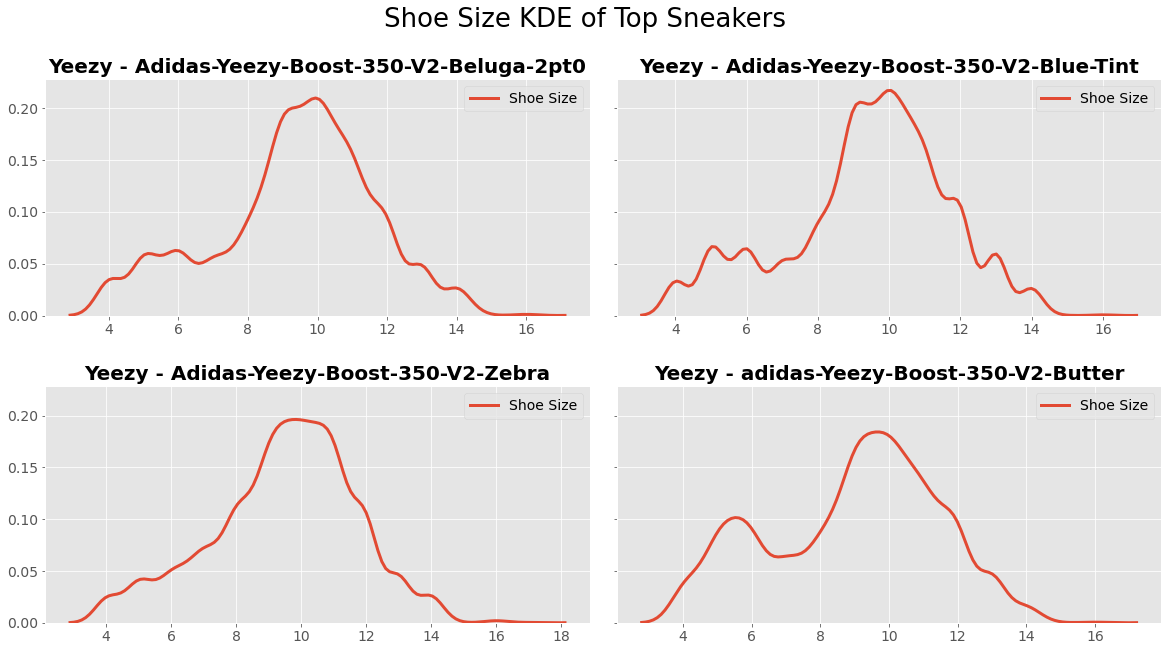

In [112]:
top_sneakers = df.groupby(['Sneaker Name', 'Shoe Size']).size().reset_index().nlargest(9, 0)['Sneaker Name'].to_list()
top_sneakers = sorted(list(set(top_sneakers)))

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharey = True)
fig.subplots_adjust(hspace=0.3, wspace=0.05)
fig.suptitle('Shoe Size KDE of Top Sneakers')

x, y = 0, 0
for i in range(0, len(top_sneakers)):
    x, y = int(i/2), i % 2
    sns.kdeplot(data=df[df['Sneaker Name']==top_sneakers[i]]['Shoe Size'], ax=ax[x][y])
    ax[x][y].set_title(top_sneakers[i].strip(), fontsize=20)

### Filter to single Sneaker Name

##### top_sneakers

In [113]:
sneaker_name = ' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0'
df_agg = df[(df['Sneaker Name']==sneaker_name) & \
            (df['Shoe Size'].isin([10]))].copy()
df_agg = df_agg.groupby(['Order Date', 'Sneaker Name', 'Shoe Size']).mean().reset_index()
df_agg

Order Date                                    Sneaker Name  Shoe Size  \
0   2017-11-17   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
1   2017-11-19   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
2   2017-11-20   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
3   2017-11-21   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
4   2017-11-22   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
..         ...                                             ...        ...   
335 2019-02-06   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
336 2019-02-07   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
337 2019-02-08   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
338 2019-02-11   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
339 2019-02-13   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   

     Sale Price  DaysStored  
0         614.0          -8  
1         605.0          -6  
2         550.0          -5  
3         532.5          -4  
4         499.5          -3  
..          ...         ...  
335       413.0         438  
336       408.0         439  
337       435.0         440  
338       440.0         443  
339       450.0         445  

[340 rows x 5 columns]

In [114]:
#start_dt = df_agg['Order Date'].min()
start_dt = datetime.strptime(CUTOFF_TRAINMIN, '%Y-%m-%d')
end_dt = df_agg['Order Date'].max()

df_cal = pd.DataFrame({'dt': pd.date_range(start_dt, end_dt)})
df_cal['dt_str'] = df_cal['dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_cal['lst_lb15'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(15 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb30'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(30 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb60'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(60 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb180'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(180 - 1)).strftime('%Y-%m-%d').to_list())

df_cal['lb15_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(15 - 1)).strftime('%Y-%m-%d'))
df_cal['lb30_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(30 - 1)).strftime('%Y-%m-%d'))
df_cal['lb60_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(60 - 1)).strftime('%Y-%m-%d'))
df_cal['lb180_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(180 - 1)).strftime('%Y-%m-%d'))

df_cal['lb15_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(22)).strftime('%Y-%m-%d'))
df_cal['lb30_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(37)).strftime('%Y-%m-%d'))
df_cal['lb60_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(67)).strftime('%Y-%m-%d'))

df_cal['lb60_plus30'] = df_cal['dt'].apply(lambda x: (x + timedelta(90)).strftime('%Y-%m-%d'))
df_cal['lb180_plus90'] = df_cal['dt'].apply(lambda x: (x + timedelta(270)).strftime('%Y-%m-%d'))


print(df_cal.shape, df_cal.columns)
df_cal.head(5)

(409, 15) Index(['dt', 'dt_str', 'lst_lb15', 'lst_lb30', 'lst_lb60', 'lst_lb180',
       'lb15_last', 'lb30_last', 'lb60_last', 'lb180_last', 'lb15_plus7',
       'lb30_plus7', 'lb60_plus7', 'lb60_plus30', 'lb180_plus90'],
      dtype='object')


dt      dt_str                                           lst_lb15  \
0 2018-01-01  2018-01-01  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1 2018-01-02  2018-01-02  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2 2018-01-03  2018-01-03  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3 2018-01-04  2018-01-04  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4 2018-01-05  2018-01-05  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                            lst_lb30  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                            lst_lb60  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                           lst_lb180   lb15_last   lb30_last  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...  2018-01-15  2018-01-30   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...  2018-01-16  2018-01-31   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...  2018-01-17  2018-02-01   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...  2018-01-18  2018-02-02   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...  2018-01-19  2018-02-03   

    lb60_last  lb180_last  lb15_plus7  lb30_plus7  lb60_plus7 lb60_plus30  \
0  2018-03-01  2018-06-29  2018-01-23  2018-02-07  2018-03-09  2018-04-01   
1  2018-03-02  2018-06-30  2018-01-24  2018-02-08  2018-03-10  2018-04-02   
2  2018-03-03  2018-07-01  2018-01-25  2018-02-09  2018-03-11  2018-04-03   
3  2018-03-04  2018-07-02  2018-01-26  2018-02-10  2018-03-12  2018-04-04   
4  2018-03-05  2018-07-03  2018-01-27  2018-02-11  2018-03-13  2018-04-05   

  lb180_plus90  
0   2018-09-28  
1   2018-09-29  
2   2018-09-30  
3   2018-10-01  
4   2018-10-02

In [115]:
df_tmp = df_cal[['dt', 'dt_str']].copy()
df_tmp['key'] = 0
print('df_tmp.shape', df_tmp.shape)

df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Sneaker Name': [sneaker_name]}), how='outer')
df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Shoe Size': [10]}), how='outer')
df_tmp = df_tmp.merge(df_agg, how='left', left_on=['dt', 'Sneaker Name', 'Shoe Size'], right_on=['Order Date', 'Sneaker Name', 'Shoe Size'])
df_tmp = df_tmp[['dt_str', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
print('df_tmp.shape', df_tmp.shape)
df_tmp.head(5)

df_tmp.shape (409, 3)
df_tmp.shape (409, 5)


dt_str                                    Sneaker Name  Shoe Size  \
0  2018-01-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   
1  2018-01-02   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   
2  2018-01-03   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   
3  2018-01-04   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   
4  2018-01-05   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   

   Sale Price  DaysStored  
0  380.833333        37.0  
1  374.000000        38.0  
2  368.400000        39.0  
3  364.750000        40.0  
4  376.250000        41.0

In [116]:
pvt_price = df_tmp[['dt_str', 'Shoe Size', 'Sale Price']].copy()
pvt_price = pvt_price.pivot(index='Shoe Size', columns='dt_str', values='Sale Price')
pvt_price = pvt_price.interpolate(method='pad', axis=0, limit_direction='forward')
print('pvt_price.shape', pvt_price.shape)

pvt_price_diff = pvt_price.diff(axis=1)
pvt_price_diff = pvt_price_diff.reset_index()
pvt_price = pvt_price.reset_index()
print(pvt_price['Shoe Size'])

pvt_store = df_tmp[['dt_str', 'Shoe Size', 'DaysStored']].copy()
pvt_store = pvt_store.pivot(index='Shoe Size', columns='dt_str', values='DaysStored')
pvt_store = pvt_store.interpolate(method='linear', axis=0, limit_direction='both')
pvt_store = pvt_store.interpolate(method='linear', axis=1, limit_direction='both')  # fill remaining nulls
print('pvt_store.shape', pvt_store.shape)
pvt_store = pvt_store.reset_index()
print(pvt_store['Shoe Size'])

pvt_price.shape (1, 409)
0    10
Name: Shoe Size, dtype: int64
pvt_store.shape (1, 409)
0    10
Name: Shoe Size, dtype: int64


In [117]:
pvt_price

dt_str  Shoe Size  2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05  \
0              10  380.833333       374.0       368.4      364.75      376.25   

dt_str  2018-01-06  2018-01-07  2018-01-08  2018-01-09  ...  2019-02-04  \
0           375.75       375.5      371.75       385.0  ...       445.0   

dt_str  2019-02-05  2019-02-06  2019-02-07  2019-02-08  2019-02-09  \
0            422.0       413.0       408.0       435.0         NaN   

dt_str  2019-02-10  2019-02-11  2019-02-12  2019-02-13  
0              NaN       440.0         NaN       450.0  

[1 rows x 410 columns]

In [118]:
pvt_price_diff

dt_str  Shoe Size  2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05  \
0              10         NaN   -6.833333        -5.6       -3.65        11.5   

dt_str  2018-01-06  2018-01-07  2018-01-08  2018-01-09  ...  2019-02-04  \
0             -0.5       -0.25       -3.75       13.25  ...        17.5   

dt_str  2019-02-05  2019-02-06  2019-02-07  2019-02-08  2019-02-09  \
0            -23.0        -9.0        -5.0        27.0         NaN   

dt_str  2019-02-10  2019-02-11  2019-02-12  2019-02-13  
0              NaN         NaN         NaN         NaN  

[1 rows x 410 columns]

In [119]:
df_results = pd.DataFrame({'scenario': pd.Series([], dtype=str),
                           'model': pd.Series([], dtype=str),
                           'MAE': pd.Series([], dtype=np.half),
                           'MSE': pd.Series([], dtype=np.half),
                           'RMSE': pd.Series([], dtype=np.half),
                           'R2': pd.Series([], dtype=np.half),
                           'RMSLE': pd.Series([], dtype=np.half),
                           'MAPE': pd.Series([], dtype=np.half)})
df_results

Empty DataFrame
Columns: [scenario, model, MAE, MSE, RMSE, R2, RMSLE, MAPE]
Index: []

### Regression

In [120]:
import pycaret.regression as py15
import pycaret.regression as py60
import pycaret.regression as py180
from pycaret.utils import check_metric

#### Models List

In [121]:
py15.models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm                  Support Vector Machine   
knn                   K Neighbors Regressor   
dt                            Decision Tree   
rf                            Random Forest   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                  Multi Level Perceptron   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                           Reference  Turbo  
ID                                                           
lr             sklearn.linear_model.LinearRegression   True  
lasso                     sklearn.linear_model.Lasso   True  
ridge                     sklearn.linear_model.Ridge   True  
en                   sklearn.linear_model.ElasticNet   True  
lar                        sklearn.linear_model.Lars   True  
llar                  sklearn.linear_model.LassoLars   True  
omp                         sklearn.linear_model.OMP   True  
br                sklearn.linear_model.BayesianRidge   True  
ard               sklearn.linear_model.ARDRegression  False  
par                         sklearn.linear_model.PAR   True  
ransac          sklearn.linear_model.RANSACRegressor   True  
tr            sklearn.linear_model.TheilSenRegressor   True  
huber            sklearn.linear_model.HuberRegressor   True  
kr                  sklearn.kernel_ridge.KernelRidge  False  
svm                                  sklearn.svm.SVR   True  
knn            sklearn.neighbors.KNeighborsRegressor   True  
dt                sklearn.tree.DecisionTreeRegressor   True  
rf            sklearn.ensemble.RandomForestRegressor   True  
et              sklearn.ensemble.ExtraTreesRegressor   True  
ada               sklearn.ensemble.AdaBoostRegressor   True  
gbr       sklearn.ensemble.GradientBoostingRegressor   True  
mlp              sklearn.neural_network.MLPRegressor  False  
xgboost                       xgboost.readthedocs.io   True  
lightgbm               github.com/microsoft/LightGBM   True  
catboost                         https://catboost.ai   True

#### Price (As Is), Days Stored (First Order, Predict)

#### 7-Day Prediction

##### Load Train and Test Data

In [122]:
train_win15 = df_cal[(df_cal['lb15_plus7'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb15', 'lb15_plus7']]
train_win15['label'] = train_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
train_win15['target'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win15['store_frd'] = train_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win15['store_prd'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win15['feature'] = train_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in train_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(train_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(train_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(train_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(train_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(train_win15['feature'].to_list(), axis=0)

train_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(train_win15.shape, train_win15.columns)
train_win15.head(5)

(296, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10      target  store_frd  store_prd           1       2       3  \
0             1  377.166667       37.0       59.0  380.833333  374.00  368.40   
0             1  389.000000       38.0       60.0  374.000000  368.40  364.75   
0             1  385.500000       39.0       61.0  368.400000  364.75  376.25   
0             1  387.333333       40.0       62.0  364.750000  376.25  375.75   
0             1  388.000000       41.0       63.0  376.250000  375.75  375.50   

        4       5           6           7           8           9          10  \
0  364.75  376.25  375.750000  375.500000  371.750000  385.000000  378.333333   
0  376.25  375.75  375.500000  371.750000  385.000000  378.333333  376.000000   
0  375.75  375.50  371.750000  385.000000  378.333333  376.000000  383.200000   
0  375.50  371.75  385.000000  378.333333  376.000000  383.200000  378.000000   
0  371.75  385.00  378.333333  376.000000  383.200000  378.000000  385.500000   

      11     12     13     14     15  
0  376.0  383.2  378.0  385.5  386.0  
0  383.2  378.0  385.5  386.0    NaN  
0  378.0  385.5  386.0    NaN  376.0  
0  385.5  386.0    NaN  376.0  375.2  
0  386.0    NaN  376.0  375.2  377.5

In [123]:
test_win15 = df_cal[(df_cal['lb15_plus7'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb15_plus7'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb15', 'lb15_plus7']]
test_win15['label'] = test_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
test_win15['target'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win15['store_frd'] = test_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win15['store_prd'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win15['feature'] = test_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in test_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(test_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(test_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(test_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(test_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(test_win15['feature'].to_list(), axis=0)

test_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(test_win15.shape, test_win15.columns)
test_win15.head(5)

(90, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0             1   379.0      333.0      355.0  403.0  404.0    NaN  414.0   
0             1   421.0      334.0      356.0  404.0    NaN  414.0  414.0   
0             1   424.5      335.0      357.0    NaN  414.0  414.0  397.5   
0             1     NaN      336.0      358.0  414.0  414.0  397.5  400.0   
0             1   385.0      337.0      359.0  414.0  397.5  400.0    NaN   

       5      6      7      8      9     10     11     12     13     14     15  
0  414.0  397.5  400.0    NaN  392.0    NaN    NaN  404.0  386.0  410.0    NaN  
0  397.5  400.0    NaN  392.0    NaN    NaN  404.0  386.0  410.0    NaN  415.0  
0  400.0    NaN  392.0    NaN    NaN  404.0  386.0  410.0    NaN  415.0    NaN  
0    NaN  392.0    NaN    NaN  404.0  386.0  410.0    NaN  415.0    NaN    NaN  
0  392.0    NaN    NaN  404.0  386.0  410.0    NaN  415.0    NaN    NaN    NaN

In [124]:
ret = py15.setup(data=train_win15, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [125]:
py15.compare_models(sort='R2')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

In [126]:
py15.compare_models(sort='RMSE')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

##### Extra Trees - MAE 6.5568, RMSE 8.4976, R2 0.5834

In [127]:
et15 = py15.create_model('et')

In [128]:
tuned_et15 = py15.tune_model(et15, optimize='RMSE', choose_better=True)

In [129]:
df_val15 = py15.predict_model(et15)

Model     MAE       MSE    RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  7.6696  115.1765  10.732  0.4609  0.0259  0.0187

In [130]:
df_test15 = py15.predict_model(et15, data=test_win15)
df_test15

shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0              1   379.0      333.0      355.0  403.0  404.0    NaN  414.0   
1              1   421.0      334.0      356.0  404.0    NaN  414.0  414.0   
2              1   424.5      335.0      357.0    NaN  414.0  414.0  397.5   
3              1     NaN      336.0      358.0  414.0  414.0  397.5  400.0   
4              1   385.0      337.0      359.0  414.0  397.5  400.0    NaN   
..           ...     ...        ...        ...    ...    ...    ...    ...   
85             1   435.0      418.0      440.0    NaN  400.0    NaN    NaN   
86             1     NaN      419.0      441.0  400.0    NaN    NaN  391.5   
87             1     NaN      420.0      442.0    NaN    NaN  391.5  421.0   
88             1   440.0      421.0      443.0    NaN  391.5  421.0    NaN   
89             1     NaN      422.0      444.0  391.5  421.0    NaN  400.0   

        5      6      7      8      9     10        11        12        13  \
0   414.0  397.5  400.0    NaN  392.0    NaN       NaN  404.0000  386.0000   
1   397.5  400.0    NaN  392.0    NaN    NaN  404.0000  386.0000  410.0000   
2   400.0    NaN  392.0    NaN    NaN  404.0  386.0000  410.0000       NaN   
3     NaN  392.0    NaN    NaN  404.0  386.0  410.0000       NaN  415.0000   
4   392.0    NaN    NaN  404.0  386.0  410.0       NaN  415.0000       NaN   
..    ...    ...    ...    ...    ...    ...       ...       ...       ...   
85  391.5  421.0    NaN  400.0  425.0    NaN       NaN       NaN  429.0000   
86  421.0    NaN  400.0  425.0    NaN    NaN       NaN  429.0000       NaN   
87    NaN  400.0  425.0    NaN    NaN    NaN  429.0000       NaN  422.0149   
88  400.0  425.0    NaN    NaN    NaN  429.0       NaN  422.0149       NaN   
89  425.0    NaN    NaN    NaN  429.0    NaN  422.0149       NaN  424.0000   

          14        15     Label  
0   410.0000       NaN  409.1730  
1        NaN  415.0000  409.3440  
2   415.0000       NaN  407.8227  
3        NaN       NaN  406.0025  
4        NaN       NaN  410.1530  
..       ...       ...       ...  
85       NaN  422.0149  420.1797  
86  422.0149       NaN  413.7498  
87       NaN  424.0000  422.6400  
88  424.0000  427.5000  420.5912  
89  427.5000  445.0000  428.4050  

[90 rows x 20 columns]

##### Extra Trees - Prediction MAE 12.872

In [131]:
check_metric(df_test15.target, df_test15.Label, 'MAE')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

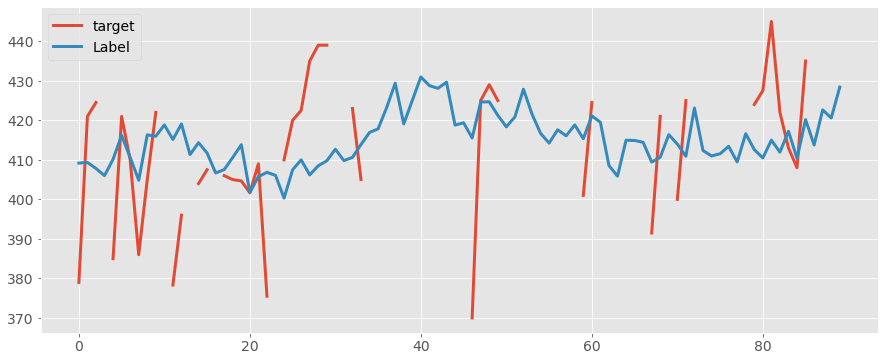

In [132]:
df_test15[df_test15['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

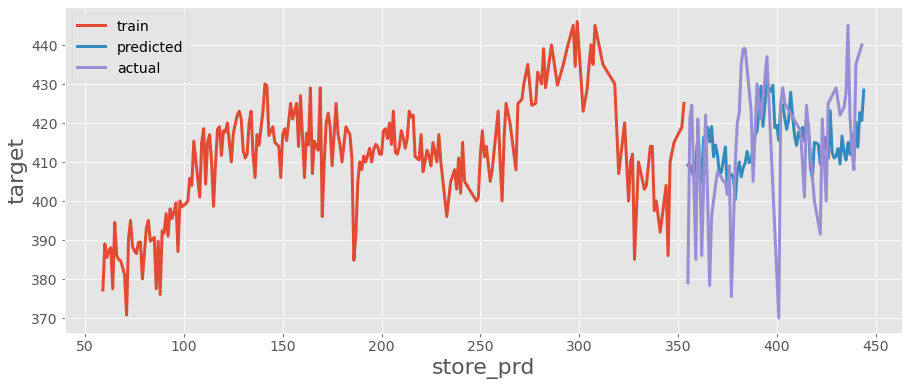

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win15[train_win15['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 30-Day Prediction

##### Load Train and Test Data

In [134]:
train_win60 = df_cal[(df_cal['lb60_plus30'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb60', 'lb60_plus30']]
train_win60['label'] = train_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
train_win60['target'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win60['store_frd'] = train_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win60['store_prd'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win60['feature'] = train_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in train_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(train_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(train_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(train_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(train_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(train_win60['feature'].to_list(), axis=0)

train_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(train_win60.shape, train_win60.columns)
train_win60.head(5)

(228, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             

shoe_size_10  target  store_frd  store_prd           1       2       3  \
0             1   422.0       37.0      127.0  380.833333  374.00  368.40   
0             1   423.0       38.0      128.0  374.000000  368.40  364.75   
0             1   421.0       39.0      129.0  368.400000  364.75  376.25   
0             1   413.0       40.0      130.0  364.750000  376.25  375.75   
0             1   411.0       41.0      131.0  376.250000  375.75  375.50   

        4       5           6  ...          51          52          53  \
0  364.75  376.25  375.750000  ...  389.666667  376.000000  392.333333   
0  376.25  375.75  375.500000  ...  376.000000  392.333333  391.750000   
0  375.75  375.50  371.750000  ...  392.333333  391.750000  396.750000   
0  375.50  371.75  385.000000  ...  391.750000  396.750000  391.000000   
0  371.75  385.00  378.333333  ...  396.750000  391.000000  398.000000   

       54      55     56     57     58     59     60  
0  391.75  396.75  391.0  398.0  395.5  397.2  399.5  
0  396.75  391.00  398.0  395.5  397.2  399.5  387.0  
0  391.00  398.00  395.5  397.2  399.5  387.0  400.0  
0  398.00  395.50  397.2  399.5  387.0  400.0  398.5  
0  395.50  397.20  399.5  387.0  400.0  398.5    NaN  

[5 rows x 64 columns]

In [135]:
test_win60 = df_cal[(df_cal['lb60_plus30'] >= CUTOFF_TRAINVAL) & (df_cal['lb60_plus30'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb60', 'lb60_plus30']]
test_win60['label'] = test_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
test_win60['target'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win60['store_frd'] = test_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win60['store_prd'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win60['feature'] = test_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in test_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(test_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(test_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(test_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(test_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(test_win60['feature'].to_list(), axis=0)

test_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(test_win60.shape, test_win60.columns)
test_win60.head(5)

(90, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             5

shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0             1   379.0      265.0      355.0  420.0    NaN    NaN  408.0   
0             1   421.0      266.0      356.0    NaN    NaN  408.0  425.0   
0             1   424.5      267.0      357.0    NaN  408.0  425.0    NaN   
0             1     NaN      268.0      358.0  408.0  425.0    NaN  426.0   
0             1   385.0      269.0      359.0  425.0    NaN  426.0  430.0   

       5      6  ...     51     52     53     54     55     56     57     58  \
0  425.0    NaN  ...    NaN    NaN    NaN  430.0    NaN  407.0    NaN    NaN   
0    NaN  426.0  ...    NaN    NaN  430.0    NaN  407.0    NaN    NaN  420.0   
0  426.0  430.0  ...    NaN  430.0    NaN  407.0    NaN    NaN  420.0    NaN   
0  430.0    NaN  ...  430.0    NaN  407.0    NaN    NaN  420.0    NaN  400.0   
0    NaN  435.0  ...    NaN  407.0    NaN    NaN  420.0    NaN  400.0  410.0   

      59     60  
0  420.0    NaN  
0    NaN  400.0  
0  400.0  410.0  
0  410.0  412.0  
0  412.0  385.0  

[5 rows x 64 columns]

In [136]:
ret = py60.setup(data=train_win60, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [137]:
py60.compare_models(sort='R2')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

In [138]:
py60.compare_models(sort='RMSE')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

##### CatBoost - MAE 6.6469, RMSE 8.4495, R2 0.4780

In [139]:
catb60 = py60.create_model('catboost')

In [140]:
tuned_catb60 = py60.tune_model(catb60, optimize='RMSE', choose_better=True)

In [141]:
df_val60 = py60.predict_model(catb60)

Model     MAE       MSE     RMSE      R2   RMSLE    MAPE
0  CatBoost Regressor  8.5433  115.1789  10.7321  0.1406  0.0258  0.0206

In [142]:
df_test60 = py60.predict_model(catb60, data=test_win60)
df_test60

shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0              1   379.0      265.0      355.0  420.0    NaN    NaN  408.0   
1              1   421.0      266.0      356.0    NaN    NaN  408.0  425.0   
2              1   424.5      267.0      357.0    NaN  408.0  425.0    NaN   
3              1     NaN      268.0      358.0  408.0  425.0    NaN  426.0   
4              1   385.0      269.0      359.0  425.0    NaN  426.0  430.0   
..           ...     ...        ...        ...    ...    ...    ...    ...   
85             1   435.0      350.0      440.0    NaN    NaN  419.0  425.0   
86             1     NaN      351.0      441.0    NaN  419.0  425.0    NaN   
87             1     NaN      352.0      442.0  419.0  425.0    NaN  379.0   
88             1   440.0      353.0      443.0  425.0    NaN  379.0  421.0   
89             1     NaN      354.0      444.0    NaN  379.0  421.0  424.5   

        5      6  ...     52     53     54     55     56     57     58     59  \
0   425.0    NaN  ...    NaN    NaN  430.0    NaN  407.0    NaN    NaN  420.0   
1     NaN  426.0  ...    NaN  430.0    NaN  407.0    NaN    NaN  420.0    NaN   
2   426.0  430.0  ...  430.0    NaN  407.0    NaN    NaN  420.0    NaN  400.0   
3   430.0    NaN  ...    NaN  407.0    NaN    NaN  420.0    NaN  400.0  410.0   
4     NaN  435.0  ...  407.0    NaN    NaN  420.0    NaN  400.0  410.0  412.0   
..    ...    ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
85    NaN  379.0  ...  370.0  425.0  429.0  425.0    NaN    NaN    NaN    NaN   
86  379.0  421.0  ...  425.0  429.0  425.0    NaN    NaN    NaN    NaN    NaN   
87  421.0  424.5  ...  429.0  425.0    NaN    NaN    NaN    NaN    NaN    NaN   
88  424.5    NaN  ...  425.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
89    NaN  385.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN  418.0   

       60     Label  
0     NaN  412.0289  
1   400.0  411.8679  
2   410.0  408.5708  
3   412.0  410.5487  
4   385.0  411.1697  
..    ...       ...  
85    NaN  414.6465  
86    NaN  414.4148  
87    NaN  414.9042  
88  418.0  413.3817  
89    NaN  415.8931  

[90 rows x 65 columns]

##### CatBoost - Prediction MAE 13.3504

In [143]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

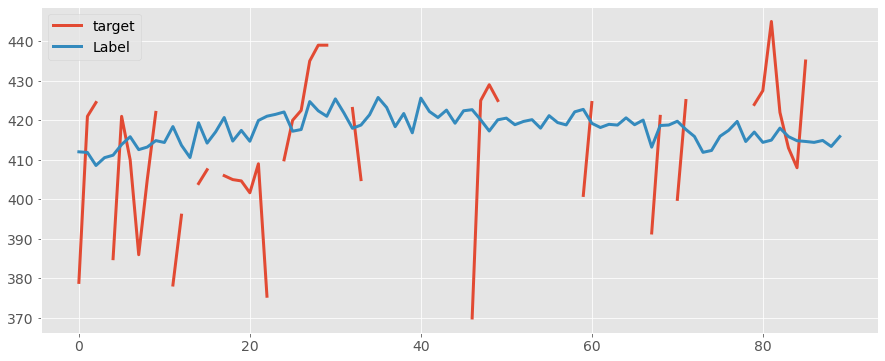

In [144]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

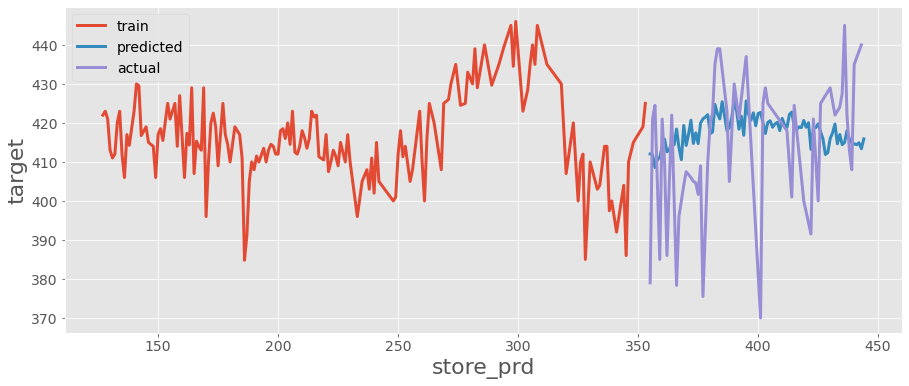

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

##### Extra Trees - MAE 6.8542,  RMSE 8.7397, R2 0.4416

In [146]:
et60 = py60.create_model('et')

In [147]:
tuned_et60 = py60.tune_model(et60, optimize='RMSE', choose_better=True)

In [148]:
df_val60 = py60.predict_model(et60)

Model     MAE       MSE     RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  8.0854  109.9505  10.4857  0.1796  0.0252  0.0195

In [149]:
df_test60 = py60.predict_model(et60, data=test_win60)
df_test60

shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0              1   379.0      265.0      355.0  420.0    NaN    NaN  408.0   
1              1   421.0      266.0      356.0    NaN    NaN  408.0  425.0   
2              1   424.5      267.0      357.0    NaN  408.0  425.0    NaN   
3              1     NaN      268.0      358.0  408.0  425.0    NaN  426.0   
4              1   385.0      269.0      359.0  425.0    NaN  426.0  430.0   
..           ...     ...        ...        ...    ...    ...    ...    ...   
85             1   435.0      350.0      440.0    NaN    NaN  419.0  425.0   
86             1     NaN      351.0      441.0    NaN  419.0  425.0    NaN   
87             1     NaN      352.0      442.0  419.0  425.0    NaN  379.0   
88             1   440.0      353.0      443.0  425.0    NaN  379.0  421.0   
89             1     NaN      354.0      444.0    NaN  379.0  421.0  424.5   

        5      6  ...     52     53     54     55     56     57     58     59  \
0   425.0    NaN  ...    NaN    NaN  430.0    NaN  407.0    NaN    NaN  420.0   
1     NaN  426.0  ...    NaN  430.0    NaN  407.0    NaN    NaN  420.0    NaN   
2   426.0  430.0  ...  430.0    NaN  407.0    NaN    NaN  420.0    NaN  400.0   
3   430.0    NaN  ...    NaN  407.0    NaN    NaN  420.0    NaN  400.0  410.0   
4     NaN  435.0  ...  407.0    NaN    NaN  420.0    NaN  400.0  410.0  412.0   
..    ...    ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
85    NaN  379.0  ...  370.0  425.0  429.0  425.0    NaN    NaN    NaN    NaN   
86  379.0  421.0  ...  425.0  429.0  425.0    NaN    NaN    NaN    NaN    NaN   
87  421.0  424.5  ...  429.0  425.0    NaN    NaN    NaN    NaN    NaN    NaN   
88  424.5    NaN  ...  425.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
89    NaN  385.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN  418.0   

       60     Label  
0     NaN  412.0455  
1   400.0  406.4428  
2   410.0  406.8722  
3   412.0  408.5207  
4   385.0  412.2983  
..    ...       ...  
85    NaN  412.6592  
86    NaN  412.3135  
87    NaN  410.6330  
88  418.0  413.3488  
89    NaN  413.1503  

[90 rows x 65 columns]

##### Extra Trees - Prediction MAE 13.0608

In [150]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

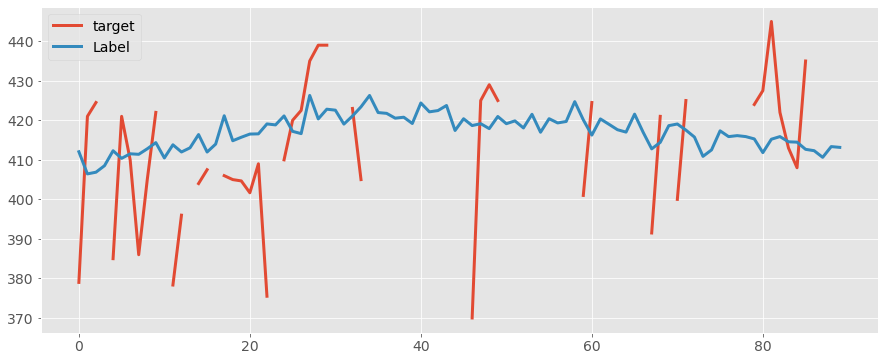

In [151]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

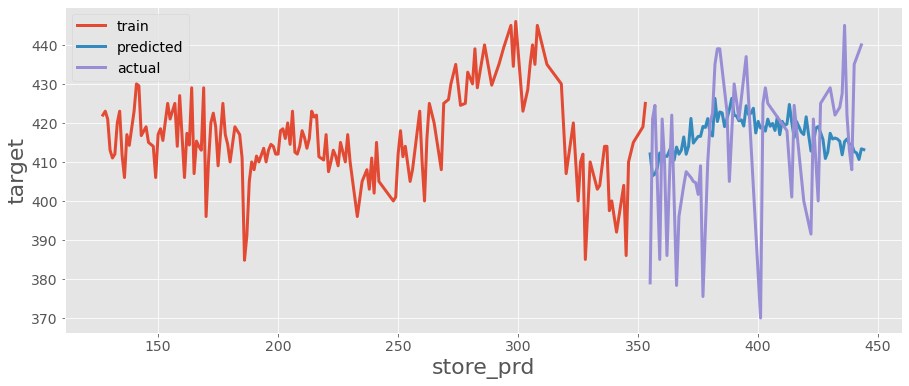

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 90-Day Prediction

##### Load Train and Test Data

In [153]:
train_win180 = df_cal[(df_cal['lb180_plus90'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb180', 'lb180_plus90']]
train_win180['label'] = train_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
train_win180['target'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win180['store_frd'] = train_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win180['store_prd'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win180['feature'] = train_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in train_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(train_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(train_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(train_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(train_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(train_win180['feature'].to_list(), axis=0)

train_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(train_win180.shape, train_win180.columns)
train_win180.head(5)


(48, 184) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,
       ...
                  171,            172,            173,            174,
                  175,            176,            177,            178,
                  179,            180],
      dtype='object', length=184)


shoe_size_10  target  store_frd  store_prd           1       2       3  \
0             1   435.0       37.0      307.0  380.833333  374.00  368.40   
0             1   445.0       38.0      308.0  374.000000  368.40  364.75   
0             1     NaN       39.0      309.0  368.400000  364.75  376.25   
0             1     NaN       40.0      310.0  364.750000  376.25  375.75   
0             1     NaN       41.0      311.0  376.250000  375.75  375.50   

        4       5           6  ...     171     172     173     174     175  \
0  364.75  376.25  375.750000  ...  412.50  412.00  414.00  418.00  416.25   
0  376.25  375.75  375.500000  ...  412.00  414.00  418.00  416.25  413.50   
0  375.75  375.50  371.750000  ...  414.00  418.00  416.25  413.50  416.00   
0  375.50  371.75  385.000000  ...  418.00  416.25  413.50  416.00  423.00   
0  371.75  385.00  378.333333  ...  416.25  413.50  416.00  423.00  421.50   

     176         177         178         179         180  
0  413.5  416.000000  423.000000  421.500000  422.000000  
0  416.0  423.000000  421.500000  422.000000  411.333333  
0  423.0  421.500000  422.000000  411.333333         NaN  
0  421.5  422.000000  411.333333         NaN  410.500000  
0  422.0  411.333333         NaN  410.500000  417.000000  

[5 rows x 184 columns]

In [154]:
test_win180 = df_cal[(df_cal['lb180_plus90'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb180_plus90'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb180', 'lb180_plus90']]
test_win180['label'] = test_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
test_win180['target'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win180['store_frd'] = test_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win180['store_prd'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win180['feature'] = test_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in test_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(test_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(test_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(test_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(test_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(test_win180['feature'].to_list(), axis=0)

test_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(test_win180.shape, test_win180.columns)
test_win180.head(5)


(90, 184) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,
       ...
                  171,            172,            173,            174,
                  175,            176,            177,            178,
                  179,            180],
      dtype='object', length=184)


shoe_size_10  target  store_frd  store_prd           1           2  \
0             1   379.0       85.0      355.0  390.666667  377.500000   
0             1   421.0       86.0      356.0  377.500000  389.666667   
0             1   424.5       87.0      357.0  389.666667  376.000000   
0             1     NaN       88.0      358.0  376.000000  392.333333   
0             1   385.0       89.0      359.0  392.333333  391.750000   

            3           4           5       6  ...    171    172    173  \
0  389.666667  376.000000  392.333333  391.75  ...  405.0  408.0    NaN   
0  376.000000  392.333333  391.750000  396.75  ...  408.0    NaN    NaN   
0  392.333333  391.750000  396.750000  391.00  ...    NaN    NaN  423.0   
0  391.750000  396.750000  391.000000  398.00  ...    NaN  423.0  410.0   
0  396.750000  391.000000  398.000000  395.50  ...  423.0  410.0  400.0   

     174    175    176    177    178    179    180  
0    NaN  423.0  410.0  400.0  416.0  425.0    NaN  
0  423.0  410.0  400.0  416.0  425.0    NaN  420.0  
0  410.0  400.0  416.0  425.0    NaN  420.0    NaN  
0  400.0  416.0  425.0    NaN  420.0    NaN    NaN  
0  416.0  425.0    NaN  420.0    NaN    NaN  408.0  

[5 rows x 184 columns]

In [155]:
ret = py180.setup(data=train_win180, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [156]:
py180.compare_models(sort='R2')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [157]:
py180.compare_models(sort='RMSE')

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123)

##### Elastic Net - MAE 6.5723, RMSE 8.1809, R2 0.4865

In [158]:
en180 = py180.create_model('en')

In [159]:
tuned_en180 = py180.tune_model(en180, optimize='RMSE', choose_better=True)

In [160]:
df_val180 = py180.predict_model(en180)

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE
0  Elastic Net  6.8602  47.6832  6.9053  0.2426  0.0169  0.0167

In [161]:
df_test180 = py180.predict_model(en180, data=test_win180)
df_test180

shoe_size_10  target  store_frd  store_prd           1           2  \
0              1   379.0       85.0      355.0  390.666667  377.500000   
1              1   421.0       86.0      356.0  377.500000  389.666667   
2              1   424.5       87.0      357.0  389.666667  376.000000   
3              1     NaN       88.0      358.0  376.000000  392.333333   
4              1   385.0       89.0      359.0  392.333333  391.750000   
..           ...     ...        ...        ...         ...         ...   
85             1   435.0      170.0      440.0  396.000000  410.000000   
86             1     NaN      171.0      441.0  410.000000  420.000000   
87             1     NaN      172.0      442.0  420.000000  422.500000   
88             1   440.0      173.0      443.0  422.500000  419.000000   
89             1     NaN      174.0      444.0  419.000000  409.000000   

             3           4           5       6  ...    172    173    174  \
0   389.666667  376.000000  392.333333  391.75  ...  408.0    NaN    NaN   
1   376.000000  392.333333  391.750000  396.75  ...    NaN    NaN  423.0   
2   392.333333  391.750000  396.750000  391.00  ...    NaN  423.0  410.0   
3   391.750000  396.750000  391.000000  398.00  ...  423.0  410.0  400.0   
4   396.750000  391.000000  398.000000  395.50  ...  410.0  400.0  416.0   
..         ...         ...         ...     ...  ...    ...    ...    ...   
85  420.000000  422.500000  419.000000  409.00  ...  392.0    NaN    NaN   
86  422.500000  419.000000  409.000000     NaN  ...    NaN    NaN  404.0   
87  419.000000  409.000000         NaN  425.00  ...    NaN  404.0  386.0   
88  409.000000         NaN  425.000000  417.00  ...  404.0  386.0  410.0   
89         NaN  425.000000  417.000000  414.50  ...  386.0  410.0    NaN   

      175    176    177    178    179    180     Label  
0   423.0  410.0  400.0  416.0  425.0    NaN  406.0872  
1   410.0  400.0  416.0  425.0    NaN  420.0  415.8929  
2   400.0  416.0  425.0    NaN  420.0    NaN  403.4790  
3   416.0  425.0    NaN  420.0    NaN    NaN  412.8067  
4   425.0    NaN  420.0    NaN    NaN  408.0  409.0269  
..    ...    ...    ...    ...    ...    ...       ...  
85  404.0  386.0  410.0    NaN  415.0    NaN  422.5362  
86  386.0  410.0    NaN  415.0    NaN    NaN  442.8435  
87  410.0    NaN  415.0    NaN    NaN    NaN  422.7718  
88    NaN  415.0    NaN    NaN    NaN  419.0  413.5235  
89  415.0    NaN    NaN    NaN  419.0  425.0  421.3051  

[90 rows x 185 columns]

##### Elastic Net - Predict MAE 14.9353

In [162]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

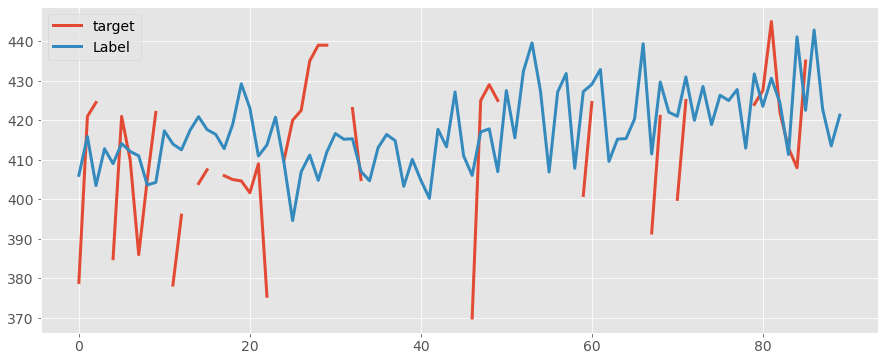

In [163]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

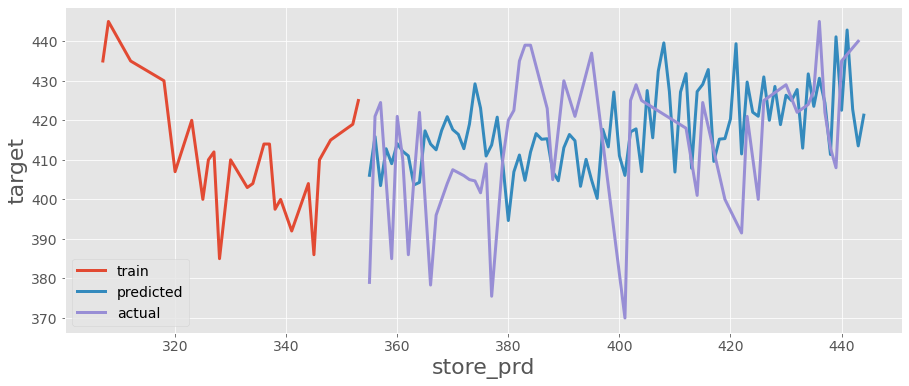

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

##### Extra Trees - MAE 8.4127, RMSE 9.8022, R2 0.3291

In [165]:
et180 = py180.create_model('et')

In [166]:
tuned_et180 = py180.tune_model(et180, optimize='RMSE', choose_better=True)

In [167]:
df_val180 = py180.predict_model(et180)

Model   MAE      MSE    RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  6.92  69.5521  8.3398 -0.1047  0.0203  0.0168

In [168]:
df_test180 = py180.predict_model(et180, data=test_win180)
df_test180

shoe_size_10  target  store_frd  store_prd           1           2  \
0              1   379.0       85.0      355.0  390.666667  377.500000   
1              1   421.0       86.0      356.0  377.500000  389.666667   
2              1   424.5       87.0      357.0  389.666667  376.000000   
3              1     NaN       88.0      358.0  376.000000  392.333333   
4              1   385.0       89.0      359.0  392.333333  391.750000   
..           ...     ...        ...        ...         ...         ...   
85             1   435.0      170.0      440.0  396.000000  410.000000   
86             1     NaN      171.0      441.0  410.000000  420.000000   
87             1     NaN      172.0      442.0  420.000000  422.500000   
88             1   440.0      173.0      443.0  422.500000  419.000000   
89             1     NaN      174.0      444.0  419.000000  409.000000   

             3           4           5       6  ...    172    173    174  \
0   389.666667  376.000000  392.333333  391.75  ...  408.0    NaN    NaN   
1   376.000000  392.333333  391.750000  396.75  ...    NaN    NaN  423.0   
2   392.333333  391.750000  396.750000  391.00  ...    NaN  423.0  410.0   
3   391.750000  396.750000  391.000000  398.00  ...  423.0  410.0  400.0   
4   396.750000  391.000000  398.000000  395.50  ...  410.0  400.0  416.0   
..         ...         ...         ...     ...  ...    ...    ...    ...   
85  420.000000  422.500000  419.000000  409.00  ...  392.0    NaN    NaN   
86  422.500000  419.000000  409.000000     NaN  ...    NaN    NaN  404.0   
87  419.000000  409.000000         NaN  425.00  ...    NaN  404.0  386.0   
88  409.000000         NaN  425.000000  417.00  ...  404.0  386.0  410.0   
89         NaN  425.000000  417.000000  414.50  ...  386.0  410.0    NaN   

      175    176    177    178    179    180   Label  
0   423.0  410.0  400.0  416.0  425.0    NaN  407.49  
1   410.0  400.0  416.0  425.0    NaN  420.0  405.38  
2   400.0  416.0  425.0    NaN  420.0    NaN  410.62  
3   416.0  425.0    NaN  420.0    NaN    NaN  403.72  
4   425.0    NaN  420.0    NaN    NaN  408.0  407.24  
..    ...    ...    ...    ...    ...    ...     ...  
85  404.0  386.0  410.0    NaN  415.0    NaN  403.28  
86  386.0  410.0    NaN  415.0    NaN    NaN  402.27  
87  410.0    NaN  415.0    NaN    NaN    NaN  408.27  
88    NaN  415.0    NaN    NaN    NaN  419.0  409.25  
89  415.0    NaN    NaN    NaN  419.0  425.0  412.09  

[90 rows x 185 columns]

##### Extra Trees - Prediction MAE 16.574

In [169]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

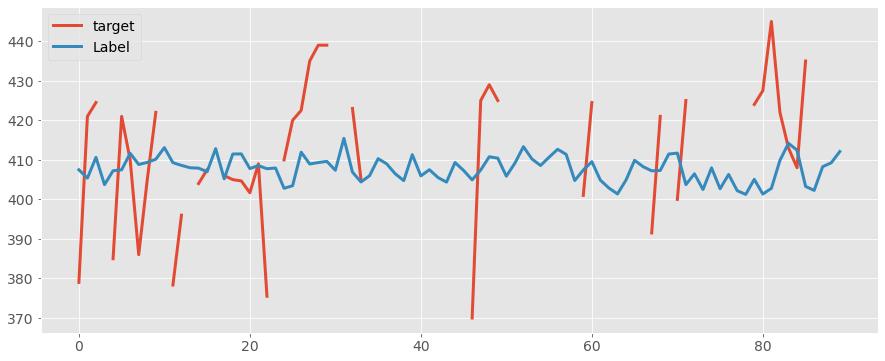

In [170]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

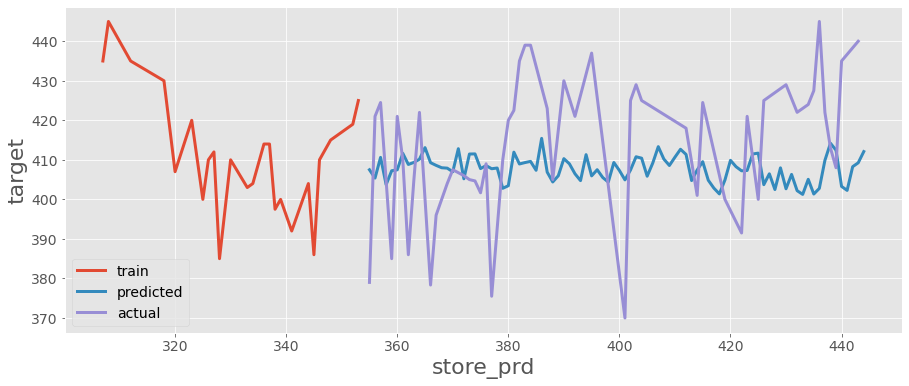

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

## Off-White - Air-Jordan-1-Retro-High-Off-White-University-Blue

Sneaker Name is 'Off-White - Air-Jordan-1-Retro-High-Off-White-University-Blue'
    - Didn't know reason for more than 1 month gap between end of trainin data and start of hidden test data.
        - Decided to retain Nov 15, 2018 cutoff used in Yeezy regressions
    - Best R2 is 0.7193 with 60-day lookbehind and 30-day lookahead
    - Extra Trees best for both 7-day and 30-day prediction
    - 90-Day prediction not possible, not enough data points for 180-day lookbehind


### Data Processing and EDA

In [172]:
plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['axes.prop_cycle'] = color=['#CF353C', 'FFE3A6', '#727272']

In [173]:
CUTOFF_TRAINMIN = '2018-06-01'
CUTOFF_TRAINVAL = '2018-11-15'
#yeezy Jan 1, 2018
#john jun 1, 2018

df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Sneaker Name'] = df['Brand'] + ' - ' + df['Sneaker Name']
df['DaysStored'] = pd.Series(df['Order Date'] - df['Release Date']).apply(lambda x: x.days)
df = df[['Order Date', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
df

Order Date                                       Sneaker Name  \
0     2017-09-01       Yeezy - Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
2     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
3     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
...          ...                                                ...   
99951 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99952 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99953 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99954 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99955 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   

       Shoe Size  Sale Price  DaysStored  
0           11.0      1097.0         342  
1           11.0       685.0         282  
2           11.0       690.0         282  
3           11.5      1075.0         282  
4           11.0       828.0         202  
...          ...         ...         ...  
99951        8.0       565.0          49  
99952        8.5       598.0          49  
99953        5.5       605.0          49  
99954       11.0       650.0          49  
99955       11.5       640.0          49  

[99956 rows x 5 columns]

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Sneaker Name  99956 non-null  object        
 2   Shoe Size     99956 non-null  float64       
 3   Sale Price    99956 non-null  float64       
 4   DaysStored    99956 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.8+ MB


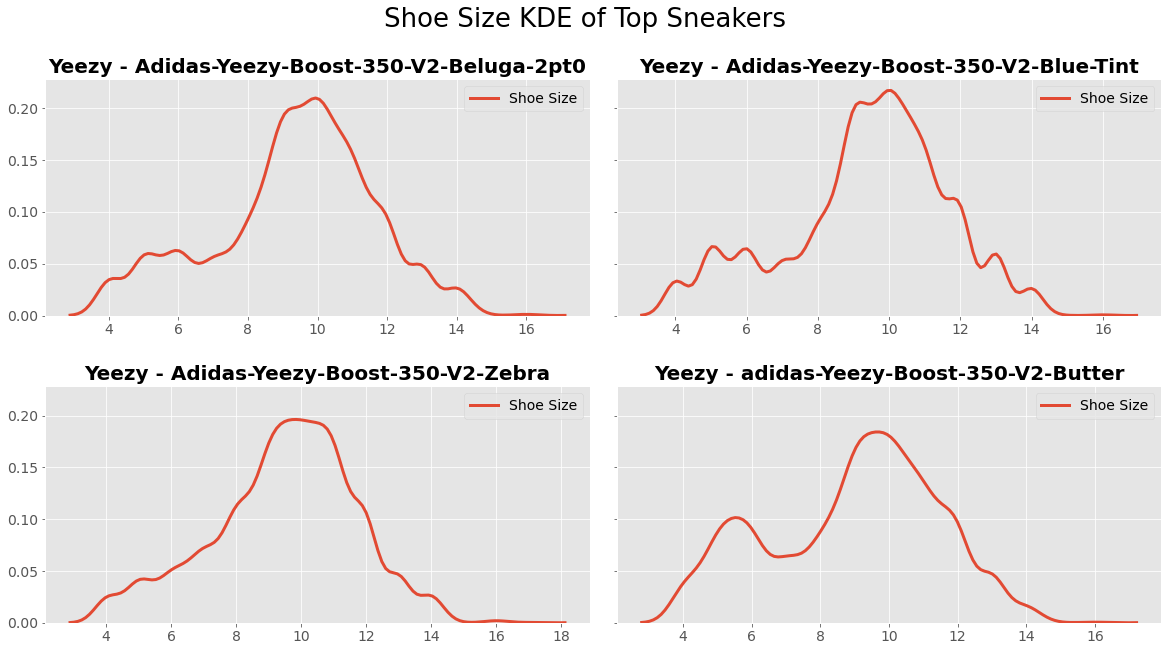

In [175]:
top_sneakers = df.groupby(['Sneaker Name', 'Shoe Size']).size().reset_index().nlargest(9, 0)['Sneaker Name'].to_list()
top_sneakers = sorted(list(set(top_sneakers)))

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharey = True)
fig.subplots_adjust(hspace=0.3, wspace=0.05)
fig.suptitle('Shoe Size KDE of Top Sneakers')

x, y = 0, 0
for i in range(0, len(top_sneakers)):
    x, y = int(i/2), i % 2
    sns.kdeplot(data=df[df['Sneaker Name']==top_sneakers[i]]['Shoe Size'], ax=ax[x][y])
    ax[x][y].set_title(top_sneakers[i].strip(), fontsize=20)

### Filter to single Sneaker Name

In [176]:
top_sneakers

[' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Zebra',
 ' Yeezy - adidas-Yeezy-Boost-350-V2-Butter']

In [177]:
sneaker_name = 'Off-White - Air-Jordan-1-Retro-High-Off-White-University-Blue'

df_agg = df[(df['Sneaker Name']==sneaker_name) & \
            (df['Shoe Size'].isin([10]))].copy()
df_agg = df_agg.groupby(['Order Date', 'Sneaker Name', 'Shoe Size']).mean().reset_index()
df_agg

Order Date                                       Sneaker Name  Shoe Size  \
0   2018-05-23  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
1   2018-05-24  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
2   2018-05-25  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
3   2018-05-26  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
4   2018-05-27  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
..         ...                                                ...        ...   
158 2019-02-07  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
159 2019-02-08  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
160 2019-02-10  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
161 2019-02-11  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
162 2019-02-13  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   

      Sale Price  DaysStored  
0    1480.800000         -31  
1    1317.222222         -30  
2    1191.176471         -29  
3    1071.666667         -28  
4    1009.571429         -27  
..           ...         ...  
158   941.333333         229  
159   935.000000         230  
160   970.000000         232  
161   955.000000         233  
162  1010.000000         235  

[163 rows x 5 columns]

In [178]:
#start_dt = df_agg['Order Date'].min()
start_dt = datetime.strptime(CUTOFF_TRAINMIN, '%Y-%m-%d')
end_dt = df_agg['Order Date'].max()

df_cal = pd.DataFrame({'dt': pd.date_range(start_dt, end_dt)})
df_cal['dt_str'] = df_cal['dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_cal['lst_lb15'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(15 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb30'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(30 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb60'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(60 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb180'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(180 - 1)).strftime('%Y-%m-%d').to_list())

df_cal['lb15_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(15 - 1)).strftime('%Y-%m-%d'))
df_cal['lb30_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(30 - 1)).strftime('%Y-%m-%d'))
df_cal['lb60_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(60 - 1)).strftime('%Y-%m-%d'))
df_cal['lb180_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(180 - 1)).strftime('%Y-%m-%d'))

df_cal['lb15_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(22)).strftime('%Y-%m-%d'))
df_cal['lb30_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(37)).strftime('%Y-%m-%d'))
df_cal['lb60_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(67)).strftime('%Y-%m-%d'))

df_cal['lb60_plus30'] = df_cal['dt'].apply(lambda x: (x + timedelta(90)).strftime('%Y-%m-%d'))
df_cal['lb180_plus90'] = df_cal['dt'].apply(lambda x: (x + timedelta(270)).strftime('%Y-%m-%d'))


print(df_cal.shape, df_cal.columns)
df_cal.head(5)

(258, 15) Index(['dt', 'dt_str', 'lst_lb15', 'lst_lb30', 'lst_lb60', 'lst_lb180',
       'lb15_last', 'lb30_last', 'lb60_last', 'lb180_last', 'lb15_plus7',
       'lb30_plus7', 'lb60_plus7', 'lb60_plus30', 'lb180_plus90'],
      dtype='object')


dt      dt_str                                           lst_lb15  \
0 2018-06-01  2018-06-01  [2018-06-01, 2018-06-02, 2018-06-03, 2018-06-0...   
1 2018-06-02  2018-06-02  [2018-06-02, 2018-06-03, 2018-06-04, 2018-06-0...   
2 2018-06-03  2018-06-03  [2018-06-03, 2018-06-04, 2018-06-05, 2018-06-0...   
3 2018-06-04  2018-06-04  [2018-06-04, 2018-06-05, 2018-06-06, 2018-06-0...   
4 2018-06-05  2018-06-05  [2018-06-05, 2018-06-06, 2018-06-07, 2018-06-0...   

                                            lst_lb30  \
0  [2018-06-01, 2018-06-02, 2018-06-03, 2018-06-0...   
1  [2018-06-02, 2018-06-03, 2018-06-04, 2018-06-0...   
2  [2018-06-03, 2018-06-04, 2018-06-05, 2018-06-0...   
3  [2018-06-04, 2018-06-05, 2018-06-06, 2018-06-0...   
4  [2018-06-05, 2018-06-06, 2018-06-07, 2018-06-0...   

                                            lst_lb60  \
0  [2018-06-01, 2018-06-02, 2018-06-03, 2018-06-0...   
1  [2018-06-02, 2018-06-03, 2018-06-04, 2018-06-0...   
2  [2018-06-03, 2018-06-04, 2018-06-05, 2018-06-0...   
3  [2018-06-04, 2018-06-05, 2018-06-06, 2018-06-0...   
4  [2018-06-05, 2018-06-06, 2018-06-07, 2018-06-0...   

                                           lst_lb180   lb15_last   lb30_last  \
0  [2018-06-01, 2018-06-02, 2018-06-03, 2018-06-0...  2018-06-15  2018-06-30   
1  [2018-06-02, 2018-06-03, 2018-06-04, 2018-06-0...  2018-06-16  2018-07-01   
2  [2018-06-03, 2018-06-04, 2018-06-05, 2018-06-0...  2018-06-17  2018-07-02   
3  [2018-06-04, 2018-06-05, 2018-06-06, 2018-06-0...  2018-06-18  2018-07-03   
4  [2018-06-05, 2018-06-06, 2018-06-07, 2018-06-0...  2018-06-19  2018-07-04   

    lb60_last  lb180_last  lb15_plus7  lb30_plus7  lb60_plus7 lb60_plus30  \
0  2018-07-30  2018-11-27  2018-06-23  2018-07-08  2018-08-07  2018-08-30   
1  2018-07-31  2018-11-28  2018-06-24  2018-07-09  2018-08-08  2018-08-31   
2  2018-08-01  2018-11-29  2018-06-25  2018-07-10  2018-08-09  2018-09-01   
3  2018-08-02  2018-11-30  2018-06-26  2018-07-11  2018-08-10  2018-09-02   
4  2018-08-03  2018-12-01  2018-06-27  2018-07-12  2018-08-11  2018-09-03   

  lb180_plus90  
0   2019-02-26  
1   2019-02-27  
2   2019-02-28  
3   2019-03-01  
4   2019-03-02

In [179]:
df_tmp = df_cal[['dt', 'dt_str']].copy()
df_tmp['key'] = 0
print('df_tmp.shape', df_tmp.shape)

df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Sneaker Name': [sneaker_name]}), how='outer')
df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Shoe Size': [10]}), how='outer')
df_tmp = df_tmp.merge(df_agg, how='left', left_on=['dt', 'Sneaker Name', 'Shoe Size'], right_on=['Order Date', 'Sneaker Name', 'Shoe Size'])
df_tmp = df_tmp[['dt_str', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
print('df_tmp.shape', df_tmp.shape)
df_tmp.head(5)

df_tmp.shape (258, 3)
df_tmp.shape (258, 5)


dt_str                                       Sneaker Name  Shoe Size  \
0  2018-06-01  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   
1  2018-06-02  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   
2  2018-06-03  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   
3  2018-06-04  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   
4  2018-06-05  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   

   Sale Price  DaysStored  
0  916.666667       -22.0  
1  908.250000       -21.0  
2  891.750000       -20.0  
3  895.000000       -19.0  
4  890.250000       -18.0

In [180]:
pvt_price = df_tmp[['dt_str', 'Shoe Size', 'Sale Price']].copy()
pvt_price = pvt_price.pivot(index='Shoe Size', columns='dt_str', values='Sale Price')
pvt_price = pvt_price.interpolate(method='pad', axis=0, limit_direction='forward')
print('pvt_price.shape', pvt_price.shape)

pvt_price_diff = pvt_price.diff(axis=1)
pvt_price_diff = pvt_price_diff.reset_index()
pvt_price = pvt_price.reset_index()
print(pvt_price['Shoe Size'])

pvt_store = df_tmp[['dt_str', 'Shoe Size', 'DaysStored']].copy()
pvt_store = pvt_store.pivot(index='Shoe Size', columns='dt_str', values='DaysStored')
pvt_store = pvt_store.interpolate(method='linear', axis=0, limit_direction='both')
pvt_store = pvt_store.interpolate(method='linear', axis=1, limit_direction='both')  # fill remaining nulls
print('pvt_store.shape', pvt_store.shape)
pvt_store = pvt_store.reset_index()
print(pvt_store['Shoe Size'])

pvt_price.shape (1, 258)
0    10
Name: Shoe Size, dtype: int64
pvt_store.shape (1, 258)
0    10
Name: Shoe Size, dtype: int64


In [181]:
pvt_price

dt_str  Shoe Size  2018-06-01  2018-06-02  2018-06-03  2018-06-04  2018-06-05  \
0              10  916.666667      908.25      891.75       895.0      890.25   

dt_str  2018-06-06  2018-06-07  2018-06-08  2018-06-09  ...  2019-02-04  \
0            895.0       873.4       850.0       898.5  ...       986.0   

dt_str  2019-02-05  2019-02-06  2019-02-07  2019-02-08  2019-02-09  \
0              NaN       937.0  941.333333       935.0         NaN   

dt_str  2019-02-10  2019-02-11  2019-02-12  2019-02-13  
0            970.0       955.0         NaN      1010.0  

[1 rows x 259 columns]

In [182]:
pvt_price_diff

dt_str  Shoe Size  2018-06-01  2018-06-02  2018-06-03  2018-06-04  2018-06-05  \
0              10         NaN   -8.416667       -16.5        3.25       -4.75   

dt_str  2018-06-06  2018-06-07  2018-06-08  2018-06-09  ...  2019-02-04  \
0             4.75       -21.6       -23.4        48.5  ...        -9.0   

dt_str  2019-02-05  2019-02-06  2019-02-07  2019-02-08  2019-02-09  \
0              NaN         NaN    4.333333   -6.333333         NaN   

dt_str  2019-02-10  2019-02-11  2019-02-12  2019-02-13  
0              NaN       -15.0         NaN         NaN  

[1 rows x 259 columns]

In [183]:
df_results = pd.DataFrame({'scenario': pd.Series([], dtype=str),
                           'model': pd.Series([], dtype=str),
                           'MAE': pd.Series([], dtype=np.half),
                           'MSE': pd.Series([], dtype=np.half),
                           'RMSE': pd.Series([], dtype=np.half),
                           'R2': pd.Series([], dtype=np.half),
                           'RMSLE': pd.Series([], dtype=np.half),
                           'MAPE': pd.Series([], dtype=np.half)})
df_results

Empty DataFrame
Columns: [scenario, model, MAE, MSE, RMSE, R2, RMSLE, MAPE]
Index: []

### Regression

In [184]:
import pycaret.regression as py15
import pycaret.regression as py60
import pycaret.regression as py180
from pycaret.utils import check_metric

#### Models List

In [185]:
py15.models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm                  Support Vector Machine   
knn                   K Neighbors Regressor   
dt                            Decision Tree   
rf                            Random Forest   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                  Multi Level Perceptron   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                           Reference  Turbo  
ID                                                           
lr             sklearn.linear_model.LinearRegression   True  
lasso                     sklearn.linear_model.Lasso   True  
ridge                     sklearn.linear_model.Ridge   True  
en                   sklearn.linear_model.ElasticNet   True  
lar                        sklearn.linear_model.Lars   True  
llar                  sklearn.linear_model.LassoLars   True  
omp                         sklearn.linear_model.OMP   True  
br                sklearn.linear_model.BayesianRidge   True  
ard               sklearn.linear_model.ARDRegression  False  
par                         sklearn.linear_model.PAR   True  
ransac          sklearn.linear_model.RANSACRegressor   True  
tr            sklearn.linear_model.TheilSenRegressor   True  
huber            sklearn.linear_model.HuberRegressor   True  
kr                  sklearn.kernel_ridge.KernelRidge  False  
svm                                  sklearn.svm.SVR   True  
knn            sklearn.neighbors.KNeighborsRegressor   True  
dt                sklearn.tree.DecisionTreeRegressor   True  
rf            sklearn.ensemble.RandomForestRegressor   True  
et              sklearn.ensemble.ExtraTreesRegressor   True  
ada               sklearn.ensemble.AdaBoostRegressor   True  
gbr       sklearn.ensemble.GradientBoostingRegressor   True  
mlp              sklearn.neural_network.MLPRegressor  False  
xgboost                       xgboost.readthedocs.io   True  
lightgbm               github.com/microsoft/LightGBM   True  
catboost                         https://catboost.ai   True

##### Price (As Is), Days Stored (First Order, Predict)

#### 7-Day Prediction

##### Load Train and Test Data

In [186]:
train_win15 = df_cal[(df_cal['lb15_plus7'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb15', 'lb15_plus7']]
train_win15['label'] = train_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
train_win15['target'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win15['store_frd'] = train_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win15['store_prd'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win15['feature'] = train_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in train_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(train_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(train_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(train_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(train_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(train_win15['feature'].to_list(), axis=0)

train_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(train_win15.shape, train_win15.columns)
train_win15.head(5)

(145, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10      target  store_frd  store_prd           1       2       3  \
0             1  834.714286      -22.0        0.0  916.666667  908.25  891.75   
0             1  880.250000      -21.0        1.0  908.250000  891.75  895.00   
0             1  888.000000      -20.0        2.0  891.750000  895.00  890.25   
0             1         NaN      -19.0        3.0  895.000000  890.25  895.00   
0             1  809.500000      -18.0        4.0  890.250000  895.00  873.40   

        4       5      6      7           8           9          10  \
0  895.00  890.25  895.0  873.4  850.000000  898.500000  879.500000   
0  890.25  895.00  873.4  850.0  898.500000  879.500000  895.000000   
0  895.00  873.40  850.0  898.5  879.500000  895.000000  835.666667   
0  873.40  850.00  898.5  879.5  895.000000  835.666667  801.000000   
0  850.00  898.50  879.5  895.0  835.666667  801.000000  835.000000   

           11          12          13          14          15  
0  895.000000  835.666667  801.000000  835.000000  809.363636  
0  835.666667  801.000000  835.000000  809.363636  781.000000  
0  801.000000  835.000000  809.363636  781.000000  750.400000  
0  835.000000  809.363636  781.000000  750.400000  708.466667  
0  809.363636  781.000000  750.400000  708.466667  694.357143

In [ ]:
test_win15 = df_cal[(df_cal['lb15_plus7'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb15_plus7'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb15', 'lb15_plus7']]
test_win15['label'] = test_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
test_win15['target'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win15['store_frd'] = test_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win15['store_prd'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win15['feature'] = test_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in test_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(test_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(test_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(test_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(test_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(test_win15['feature'].to_list(), axis=0)

test_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(test_win15.shape, test_win15.columns)
test_win15.head(5)

In [187]:
ret = py15.setup(data=train_win15, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [188]:
py15.compare_models(sort='R2')

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')

In [189]:
py15.compare_models(sort='RMSE')

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')

##### Extra Trees - MAE 25.5672, RMSE 37.9280, R2 0.6746

In [190]:
et15 = py15.create_model('et')

In [191]:
tuned_et15 = py15.tune_model(et15, optimize='RMSE', choose_better=True)

In [192]:
df_val15 = py15.predict_model(et15)

Model      MAE       MSE     RMSE      R2  RMSLE    MAPE
0  Extra Trees Regressor  24.5763  894.7465  29.9123  0.8052  0.034  0.0279

In [193]:
df_test15 = py15.predict_model(et15, data=test_win15)
df_test15

shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0              1   379.0      333.0      355.0  403.0  404.0    NaN  414.0   
1              1   421.0      334.0      356.0  404.0    NaN  414.0  414.0   
2              1   424.5      335.0      357.0    NaN  414.0  414.0  397.5   
3              1     NaN      336.0      358.0  414.0  414.0  397.5  400.0   
4              1   385.0      337.0      359.0  414.0  397.5  400.0    NaN   
..           ...     ...        ...        ...    ...    ...    ...    ...   
85             1   435.0      418.0      440.0    NaN  400.0    NaN    NaN   
86             1     NaN      419.0      441.0  400.0    NaN    NaN  391.5   
87             1     NaN      420.0      442.0    NaN    NaN  391.5  421.0   
88             1   440.0      421.0      443.0    NaN  391.5  421.0    NaN   
89             1     NaN      422.0      444.0  391.5  421.0    NaN  400.0   

        5      6      7      8      9     10        11        12        13  \
0   414.0  397.5  400.0    NaN  392.0    NaN       NaN  404.0000  386.0000   
1   397.5  400.0    NaN  392.0    NaN    NaN  404.0000  386.0000  410.0000   
2   400.0    NaN  392.0    NaN    NaN  404.0  386.0000  410.0000       NaN   
3     NaN  392.0    NaN    NaN  404.0  386.0  410.0000       NaN  415.0000   
4   392.0    NaN    NaN  404.0  386.0  410.0       NaN  415.0000       NaN   
..    ...    ...    ...    ...    ...    ...       ...       ...       ...   
85  391.5  421.0    NaN  400.0  425.0    NaN       NaN       NaN  429.0000   
86  421.0    NaN  400.0  425.0    NaN    NaN       NaN  429.0000       NaN   
87    NaN  400.0  425.0    NaN    NaN    NaN  429.0000       NaN  422.0149   
88  400.0  425.0    NaN    NaN    NaN  429.0       NaN  422.0149       NaN   
89  425.0    NaN    NaN    NaN  429.0    NaN  422.0149       NaN  424.0000   

          14        15     Label  
0   410.0000       NaN  832.9221  
1        NaN  415.0000  849.0254  
2   415.0000       NaN  839.7549  
3        NaN       NaN  832.8565  
4        NaN       NaN  825.7578  
..       ...       ...       ...  
85       NaN  422.0149  859.4628  
86  422.0149       NaN  876.6023  
87       NaN  424.0000  848.5926  
88  424.0000  427.5000  838.4673  
89  427.5000  445.0000  838.7914  

[90 rows x 20 columns]

##### Extra Trees - Prediction MAE 32.462

In [194]:
check_metric(df_test15.target, df_test15.Label, 'MAE')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

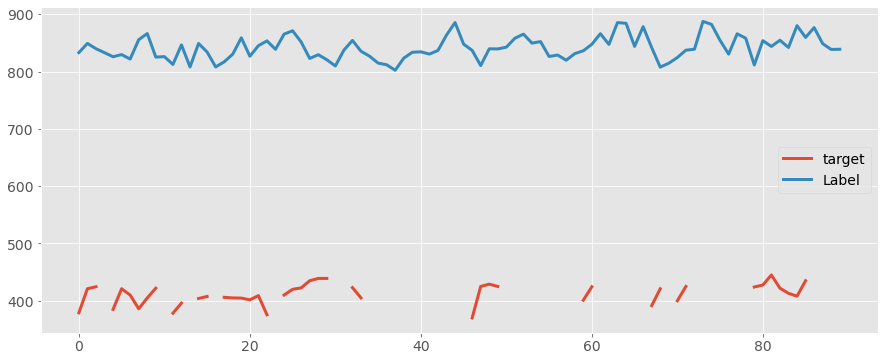

In [195]:
df_test15[df_test15['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

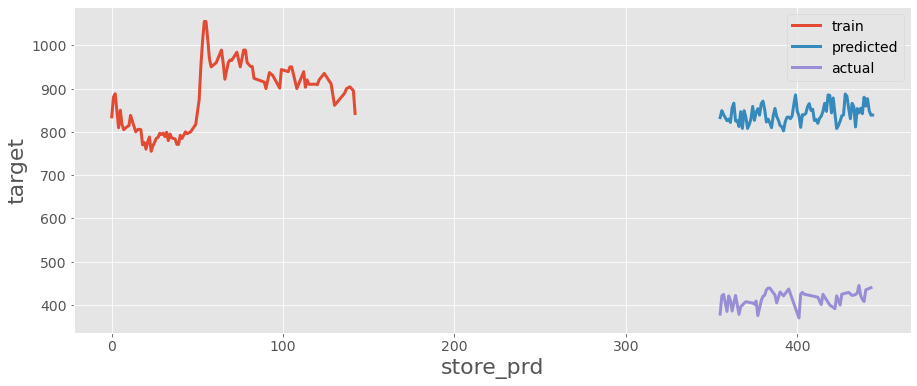

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win15[train_win15['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 30-Day Prediction

##### Load Train and Test Data

In [197]:
train_win60 = df_cal[(df_cal['lb60_plus30'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb60', 'lb60_plus30']]
train_win60['label'] = train_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
train_win60['target'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win60['store_frd'] = train_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win60['store_prd'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win60['feature'] = train_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in train_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(train_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(train_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(train_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(train_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(train_win60['feature'].to_list(), axis=0)

train_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(train_win60.shape, train_win60.columns)
train_win60.head(5)

(77, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             5

shoe_size_10  target  store_frd  store_prd           1       2       3  \
0             1   960.0      -22.0       68.0  916.666667  908.25  891.75   
0             1   966.0      -21.0       69.0  908.250000  891.75  895.00   
0             1   965.0      -20.0       70.0  891.750000  895.00  890.25   
0             1     NaN      -19.0       71.0  895.000000  890.25  895.00   
0             1   977.5      -18.0       72.0  890.250000  895.00  873.40   

        4       5      6  ...          51      52      53      54      55  \
0  895.00  890.25  895.0  ...  796.666667  794.00  797.00  789.00  799.00   
0  890.25  895.00  873.4  ...  794.000000  797.00  789.00  799.00  779.75   
0  895.00  873.40  850.0  ...  797.000000  789.00  799.00  779.75  795.00   
0  873.40  850.00  898.5  ...  789.000000  799.00  779.75  795.00  786.00   
0  850.00  898.50  879.5  ...  799.000000  779.75  795.00  786.00     NaN   

       56     57     58     59          60  
0  779.75  795.0  786.0    NaN  783.500000  
0  795.00  786.0    NaN  783.5  771.000000  
0  786.00    NaN  783.5  771.0  771.000000  
0     NaN  783.5  771.0  771.0  792.000000  
0  783.50  771.0  771.0  792.0  784.666667  

[5 rows x 64 columns]

In [198]:
test_win60 = df_cal[(df_cal['lb60_plus30'] >= CUTOFF_TRAINVAL) & (df_cal['lb60_plus30'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb60', 'lb60_plus30']]
test_win60['label'] = test_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
test_win60['target'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win60['store_frd'] = test_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win60['store_prd'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win60['feature'] = test_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in test_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(test_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(test_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(test_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(test_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(test_win60['feature'].to_list(), axis=0)

test_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(test_win60.shape, test_win60.columns)
test_win60.head(5)

(90, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             5

shoe_size_10  target  store_frd  store_prd       1       2      3      4  \
0             1   892.5       55.0      145.0  1055.0  1014.5  969.0  950.0   
0             1   891.5       56.0      146.0  1014.5   969.0  950.0    NaN   
0             1     NaN       57.0      147.0   969.0   950.0    NaN    NaN   
0             1   840.0       58.0      148.0   950.0     NaN    NaN  960.0   
0             1   867.5       59.0      149.0     NaN     NaN  960.0    NaN   

       5      6  ...     51     52     53     54     55     56     57     58  \
0    NaN    NaN  ...  950.0    NaN    NaN  900.0    NaN    NaN    NaN  939.0   
0    NaN  960.0  ...    NaN    NaN  900.0    NaN    NaN    NaN  939.0  903.0   
0  960.0    NaN  ...    NaN  900.0    NaN    NaN    NaN  939.0  903.0  920.0   
0    NaN    NaN  ...  900.0    NaN    NaN    NaN  939.0  903.0  920.0  910.0   
0    NaN  989.0  ...    NaN    NaN    NaN  939.0  903.0  920.0  910.0    NaN   

      59     60  
0  903.0  920.0  
0  920.0  910.0  
0  910.0    NaN  
0    NaN    NaN  
0    NaN    NaN  

[5 rows x 64 columns]

In [199]:
ret = py60.setup(data=train_win60, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [200]:
py60.compare_models(sort='R2')

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [201]:
py60.compare_models(sort='RMSE')

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')

##### Extra Trees - MAE 7.9989,  RMSE 11.5214, R2 0.7193

In [202]:
et60 = py60.create_model('et')

In [203]:
tuned_et60 = py60.tune_model(et60, optimize='RMSE', choose_better=True)

In [204]:
df_val60 = py60.predict_model(et60)

Model      MAE       MSE     RMSE     R2   RMSLE    MAPE
0  Extra Trees Regressor  17.2917  435.2271  20.8621  0.646  0.0226  0.0187

In [205]:
df_test60 = py60.predict_model(et60, data=test_win60)
df_test60

shoe_size_10  target  store_frd  store_prd       1       2      3      4  \
0              1   892.5       55.0      145.0  1055.0  1014.5  969.0  950.0   
1              1   891.5       56.0      146.0  1014.5   969.0  950.0    NaN   
2              1     NaN       57.0      147.0   969.0   950.0    NaN    NaN   
3              1   840.0       58.0      148.0   950.0     NaN    NaN  960.0   
4              1   867.5       59.0      149.0     NaN     NaN  960.0    NaN   
..           ...     ...        ...        ...     ...     ...    ...    ...   
85             1   935.0      140.0      230.0     NaN   895.0  842.5    NaN   
86             1     NaN      141.0      231.0   895.0   842.5    NaN    NaN   
87             1   970.0      142.0      232.0   842.5     NaN    NaN  892.5   
88             1   955.0      143.0      233.0     NaN     NaN  892.5  891.5   
89             1     NaN      144.0      234.0     NaN   892.5  891.5    NaN   

        5      6  ...     52     53     54     55     56     57     58     59  \
0     NaN    NaN  ...    NaN    NaN  900.0    NaN    NaN    NaN  939.0  903.0   
1     NaN  960.0  ...    NaN  900.0    NaN    NaN    NaN  939.0  903.0  920.0   
2   960.0    NaN  ...  900.0    NaN    NaN    NaN  939.0  903.0  920.0  910.0   
3     NaN    NaN  ...    NaN    NaN    NaN  939.0  903.0  920.0  910.0    NaN   
4     NaN  989.0  ...    NaN    NaN  939.0  903.0  920.0  910.0    NaN    NaN   
..    ...    ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
85    NaN  892.5  ...  910.0  875.5    NaN    NaN    NaN  905.0    NaN    NaN   
86  892.5  891.5  ...  875.5    NaN    NaN    NaN  905.0    NaN    NaN    NaN   
87  891.5    NaN  ...    NaN    NaN    NaN  905.0    NaN    NaN    NaN    NaN   
88    NaN  840.0  ...    NaN    NaN  905.0    NaN    NaN    NaN    NaN  904.0   
89  840.0  867.5  ...    NaN  905.0    NaN    NaN    NaN    NaN  904.0  863.0   

       60    Label  
0   920.0  867.045  
1   910.0  880.310  
2     NaN  884.635  
3     NaN  891.975  
4     NaN  890.860  
..    ...      ...  
85    NaN  903.415  
86    NaN  905.055  
87  904.0  907.970  
88  863.0  903.345  
89    NaN  902.650  

[90 rows x 65 columns]

##### Extra Trees - Prediction MAE 33.7633

In [206]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

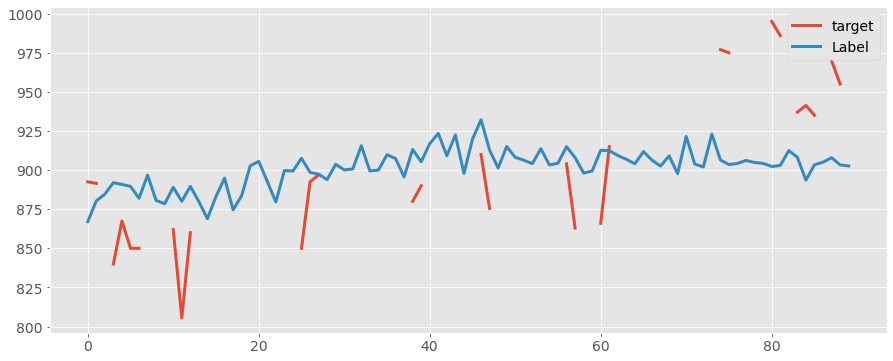

In [210]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

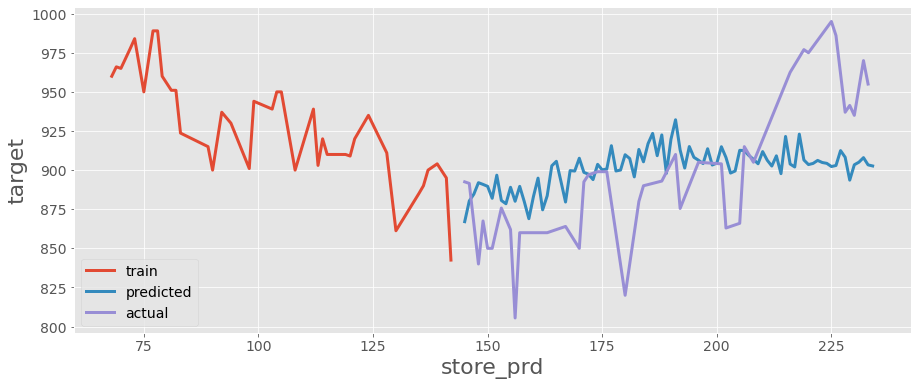

In [211]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 90-Day Prediction

##### Load Train and Test Data

ValueError encountered.  Not enough data data points for 180-day lookback window

In [212]:
try:
    train_win180 = df_cal[(df_cal['lb180_plus90'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb180', 'lb180_plus90']]
    train_win180['label'] = train_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
    train_win180['target'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
    train_win180['store_frd'] = train_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
    train_win180['store_prd'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
    train_win180['feature'] = train_win180['lst_lb180'].apply(lambda x: pvt_price[x])
    for row in train_win180['feature']:
        row.columns = np.arange(1, len(row.columns) + 1)

    label180 = pd.concat(train_win180['label'].to_list(), axis=0)
    label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
    target180 = pd.concat(train_win180['target'].to_list(), axis=0)
    store180_frd = pd.concat(train_win180['store_frd'].to_list(), axis=0)
    store180_prd = pd.concat(train_win180['store_prd'].to_list(), axis=0)
    feature180 = pd.concat(train_win180['feature'].to_list(), axis=0)

    train_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
    print(train_win180.shape, train_win180.columns)
    train_win180.head(5)
except Exception as e:
    print(str(e))

No objects to concatenate


In [213]:
try:
    test_win180 = df_cal[(df_cal['lb180_plus90'] >= CUTOFF_TRAINVAL) &
                        (df_cal['lb180_plus90'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb180', 'lb180_plus90']]
    test_win180['label'] = test_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
    test_win180['target'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
    test_win180['store_frd'] = test_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
    test_win180['store_prd'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
    test_win180['feature'] = test_win180['lst_lb180'].apply(lambda x: pvt_price[x])
    for row in test_win180['feature']:
        row.columns = np.arange(1, len(row.columns) + 1)

    label180 = pd.concat(test_win180['label'].to_list(), axis=0)
    label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
    target180 = pd.concat(test_win180['target'].to_list(), axis=0)
    store180_frd = pd.concat(test_win180['store_frd'].to_list(), axis=0)
    store180_prd = pd.concat(test_win180['store_prd'].to_list(), axis=0)
    feature180 = pd.concat(test_win180['feature'].to_list(), axis=0)

    test_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
    print(test_win180.shape, test_win180.columns)
    test_win180.head(5)
    ret = py180.setup(data=train_win180, target='target', train_size=0.80, session_id=123, silent=True)
except Exception as e:
    print(str(e))

No objects to concatenate


##### Compare Models

In [209]:
df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Release Date'] = pd.to_datetime(df['Release Date'])
df.head()

Order Date   Brand                                   Sneaker Name  \
0 2017-09-01   Yeezy           Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1 2017-09-01   Yeezy    Adidas-Yeezy-Boost-350-V2-Core-Black-Copper   
2 2017-09-01   Yeezy     Adidas-Yeezy-Boost-350-V2-Core-Black-Green   
3 2017-09-01   Yeezy       Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4 2017-09-01   Yeezy  Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017   

   Sale Price  Retail Price Release Date  Shoe Size  Buyer Region  
0      1097.0           220   2016-09-24       11.0    California  
1       685.0           220   2016-11-23       11.0    California  
2       690.0           220   2016-11-23       11.0    California  
3      1075.0           220   2016-11-23       11.5      Kentucky  
4       828.0           220   2017-02-11       11.0  Rhode Island

# ARIMA

## Data Processing

### Interpolation

In [74]:
def fill_dates(df, start, end):
    """Fill the dates of the data frame from start to end"""
    df_new = pd.DataFrame(columns=['Order Date'])
    df_new['Order Date'] = pd.date_range(start=start, end=end)
    df_new = pd.merge(df_new, df, on='Order Date', how='left')

    # Impute missing values
    brand = df['Brand'].values[0]
    sneaker_name = df['Sneaker Name'].values[0]
    retail_price = df['Retail Price'].values[0]
    shoe_size = df['Shoe Size'].values[0]

    df_new['Brand'] = df_new['Brand'].fillna(brand)
    df_new['Sneaker Name'] = (df_new['Sneaker Name'].fillna(sneaker_name))
    df_new['Retail Price'] = (df_new['Retail Price'].fillna(retail_price))
    df_new['Shoe Size'] = (df_new['Shoe Size'].fillna(shoe_size))
    df_new['Sale Price'] = (df_new['Sale Price'].interpolate(method='ffill'))
    return df_new

#### Yeezy Beluga

In [75]:
start_date = yeezy_beluga_10.loc[yeezy_beluga_10['Order Date']
                                 > '2018-01-01', 'Order Date'].min()
end_date = yeezy_beluga_10.loc[yeezy_beluga_10['Order Date']
                               > '2018-01-01', 'Order Date'].max()
yeezy_beluga_10_new = fill_dates(yeezy_beluga_10, start_date, end_date)

Highest price is 450.00 USD
Lowest price is 358.00 USD


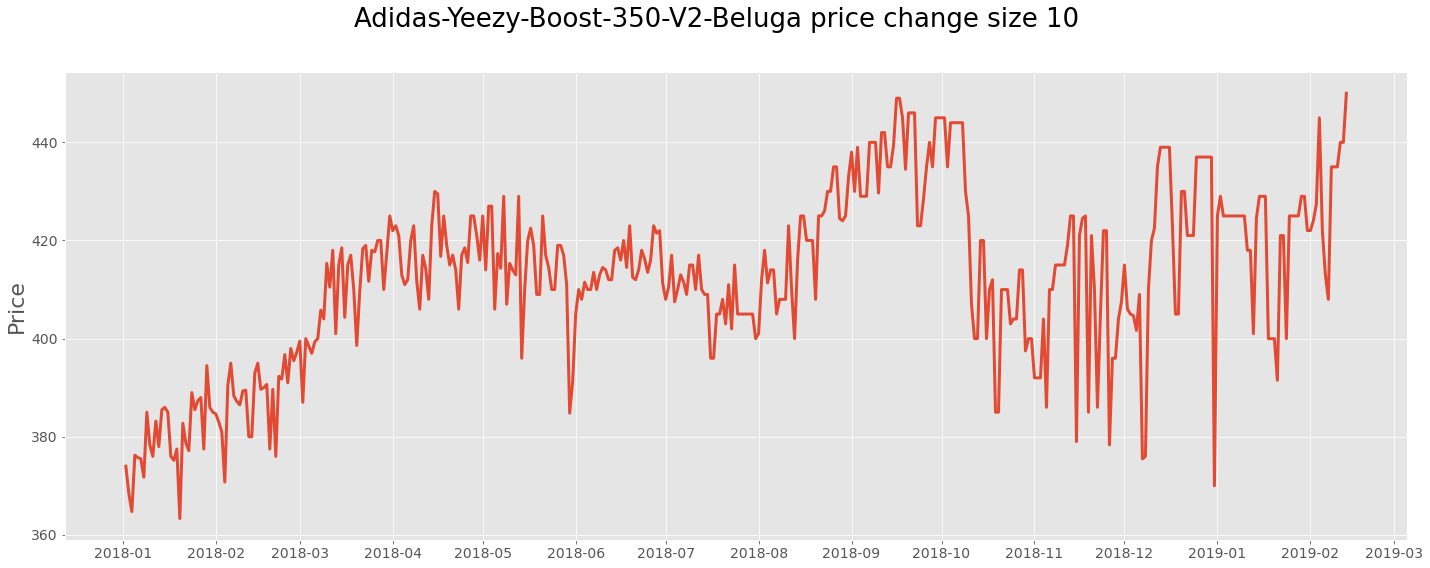

In [76]:
print('Highest price is %.2f USD' % yeezy_beluga_10_new['Sale Price'].max())
print('Lowest price is %.2f USD' % yeezy_beluga_10_new['Sale Price'].min())


fig, ax = plt.subplots(figsize=(20, 8), sharex=True)
ax.plot(yeezy_beluga_10_new.groupby('Order Date')['Sale Price']
        .mean().sort_index())

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.suptitle('Adidas-Yeezy-Boost-350-V2-Beluga price change size 10')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

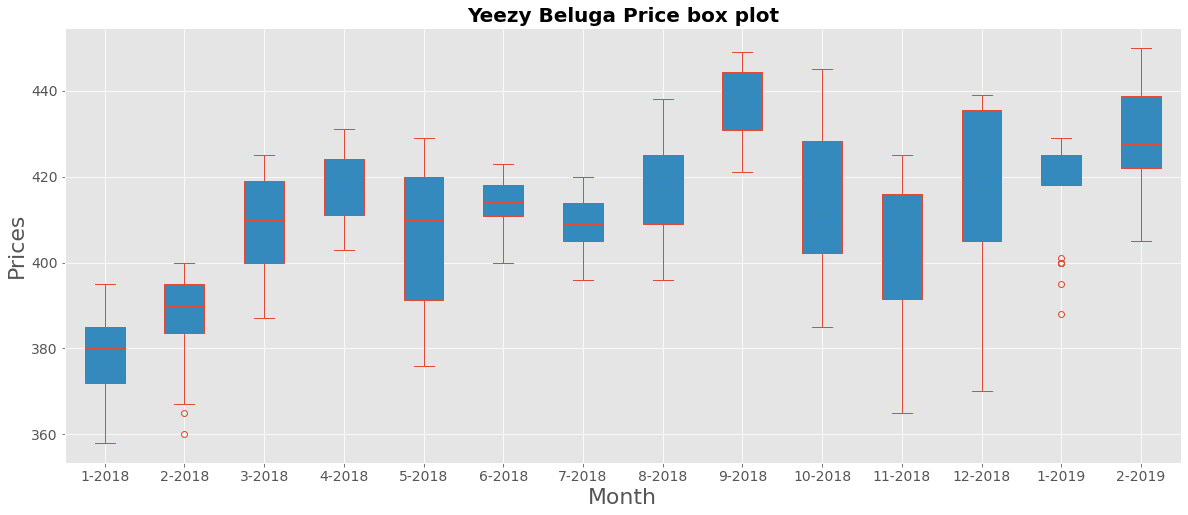

In [77]:
groups = yeezy_beluga_10_new.groupby(pd.Grouper(key='Order Date', freq='MS',
                                                label='left'))['Sale Price']

months = dict()
for name, group in groups:
    months[f'{name.month}-{name.year}'] = list(group.values)

plt.figure(figsize=(20, 8))
plt.boxplot(months.values(), patch_artist=True,
            boxprops=dict(color='#E24A33'),
            whiskerprops=dict(color='#E24A33'),
            flierprops=dict(color='#E24A33', markeredgecolor='#E24A33'),
            medianprops=dict(color='#E24A33'),
            capprops=dict(color='#E24A33'))

plt.title('Yeezy Beluga Price box plot')
plt.xlabel('Month')
plt.ylabel('Prices')
plt.xticks(range(1, len(months.keys()) + 1), months.keys())


del months
del groups

#### Jordan 1 Off-white

In [78]:
start_date = jordan1_uni_blue_9.loc[jordan1_uni_blue_9['Order Date']
                                    > '2018-06-01', 'Order Date'].min()
end_date = jordan1_uni_blue_9.loc[jordan1_uni_blue_9['Order Date']
                                  > '2018-01-01', 'Order Date'].max()
jordan1_uni_blue_9_new = fill_dates(jordan1_uni_blue_9, start_date, end_date)

Highest price is 1216.00 USD
Lowest price is 790.00 USD


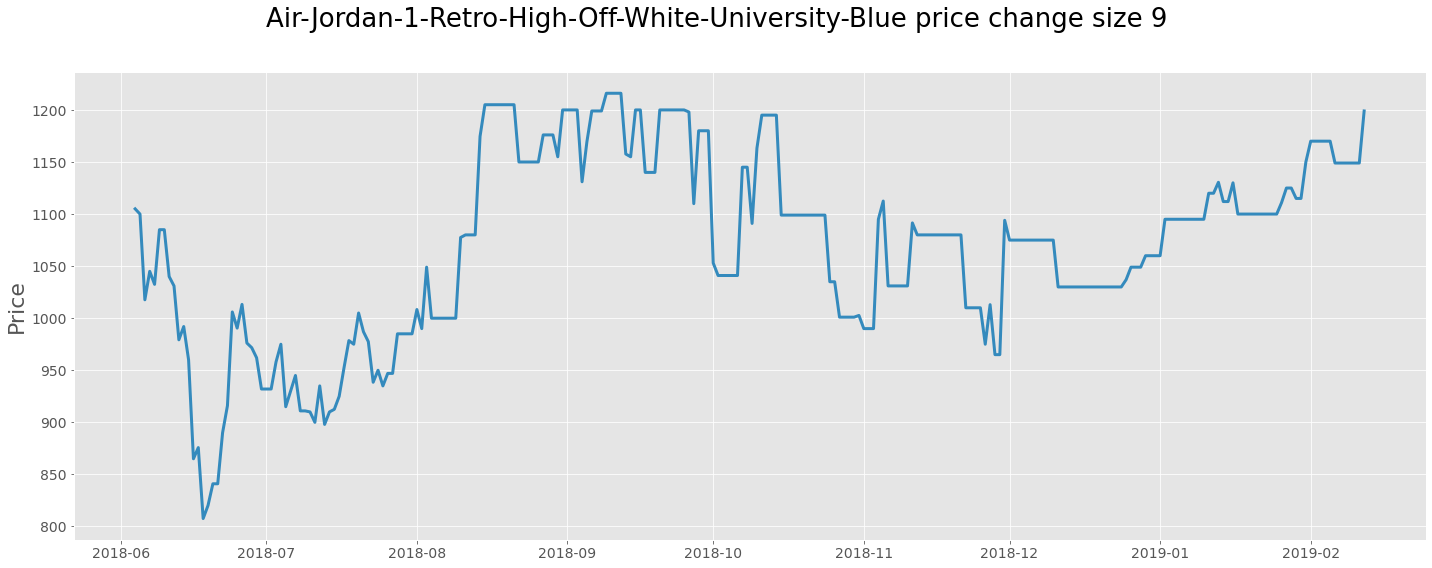

In [79]:
print('Highest price is %.2f USD' %
      jordan1_uni_blue_9_new['Sale Price'].max())
print('Lowest price is %.2f USD' % jordan1_uni_blue_9_new['Sale Price'].min())


fig, ax = plt.subplots(figsize=(20, 8), sharex=True)
ax.plot(jordan1_uni_blue_9_new.groupby('Order Date')['Sale Price']
        .mean().sort_index(), color='#348ABD')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.suptitle(
    'Air-Jordan-1-Retro-High-Off-White-University-Blue price change size 9')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

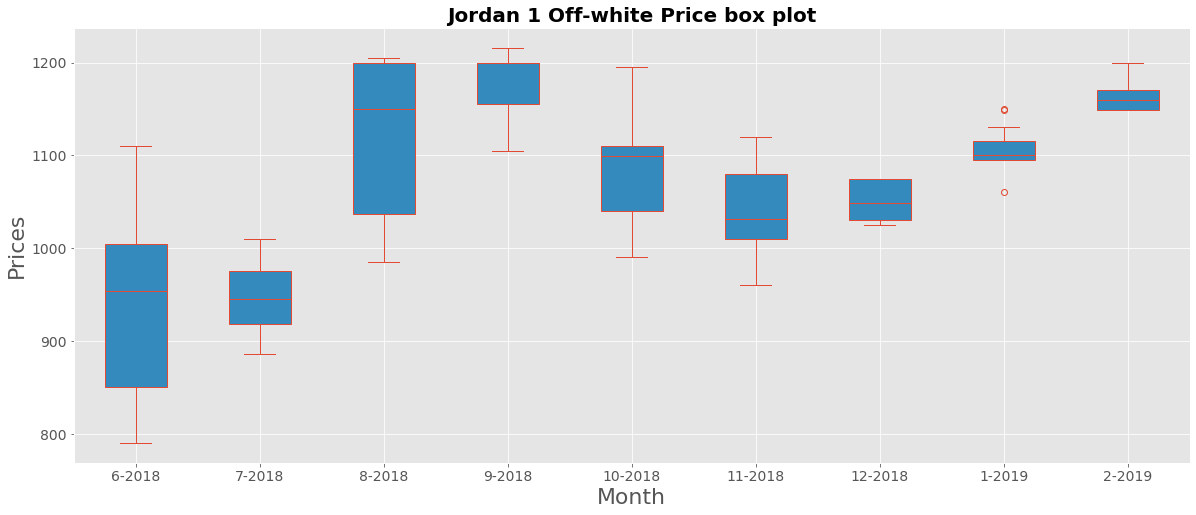

In [80]:
groups = jordan1_uni_blue_9_new.groupby(pd.Grouper(key='Order Date', freq='MS',
                                                   label='left'))['Sale Price']

months = dict()
for name, group in groups:
    months[f'{name.month}-{name.year}'] = list(group.values)

plt.figure(figsize=(20, 8))
plt.boxplot(months.values(), patch_artist=True,
            boxprops=dict(color='#E24A33'),
            whiskerprops=dict(color='#E24A33'),
            flierprops=dict(color='#E24A33', markeredgecolor='#E24A33'),
            medianprops=dict(color='#E24A33'),
            capprops=dict(color='#E24A33'))

plt.title('Jordan 1 Off-white Price box plot')
plt.xlabel('Month')
plt.ylabel('Prices')
plt.xticks(range(1, len(months.keys()) + 1), months.keys())


del months
del groups

## Grid Search ARIMA Yeezy Beluga

In [81]:
def is_stationary(timeseries, window=7):
    """Plot timeseries with rolling mean and std, cacl ADF stat"""
    # rolling statistics
    rolling_mean = timeseries.rolling(window=7).mean()
    rolling_std = timeseries.rolling(window=7).std()

    # rolling statistics plot
    fig = plt.figure(figsize=(20, 5))
    original = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolling_mean, label='Rolling Mean')
    std = plt.plot(rolling_std, label='Rolling Std')
    fig.autofmt_xdate()

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))


# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog), (self.k_lags, self.k_diff, self.k_ma))


ARIMA.__getnewargs__ = __getnewargs__


def difference(dataset, interval=1):
    """Creates a differenced series"""
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


def inverse_difference(history, yhat, interval=1):
    """Inverse Difference of yhat"""
    return yhat + history[-interval]


def evaluate_arima_model(X, arima_order, window, bias=None):
    """Evaluate ARIMA model"""
    X = X.astype('float32')
    test_size = int(len(X) * 0.25)
    train, test = X.iloc[0:-test_size], X.iloc[-test_size:]
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        diff = difference(history, window)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat += bias
        predictions.append(yhat)
        history.append(test[i])
    # Calculate out of sample error
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test, predictions)
    return mae, rmse, r2, test, predictions


def evaluate_models(dataset, p_values, d_values, q_values, window):
    dataset = dataset.astype('float32')
    best_mae, best_rmse, best_cfg = float('inf'), float('inf'), None
    for p in tqdm(p_values):
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mae, mse, r2, test, pred = evaluate_arima_model(dataset,
                                                                    order,
                                                                    window)
                    print('ARIMA %s MAE = %.3f RMSE = %.3f R2 = %.3f' %
                          (order, mae, mse, r2))
                    if mae < best_mae:
                        best_mae, best_rmse, best_cfg = mae, mse, order
                except:
                    continue
    print('Best ARIMA %s MAE=%.3f RMSE= %.3f' % (best_cfg,
                                                 best_mae,
                                                 best_rmse))
    return best_cfg


def validate_model(test, train, model_fit, bias, arima_order, window):
    """Validate test using the fitted model of ARIMA"""
    # Make first prediction
    predictions = list()
    history = list(train.values.astype('float32'))
    y = test.values.astype('float32')
    yhat = float(model_fit.forecast()[0])
    yhat = bias + inverse_difference(history, yhat, window)
    predictions.append(yhat)
    history.append(y[0])

    # Rolling forecast
    for i in range(1, len(y)):
        # Difference data
        diff = difference(history, window)
        # Predict
        model = ARIMA(diff, order=best_cfg)
        model_fit = model.fit(trend='nc', disp=0)
#         yhat = model_fit.predict(0)[0]
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat = yhat + bias
        predictions.append(yhat)
        # Observation
        history.append(y[i])
#         print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[i]))

    # Report performance
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, predictions)
    mae = mean_absolute_error(y, predictions)
    return mae, rmse, r2, y, predictions

In [82]:
sale_price = (yeezy_beluga_10_new.groupby('Order Date')['Sale Price']
              .mean().sort_index())

# Train price = Jan to 1st Half Nov 2018
train_price = sale_price.loc[sale_price.index <= '2018-11-15'].copy()

# Test price = 2nd Half Nov 2018 to 1st Half Feb 2019
test_price = sale_price.loc[sale_price.index > '2018-11-15'].copy()

### Raw Data

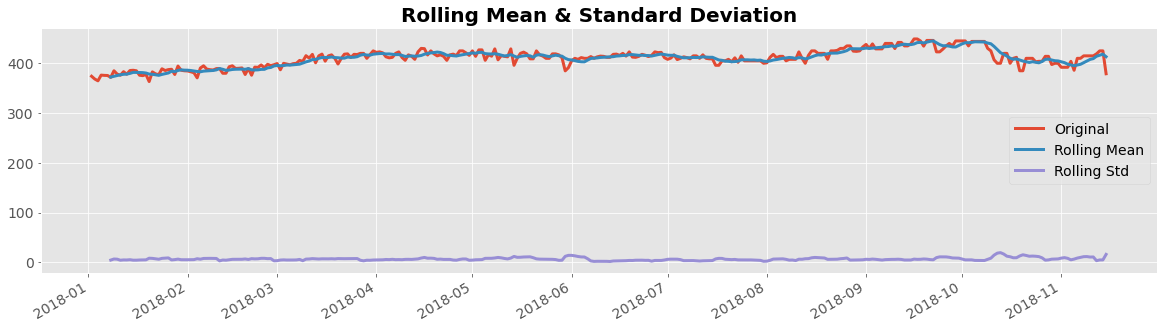

ADF Statistic: -2.6115298788689016
p-value: 0.09063761391742281
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


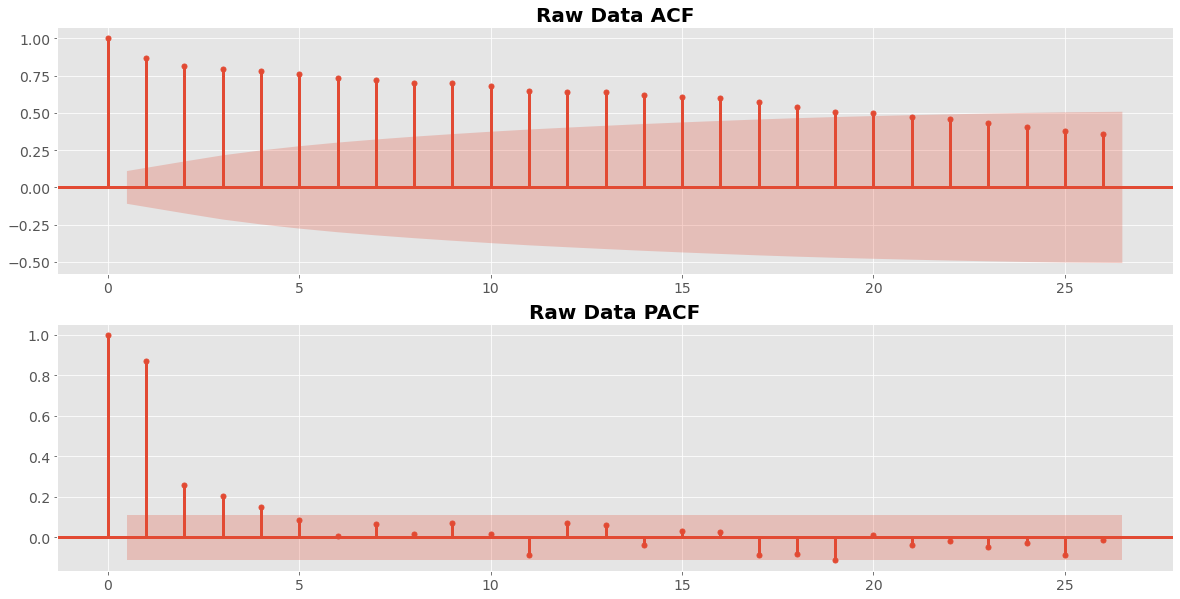

In [83]:
warnings.filterwarnings("ignore")

is_stationary(train_price, 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(train_price, ax=ax1,
         title='Raw Data ACF')
plot_pacf(train_price, ax=ax2,
          title='Raw Data PACF')
plt.show()

### LOCF Difference + Window 1

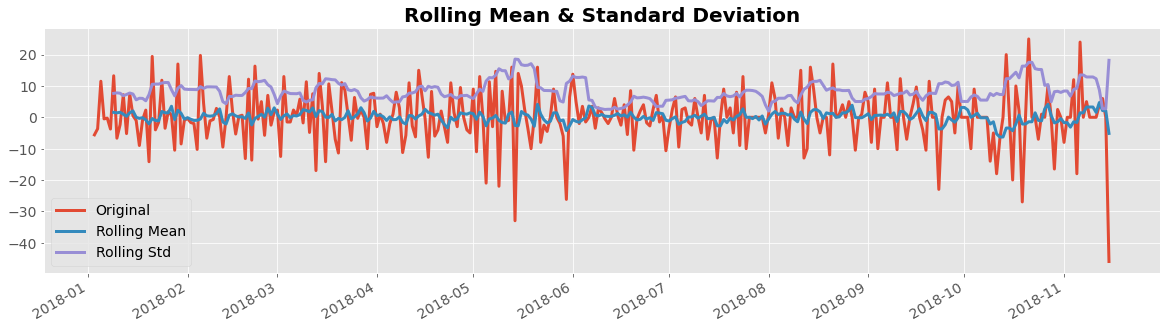

ADF Statistic: -12.473020672092566
p-value: 3.213459931884337e-23
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


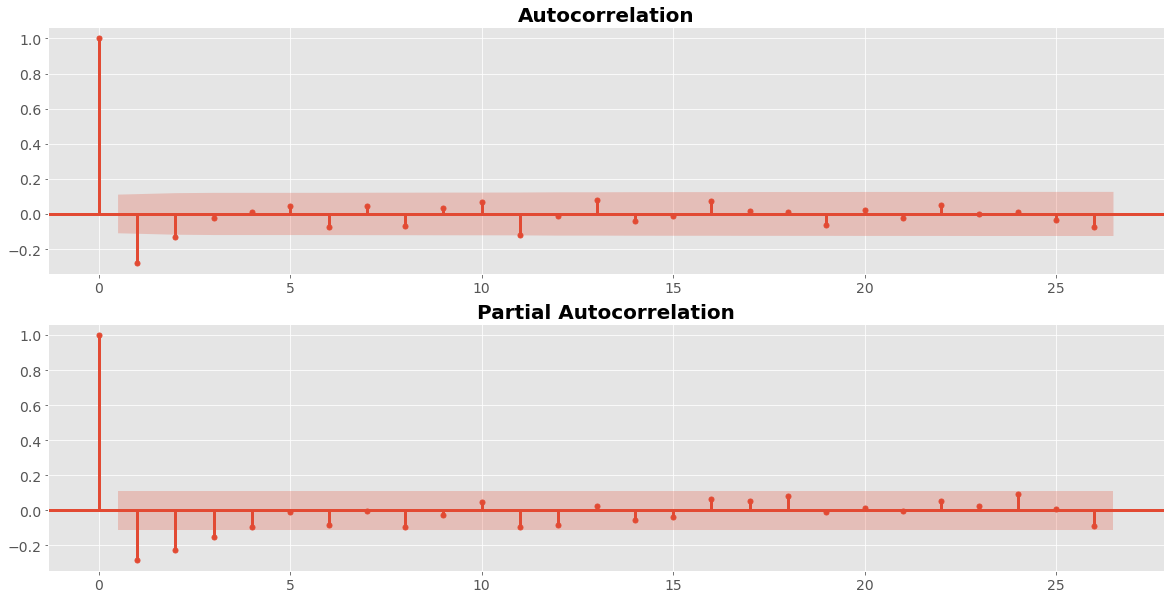

In [84]:
warnings.filterwarnings("ignore")
window = 1
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

### LOCF Difference + Window 7

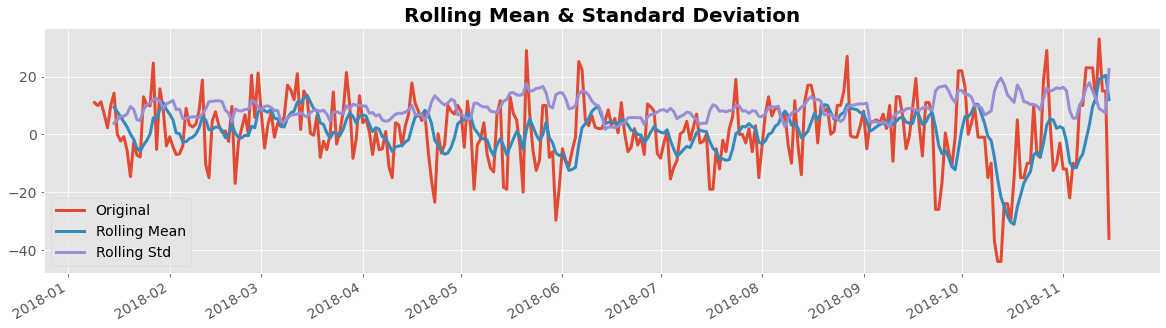

ADF Statistic: -3.16965515156471
p-value: 0.021809730019075612
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


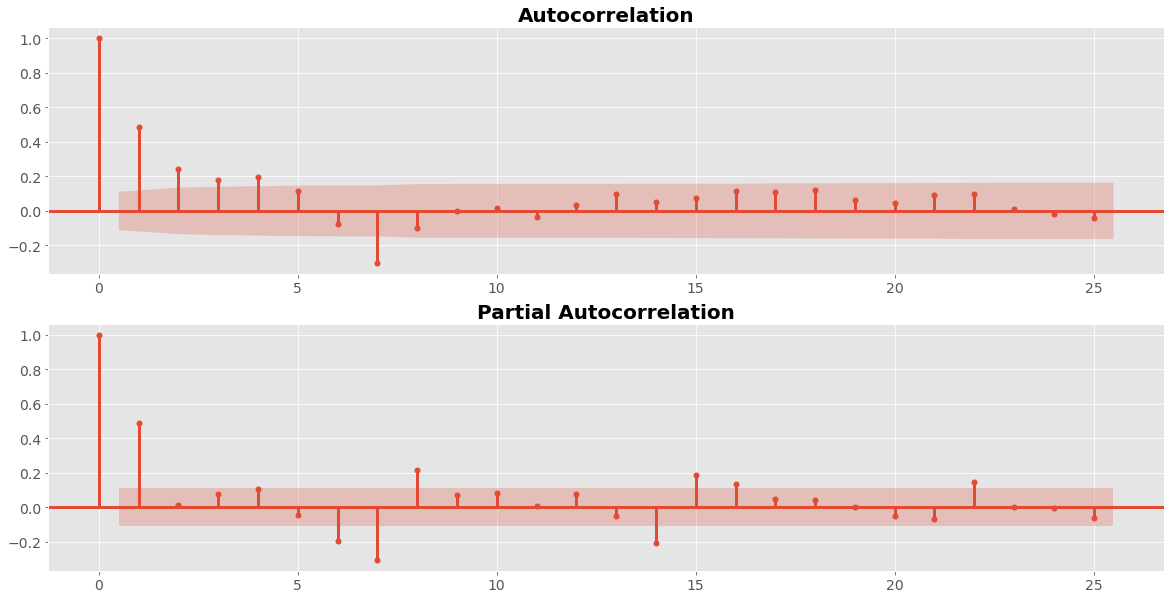

In [85]:
warnings.filterwarnings("ignore")
window = 7
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

As the P-Value of the Augmented Dickey Fuller test is greater than the significant value, we cannot reject the null hypothesis which states that the data is not stationary.

In [86]:
p_values = [0, 1, 2, 3]
d_values = range(0, 2)
q_values = [0, 1, 2]

best_cfg = evaluate_models(train_price, p_values, d_values, q_values, window)

ARIMA (0, 0, 1) MAE = 10.467 RMSE = 13.680 R2 = 0.455
ARIMA (0, 0, 2) MAE = 10.060 RMSE = 13.167 R2 = 0.495
ARIMA (0, 1, 1) MAE = 10.480 RMSE = 14.364 R2 = 0.399
ARIMA (0, 1, 2) MAE = 10.118 RMSE = 14.051 R2 = 0.425
ARIMA (1, 0, 0) MAE = 9.821 RMSE = 12.950 R2 = 0.512
ARIMA (1, 0, 1) MAE = 9.872 RMSE = 13.028 R2 = 0.506
ARIMA (1, 0, 2) MAE = 9.835 RMSE = 13.065 R2 = 0.503
ARIMA (1, 1, 0) MAE = 10.332 RMSE = 13.612 R2 = 0.461
ARIMA (1, 1, 1) MAE = 9.825 RMSE = 13.209 R2 = 0.492
ARIMA (1, 1, 2) MAE = 9.825 RMSE = 13.356 R2 = 0.481
ARIMA (2, 0, 0) MAE = 9.839 RMSE = 12.996 R2 = 0.508
ARIMA (2, 0, 1) MAE = 9.877 RMSE = 13.070 R2 = 0.503
ARIMA (2, 0, 2) MAE = 9.868 RMSE = 13.060 R2 = 0.503
ARIMA (2, 1, 0) MAE = 9.942 RMSE = 13.736 R2 = 0.451
ARIMA (2, 1, 1) MAE = 9.833 RMSE = 13.299 R2 = 0.485
ARIMA (2, 1, 2) MAE = 9.839 RMSE = 13.305 R2 = 0.485
ARIMA (3, 0, 0) MAE = 9.861 RMSE = 13.059 R2 = 0.504
ARIMA (3, 0, 1) MAE = 9.820 RMSE = 13.033 R2 = 0.505
ARIMA (3, 0, 2) MAE = 8.973 RMSE = 12.043

### Inspect best result

               0
count  79.000000
mean   -0.823235
std    12.091194
min   -43.041342
25%    -8.029517
50%     0.189885
75%     6.666844
max    22.106592
MAE=8.973 RMSE=12.043 R2=0.578


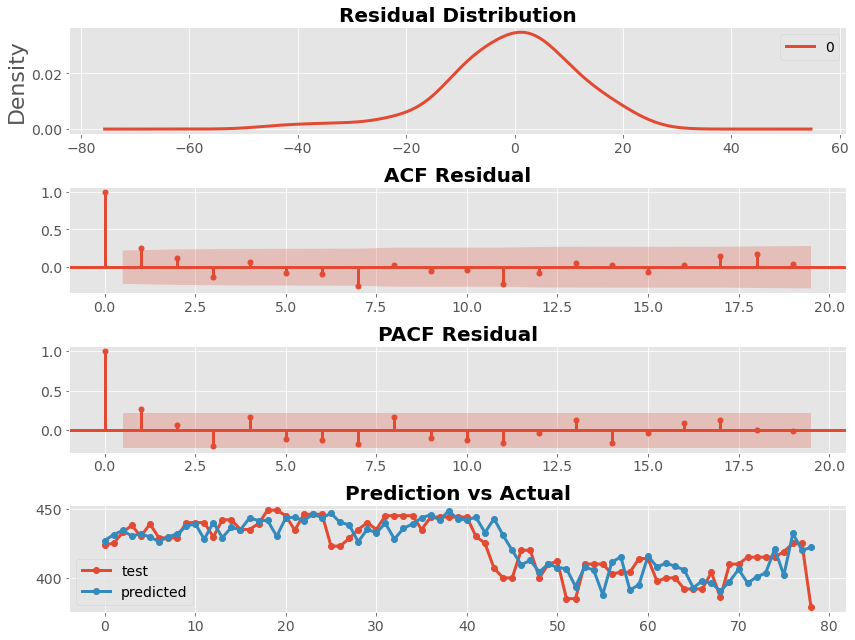

In [87]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg, window)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
bias = residuals.mean()
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

### Add bias based on residual error

                  0
count  7.900000e+01
mean   2.878148e-15
std    1.209119e+01
min   -4.221811e+01
25%   -7.206282e+00
50%    1.013120e+00
75%    7.490080e+00
max    2.292983e+01
MAE=9.018 RMSE=12.014 R2=0.580


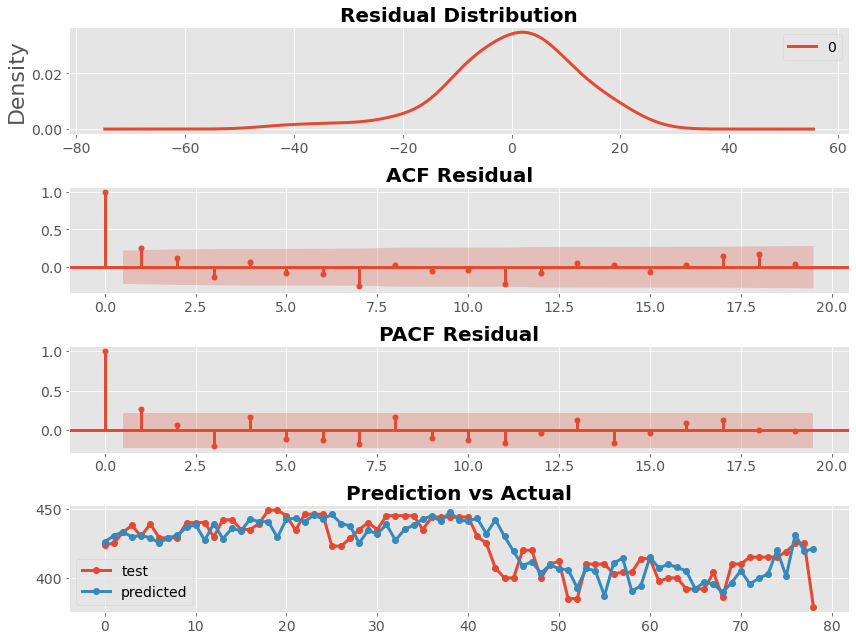

In [88]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg,
                                              window, bias)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

### Validate Result

In [89]:
bias = 0

#### Forecast 1 week

MAE=15.364 RMSE=17.511 R2=-0.143


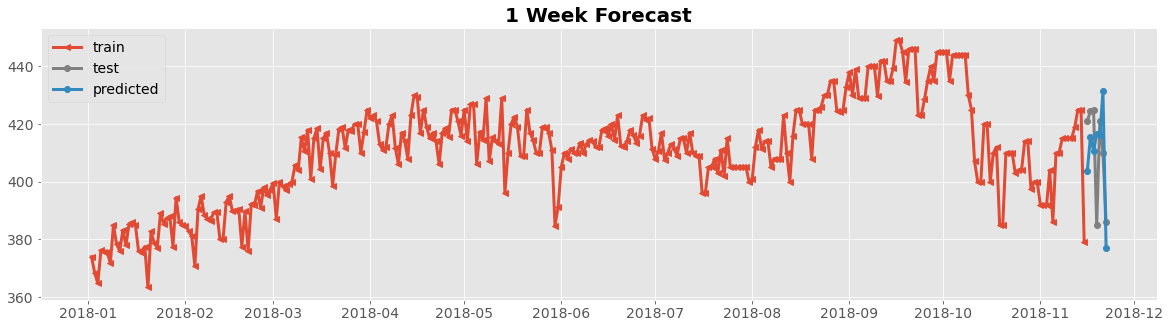

In [90]:
start = test_price.index[0]
end = start + timedelta(days=6)
y1week = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().dropna()

mae, mse, r2, y, ypred = validate_model(y1week, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('1 Week Forecast')

# Train set
plt.plot(train_price.index, train_price.values,
         marker='<', label='train')
# Test set
plt.plot(y1week.index, y, marker='o', color='gray', label='test')
plt.plot(y1week.index, ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

#### Forecast 2 months

MAE=15.070 RMSE=19.439 R2=-0.207


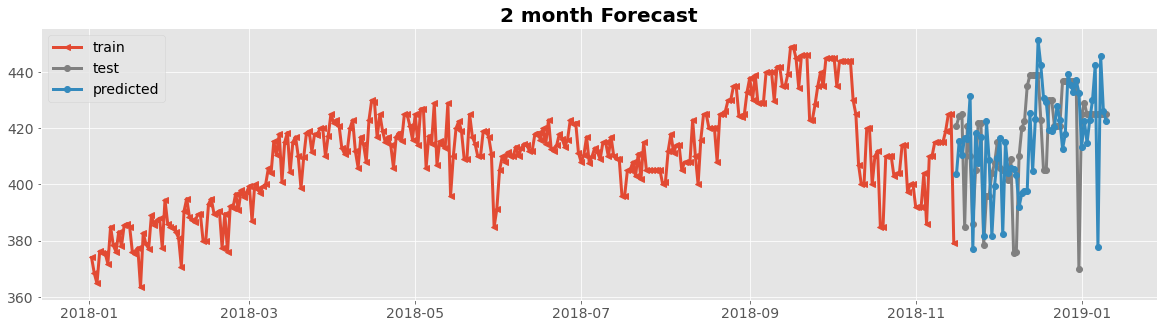

In [91]:
start = test_price.index[0]
end = start + timedelta(days=55)
y2mos = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)

mae, mse, r2, y, ypred = validate_model(y2mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('2 month Forecast')

# Train set
plt.plot(train_price.index, train_price.values,
         marker='<', label='train')
# Test set
plt.plot(y2mos.index, y, marker='o', color='gray', label='test')
plt.plot(y2mos.index, ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

#### Forecast 3 months

MAE=14.450 RMSE=18.175 R2=-0.276


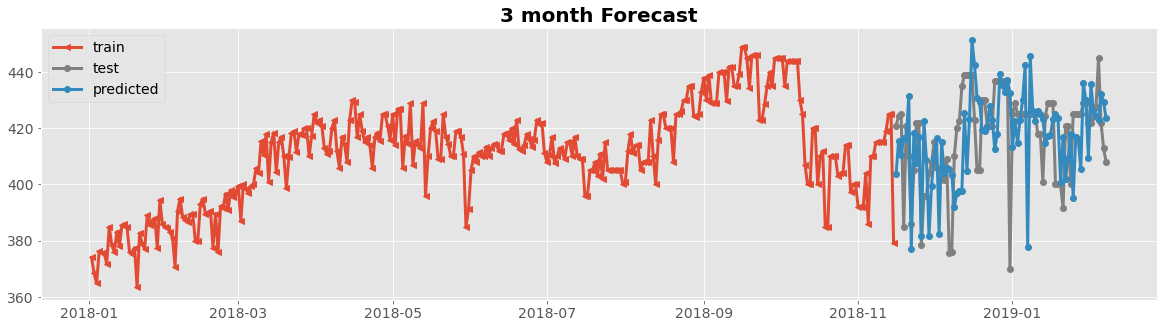

In [92]:
start = test_price.index[0]
end = start + timedelta(days=83)
y3mos = test_price.loc[start:end]

diff = difference(train_price.values.astype('float32'), window)
model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)

mae, mse, r2, y, ypred = validate_model(y3mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('3 month Forecast')

# Train set
plt.plot(train_price.index, train_price.values,
         marker='<', label='train')
# Test set
plt.plot(y3mos.index, y, marker='o', color='gray', label='test')
plt.plot(y3mos.index, ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

## Grid Search ARIMA Jordan 1

In [93]:
sale_price = (jordan1_uni_blue_9_new.groupby('Order Date')['Sale Price']
              .mean().sort_index())

# Train price = Jan to 1st Half Nov 2018
m1 = sale_price.index >= '2018-06-01'
m2 = sale_price.index <= '2018-10-15'
train_price = sale_price.loc[m1 & m2].copy()

# Test price = 2nd Half Nov 2018 to 1st Half Feb 2019
test_price = sale_price.loc[sale_price.index > '2018-10-15'].copy()

### Raw Data

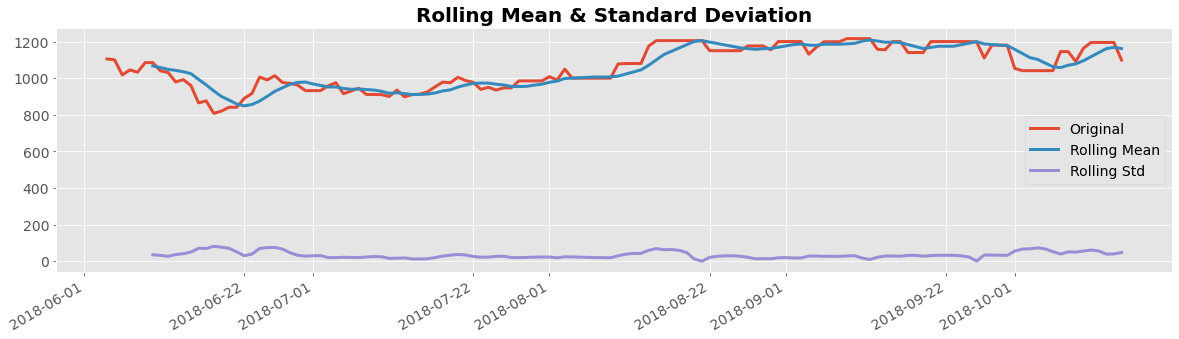

ADF Statistic: -1.8023186474728135
p-value: 0.3793111586425201
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578


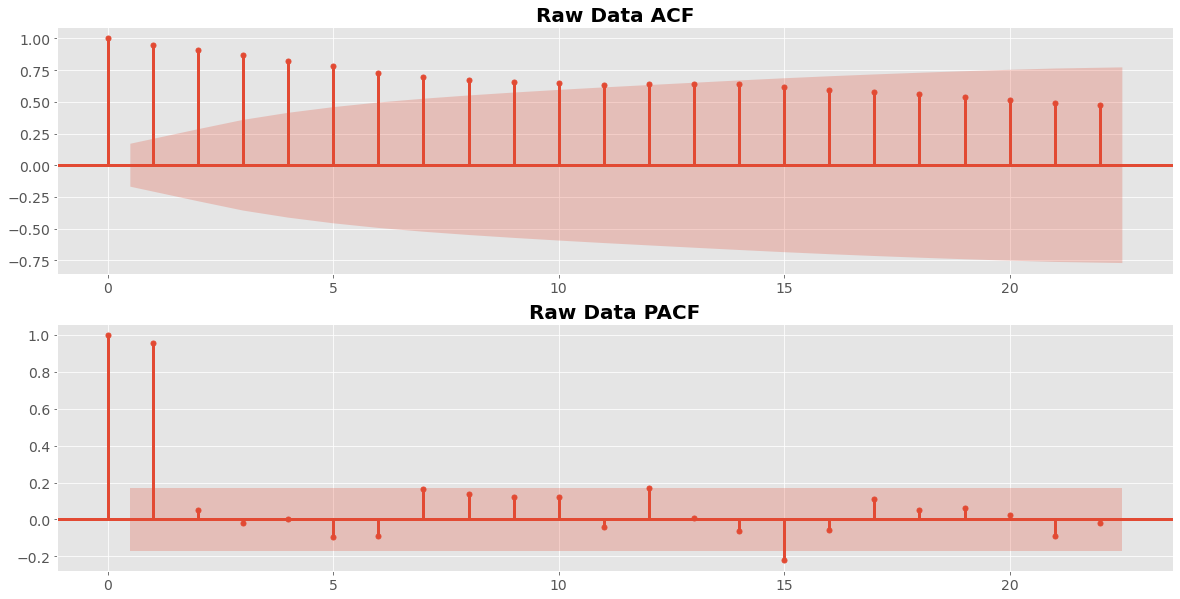

In [94]:
warnings.filterwarnings("ignore")

is_stationary(train_price, 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(train_price, ax=ax1,
         title='Raw Data ACF')
plot_pacf(train_price, ax=ax2,
          title='Raw Data PACF')
plt.show()

### LOCF Difference + Window 1

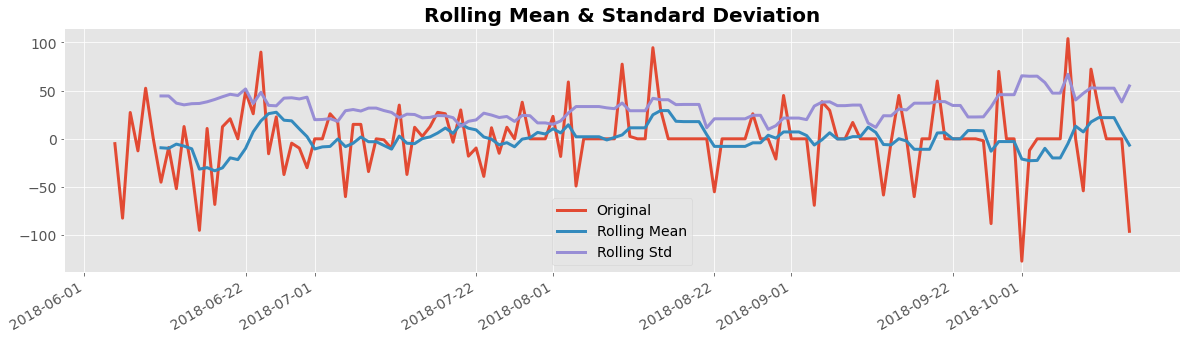

ADF Statistic: -12.136346632492128
p-value: 1.690101126638246e-22
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


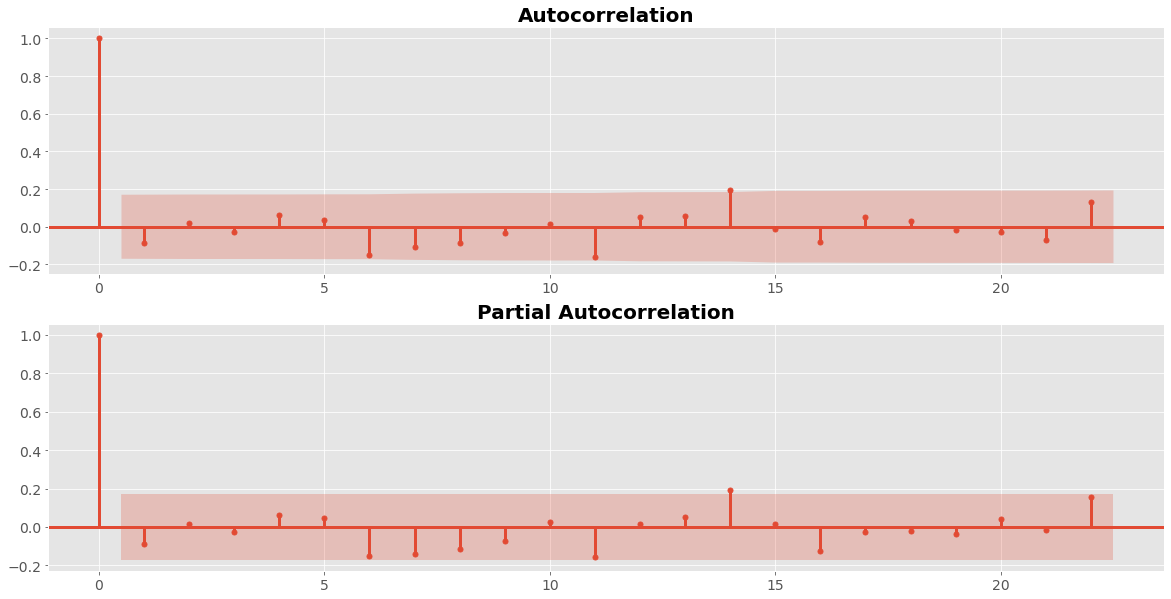

In [95]:
warnings.filterwarnings("ignore")
window = 1
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

### LOCF Difference + Window 7

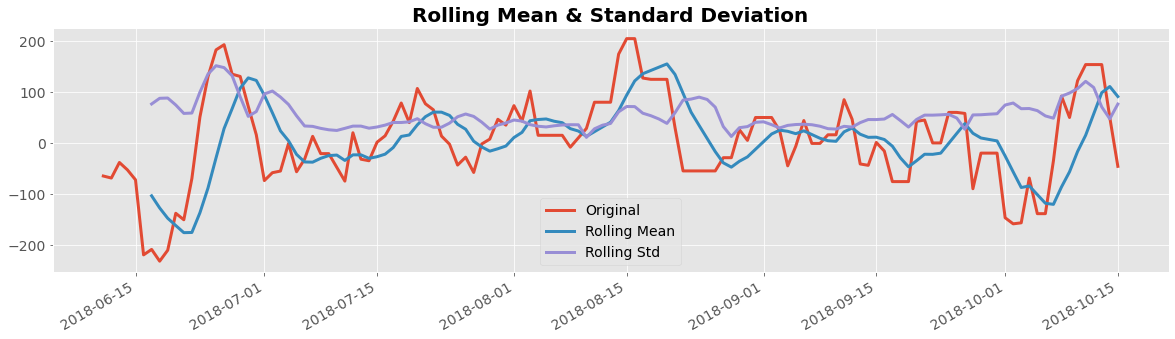

ADF Statistic: -4.106000043312954
p-value: 0.0009466419061043221
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


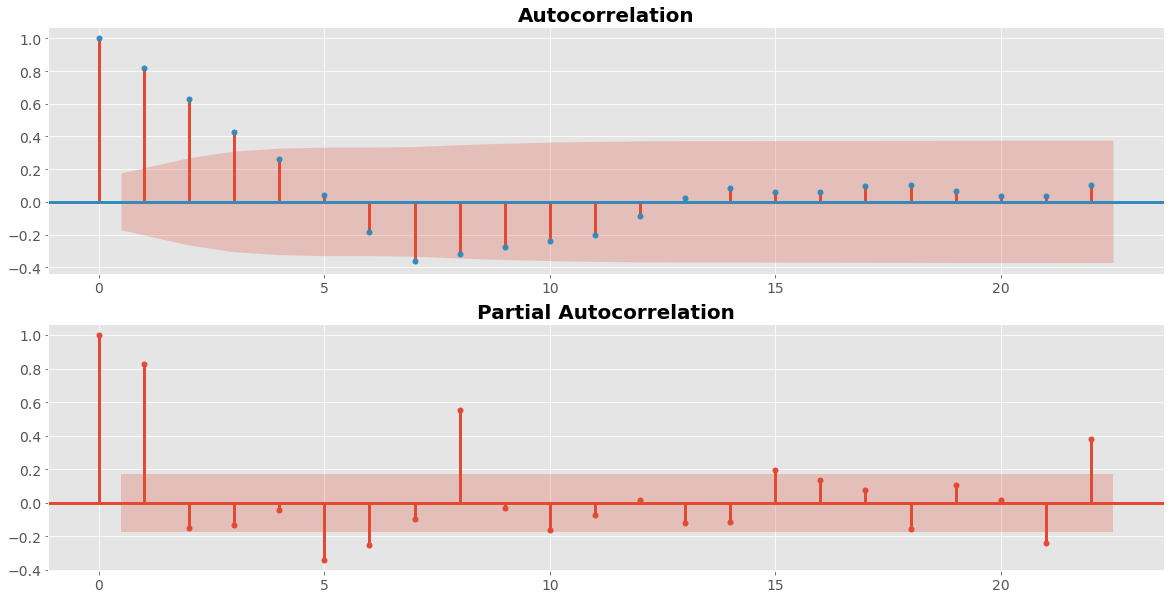

In [96]:
warnings.filterwarnings("ignore")
window = 7
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1, color='#348ABD')
plot_pacf(stationary, ax=ax2)
plt.show()

### Inspect best result

                0
count   33.000000
mean    -3.695117
std     64.395027
min   -133.928232
25%    -57.703794
50%     -0.697142
75%     44.293051
max    129.177359
MAE=49.245 RMSE=63.519 R2=-0.211


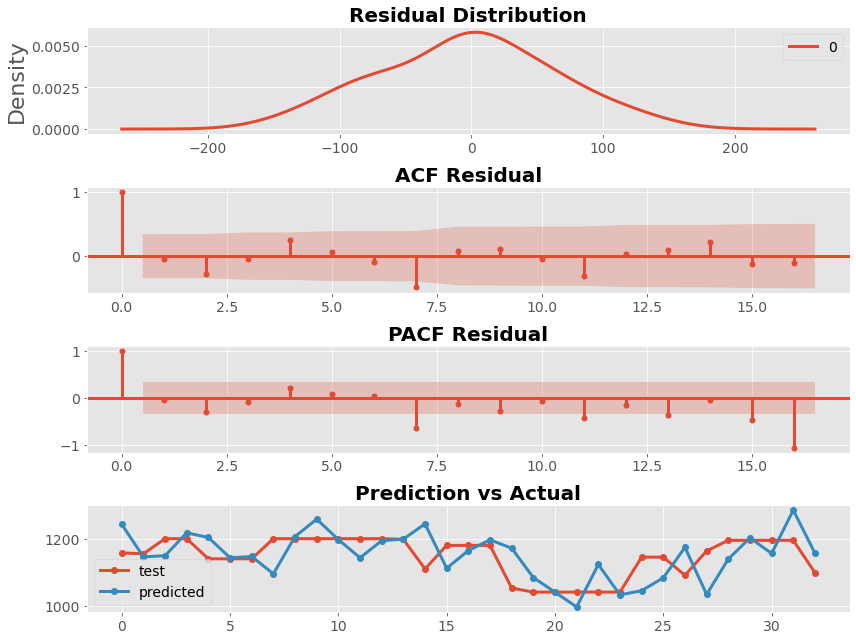

In [97]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg, window)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
bias = residuals.mean()
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

## Grid Search ARIMA Shifted

In [98]:
def is_stationary(timeseries, window=7):
    """Plot timeseries with rolling mean and std, cacl ADF stat"""
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()

    # rolling statistics plot
    plt.figure(figsize=(20, 5))
    original = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolling_mean, label='Rolling Mean')
    std = plt.plot(rolling_std, label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))


# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog), (self.k_lags, self.k_diff, self.k_ma))


ARIMA.__getnewargs__ = __getnewargs__


def difference(dataset, interval=1):
    """Creates a differenced series"""
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


def inverse_difference(history, yhat, interval=1):
    """Inverse Difference of yhat"""
    return yhat + history[-interval]


def evaluate_arima_model(X, arima_order, window, bias=None):
    """Evaluate ARIMA model"""
    X = X.astype('float32')
    test_size = int(len(X) * 0.25)
    train, test = X.iloc[0:-test_size], X.iloc[-test_size:]
    history = [x for x in train]
    predictions = list()
    for i in range(1, len(test)):
        diff = difference(history, window)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat += bias
        predictions.append(yhat)
        history.append(test[i])
    # Calculate out of sample error
    mae = mean_absolute_error(test[:-1], predictions)
    mse = mean_squared_error(test[:-1], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[:-1], predictions)
    return mae, rmse, r2, test[:-1], predictions


def evaluate_models(dataset, p_values, d_values, q_values, window):
    dataset = dataset.astype('float32')
    best_mae, best_rmse, best_cfg = float('inf'), float('inf'), None
    for p in tqdm(p_values):
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mae, mse, r2, test, pred = evaluate_arima_model(dataset,
                                                                    order,
                                                                    window)
                    print('ARIMA %s MAE = %.3f RMSE = %.3f R2 = %.3f' %
                          (order, mae, mse, r2))
                    if mae < best_mae:
                        best_mae, best_rmse, best_cfg = mae, mse, order
                except:
                    continue
    print('Best ARIMA %s MAE=%.3f RMSE= %.3f' % (best_cfg,
                                                 best_mae,
                                                 best_rmse))
    return best_cfg


def validate_model(test, train, model_fit, bias, arima_order, window):
    """Validate test using the fitted model of ARIMA"""
    # Make first prediction
    predictions = list()
    history = list(train.values.astype('float32'))
    y = test.values.astype('float32')
    yhat = float(model_fit.forecast()[0])
    yhat = bias + inverse_difference(history, yhat, window)
    predictions.append(yhat)
    history.append(y[0])

    # Rolling forecast
    for i in range(2, len(y)):
        # Difference data
        diff = difference(history, window)
        # Predict
        model = ARIMA(diff, order=best_cfg)
        model_fit = model.fit(trend='nc', disp=0)
#         yhat = model_fit.predict(0)[0]
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat = yhat + bias
        predictions.append(yhat)
        # Observation
        history.append(y[i])
#         print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[i]))

    # Report performance
    mse = mean_squared_error(y[:-1], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y[:-1], predictions)
    mae = mean_absolute_error(y[:-1], predictions)
    return mae, rmse, r2, y[:-1], predictions

In [99]:
sale_price = (yeezy_beluga_10_new.groupby('Order Date')['Sale Price']
              .mean().sort_index())

# Train price = Jan to 1st Half Nov 2018
train_price = sale_price.loc[sale_price.index <= '2018-11-15'].copy()

# Test price = 2nd Half Nov 2018 to 1st Half Feb 2019
test_price = sale_price.loc[sale_price.index > '2018-11-15'].copy()

### Raw Data

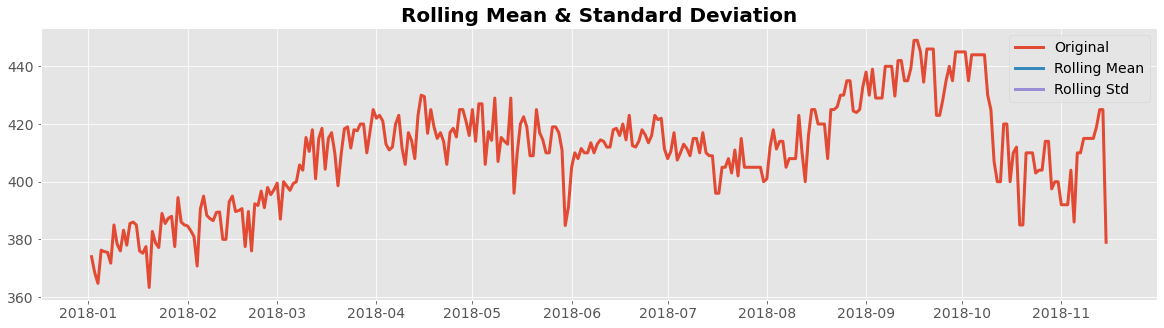

ADF Statistic: -2.6115298788689016
p-value: 0.09063761391742281
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


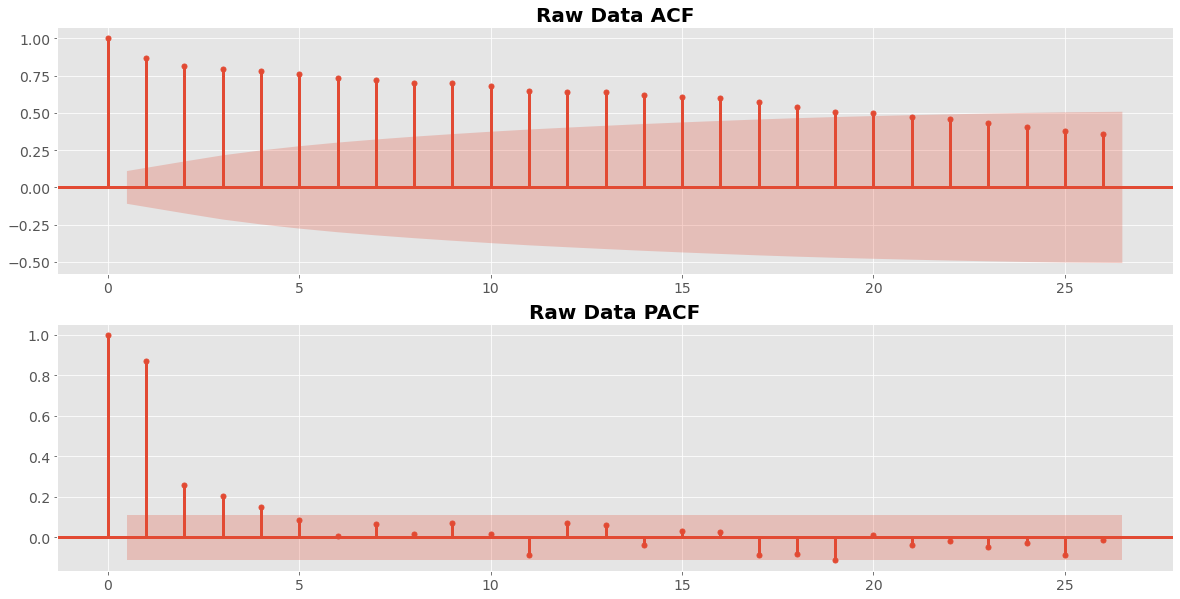

In [100]:
warnings.filterwarnings("ignore")

is_stationary(train_price, 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(train_price, ax=ax1,
         title='Raw Data ACF')
plot_pacf(train_price, ax=ax2,
          title='Raw Data PACF')
plt.show()

### LOCF Difference + Window 1

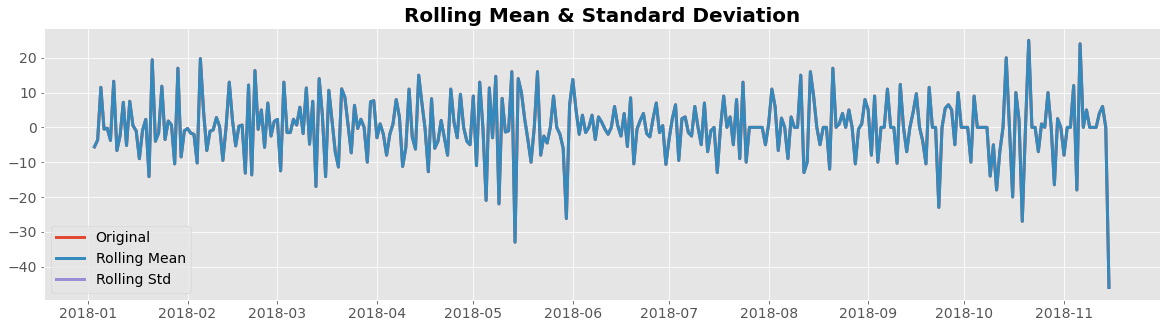

ADF Statistic: -12.473020672092566
p-value: 3.213459931884337e-23
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


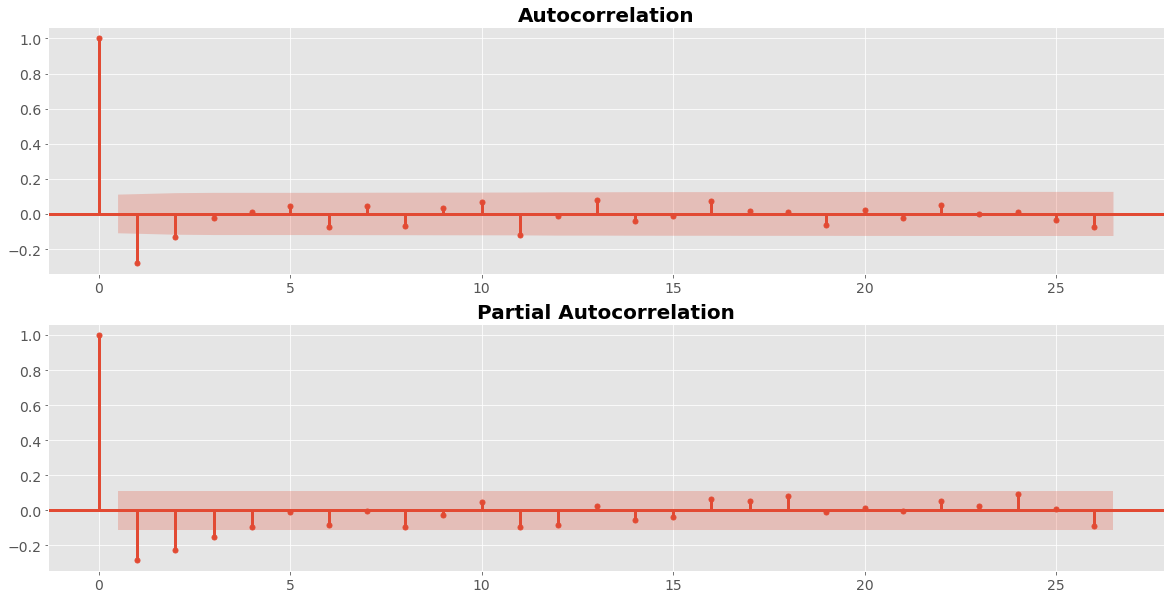

In [101]:
warnings.filterwarnings("ignore")
window = 1
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

As the P-Value of the Augmented Dickey Fuller test is greater than the significant value, we cannot reject the null hypothesis which states that the data is not stationary.

In [102]:
p_values = [0, 1, 2, 3]
d_values = range(0, 2)
q_values = [0, 1, 2]

best_cfg = evaluate_models(train_price, p_values, d_values, q_values, window)

ARIMA (0, 0, 1) MAE = 4.557 RMSE = 5.692 R2 = 0.900
ARIMA (0, 0, 2) MAE = 4.168 RMSE = 5.243 R2 = 0.915
ARIMA (0, 1, 1) MAE = 0.191 RMSE = 0.215 R2 = 1.000
ARIMA (0, 1, 2) MAE = 4.418 RMSE = 5.765 R2 = 0.897
ARIMA (1, 0, 0) MAE = 2.023 RMSE = 3.079 R2 = 0.971
ARIMA (1, 0, 1) MAE = 4.126 RMSE = 5.223 R2 = 0.916
ARIMA (1, 0, 2) MAE = 4.217 RMSE = 5.306 R2 = 0.913
ARIMA (1, 1, 0) MAE = 4.645 RMSE = 6.109 R2 = 0.884
ARIMA (2, 0, 0) MAE = 3.357 RMSE = 4.257 R2 = 0.944
ARIMA (2, 0, 1) MAE = 4.207 RMSE = 5.300 R2 = 0.913
ARIMA (2, 0, 2) MAE = 4.186 RMSE = 5.303 R2 = 0.913
ARIMA (2, 1, 0) MAE = 3.781 RMSE = 4.849 R2 = 0.927
ARIMA (3, 0, 0) MAE = 3.894 RMSE = 4.807 R2 = 0.928
ARIMA (3, 0, 1) MAE = 4.207 RMSE = 5.316 R2 = 0.912
ARIMA (3, 1, 0) MAE = 3.560 RMSE = 4.458 R2 = 0.938

Best ARIMA (0, 1, 1) MAE=0.191 RMSE= 0.215


### Inspect best result

               0
count  78.000000
mean   -0.191263
std     0.099402
min    -0.757257
25%    -0.255233
50%    -0.209104
75%    -0.122752
max    -0.038055
MAE=0.191 RMSE=0.215 R2=1.000


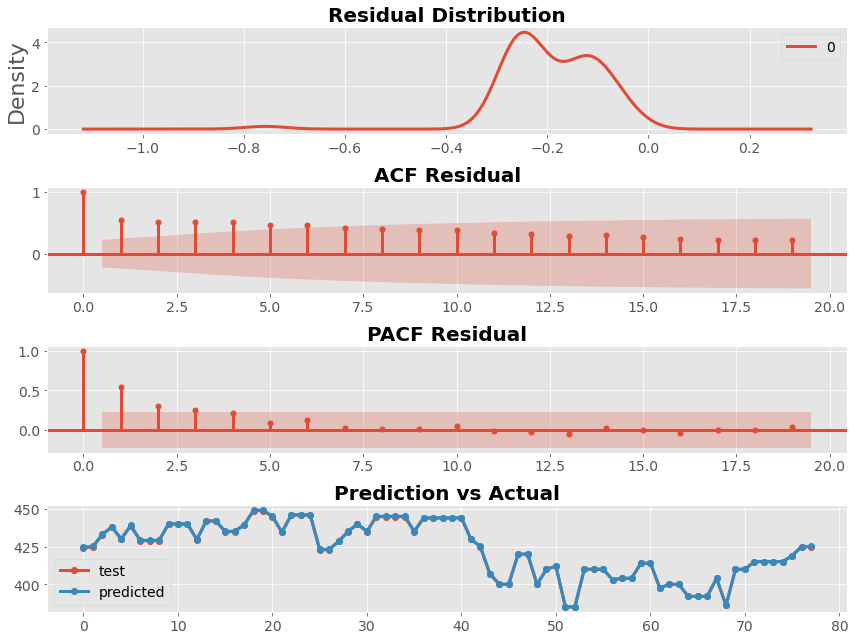

In [103]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg, window)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
bias = residuals.mean()
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

### Add bias based on residual error

                  0
count  7.800000e+01
mean  -1.457524e-15
std    9.940174e-02
min   -5.659945e-01
25%   -6.396987e-02
50%   -1.784056e-02
75%    6.851077e-02
max    1.532084e-01
MAE=0.074 RMSE=0.099 R2=1.000


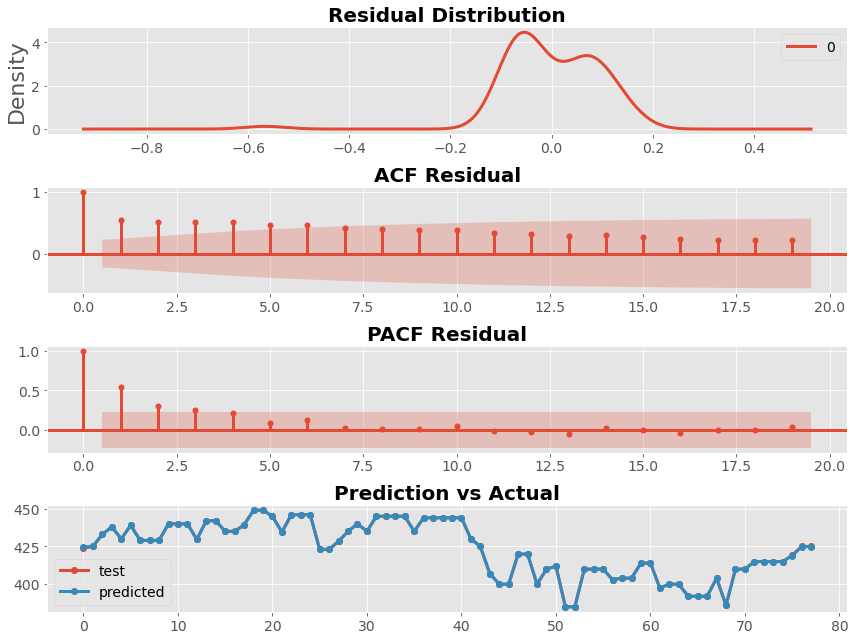

In [104]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg,
                                              window, bias)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

#### Validate Result

##### Forecast 1 week

MAE=7.664 RMSE=17.225 R2=-0.502


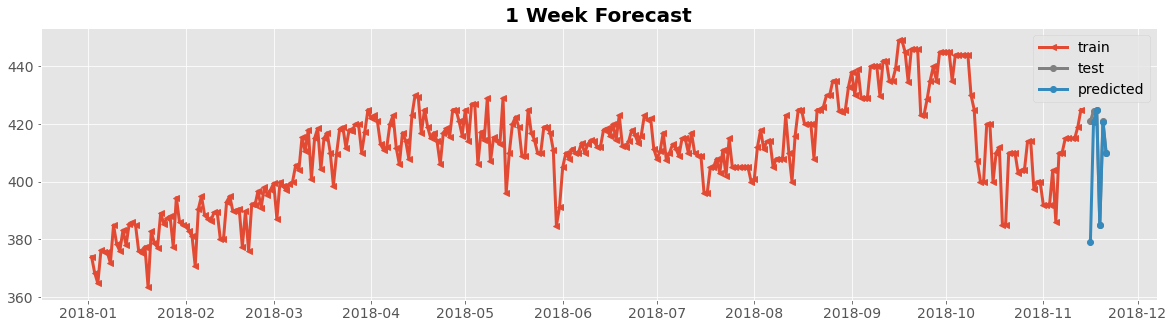

In [105]:
start = test_price.index[0]
end = start + timedelta(days=6)
y1week = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().values[2:]

mae, mse, r2, y, ypred = validate_model(y1week, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('1 Week Forecast')

# Train set
plt.plot(train_price.index[:-2], train_price.values[:-2],
         marker='<', label='train')
# plt.plot(train_price.index[:-2], fitted, color='magenta')
# Test set
plt.plot(y1week.index[:-1], y, marker='o', color='gray', label='test')
plt.plot(y1week.index[:-1], ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

##### Forecast 2 months

MAE=0.897 RMSE=5.690 R2=0.898


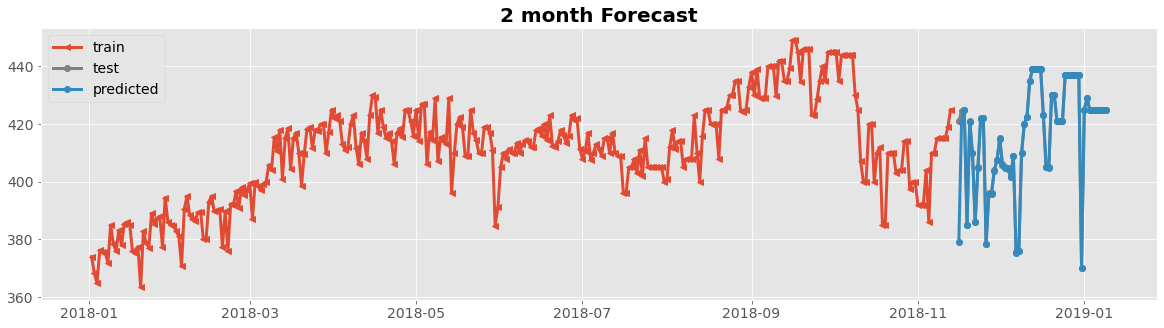

In [106]:
start = test_price.index[0]
end = start + timedelta(days=55)
y2mos = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().values[2:]

mae, mse, r2, y, ypred = validate_model(y2mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('2 month Forecast')

# Train set
plt.plot(train_price.index[:-2], train_price.values[:-2],
         marker='<', label='train')
# plt.plot(train_price.index[:-2], fitted, color='magenta')
# Test set
plt.plot(y2mos.index[:-1], y, marker='o', color='gray', label='test')
plt.plot(y2mos.index[:-1], ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

##### Forecast 3 months

MAE=0.619 RMSE=4.632 R2=0.918


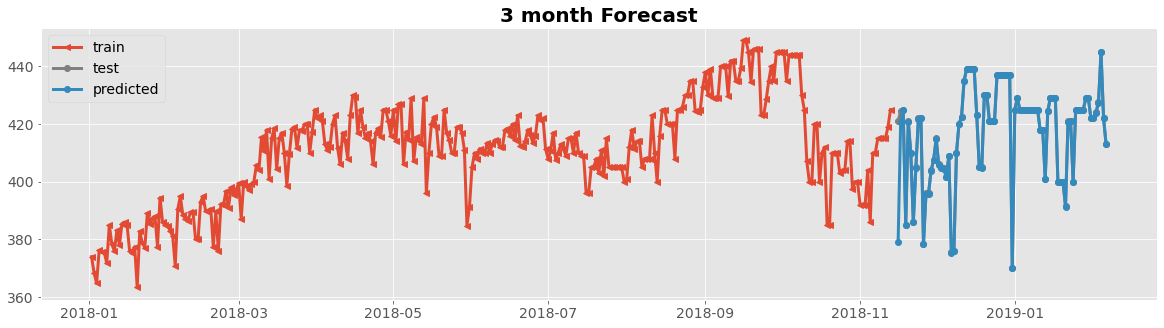

In [107]:
start = test_price.index[0]
end = start + timedelta(days=83)
y3mos = test_price.loc[start:end]

diff = difference(train_price.values.astype('float32'), window)
model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().values[2:]

mae, mse, r2, y, ypred = validate_model(y3mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('3 month Forecast')

# Train set
plt.plot(train_price.index[:-2], train_price.values[:-2],
         marker='<', label='train')
# plt.plot(train_price.index[:-2], fitted, color='magenta')
# Test set
plt.plot(y3mos.index[:-1], y, marker='o', color='gray', label='test')
plt.plot(y3mos.index[:-1], ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()